# Executive Summary

I'm using the environment in the OpenAI gym - Box2D to practice how to train an agent by reinforcement learning. In this notebook, the environment is a classic rocket trajectory optimization problem. ***The goal is to land the lunar lander moving from the top of the screen to the landing pad***

I try differnet methods to complete this goal:

***1. Create a Deep Learning Model with Keras*** (See Section 4)
- After 1 milliom timesteps of learning, the agent received score between -10 to 277 (average 218.0). ***The Lunar Lander landing on the ground 4 out of 5 times properly***
- Time spend 1hr 25min

***2. Epsilon-Greedy Policy*** (See Section 5-6)
- The ***Agent with Epsilon-Greedy Policy stop learning process at epoch #85 with average reward 302***
- Time spend on receiving more than 300 average reward 1hr 19min

***3. PPO Model in Stable_baseline3*** (See Section 7)
- ***Average reward rise to above 160 consistently*** after 2.25M learning timesteps
- Average length of episode after 2.25M learning timesteps is about 350
- Time spend on 5 million learning timesteps in 1h 34min


### ***Table of Content:***
1. What is Lunar Lander
2. Import Dependencies
3. Understanding The Environment
4. Create a Deep Learning Neural Network with Keras
   - 4.1 Build Agent with Keras-RL
   - 4.2 Train the Agents
5. Epsilon-Greedy Policy
6. Q-learning via Gradient Descent
7. PPO Model in Stable_baseline3
8. Video Record and Play the Final Performance

# 1. What is Lunar Lander?

<img src='http://gym.openai.com/videos/2019-10-21--mqt8Qj1mwo/LunarLander-v2/poster.jpg' width='250px'/>

This environment is a classic rocket trajectory optimization problem.

According to Pontryagin's maximum principle, it is optimal to fire the engine at full throttle or turn it off. 

This is the reason why this environment has discrete actions: 
- engine on or off

There are two environment versions: 
- discrete or continuous.

- The landing pad is always at coordinates (0,0).
- The coordinates are the first two numbers in the state vector.
- Landing outside of the landing pad is possible. 
- Fuel is infinite, so an agent can learn to fly and then land on its first attempt.

Source: https://gym.openai.com/envs/LunarLander-v2/


### Action Space
There are four discrete actions available: 
- do nothing, 
- fire left orientation engine, 
- fire main engine, 
- fire right orientation engine.


### Observation Space
There are 8 states: 
- the coordinates of the lander in `x` & `y`,
- its linear velocities in `x` & `y`,
- its angle, 
- its angular velocity, and
- two booleans that represent whether each leg is in contact with the ground or not.

### Rewards
- moving from the top of the screen to the landing pad and coming to rest is about 100-140 points.
- If the lander moves away from the landing pad, it loses reward.
- If the lander crashes, it receives an additional -100 points. 
- If it comes to rest, it receives an additional +100 points. 
- Each leg with ground contact is +10 points.
- Firing the main engine is -0.3 points each frame. 
- Firing the side engine is -0.03 points each frame. 
- Solved is 200 points.

### Starting State
- The lander starts at the top center of the viewport with a random initial force applied to its center of mass.

### Episode Termination
The episode finishes if:
- the lander crashes (the lander body gets in contact with the moon);
- the lander gets outside of the viewport (`x` coordinate is greater than 1);
- the lander is not awake. 
    
A body which is not awake is a body which doesn't move and doesn't collide with any other body:
- When Box2D determines that a body (or group of bodies) has come to rest,
- the body enters a sleep state which has very little CPU overhead. 
- If a body is awake and collides with a sleeping body, then the sleeping body wakes up. 
- Bodies will also wake up if a joint or contact attached to them is destroyed.

# 2. Import Dependencies

2022-03-21 12:00:38.709 python[2795:235555] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fc65a4ffd40>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-03-21 12:00:38.709 python[2795:235555] Warning: Expected min height of view: (<NSButton: 0x7fc63a5fec40>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-03-21 12:00:38.712 python[2795:235555] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fc5ea406cb0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-03-21 12:00:38.714 python[2795:235555] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fc5ea410c80>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Observation space: Box([-inf -inf -inf -inf -inf -inf -inf -inf], [inf inf inf inf inf inf inf inf], (8,), float32)
Action space: Discrete(4)


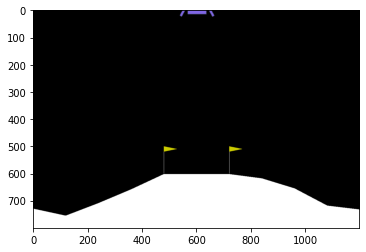

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt

env = gym.make("LunarLander-v2")                       # Using Lunar Lander verion 2 in this notebook
env.reset()                                            # reset the environment to initial default

plt.imshow(env.render('rgb_array'))                    # display the environment
print("Observation space:", env.observation_space)     # There are no coordinates in the state vector
print("Action space:", env.action_space)               # 4 actions are: do nothing, fire left orientation engine, fire main engine, fire right orientation engine.

In [2]:
env.close                                    # close the opened environment 

<bound method Wrapper.close of <TimeLimit<LunarLander<LunarLander-v2>>>>

# 3. Understanding The Environment

In [3]:
obs = env.reset()
print("initial observation code:", obs)

# Note: There are 8 states in observation

initial observation code: [ 0.00382395  1.4118519   0.38731435  0.04140358 -0.00442427 -0.08773248
  0.          0.        ]


In [98]:
# If taken action 2 'fire main engine' in the environment:
action = env.action_space.sample()

new_obs, reward, is_done, info = env.step(action) 

print("Taking action:", action)

# Then the environment will reply 3 things new_observation, reward and is_done to the agent
print("new observation code:", new_obs)
print("reward:", reward)
print("is episode over?:", is_done)

Taking action: 2
new observation code: [ 0.01334715  1.384133    0.45757285 -0.39623848 -0.0112183  -0.05246214
  0.          0.        ]
reward: -0.023984999450721023
is episode over?: False


### Project Baseline Use Random Action

In [5]:
observation, reward, done, info = env.step(action)

In [6]:
observation

array([ 0.01143932,  1.4158826 ,  0.38245684,  0.09894957, -0.01331872,
       -0.09206639,  0.        ,  0.        ], dtype=float32)

In [7]:
%%time
episodes = 5

for episode in range(1, episodes + 1):                     # looping from 1 to 5
    
    obs = env.reset()                                      # initial the set of observation
    
    done = False                                           # initial the game is over = False, until reach maximum number of steps in this particular environment
    
    score = 0                                              # running score counter
    
    timesteps_counter = 0                                  # count the number of timestep spend
    
    while not done:
        
        env.render()                                       # view the graphical representation that environment
        
        action = env.action_space.sample()                 # random choose an action 
        
        n_obs, reward, done, info = env.step(action)       # pass random actions into environment to get back
                                                            # 1. next set of observation
                                                            # 2. reward
                                                            # 3. done (episode is done = True)
        
        score += reward                                    # accumulate each episodes' reward received into score
        
        timesteps_counter += 1                             # +1 in each timestep spend
        
    print('Episode:{} Score:{} Timesteps Spend:{}'.format(episode, score,timesteps_counter))    # print out score for each episode

Episode:1 Score:-121.90417940305434 Timesteps Spend:83
Episode:2 Score:24.594325481854185 Timesteps Spend:74
Episode:3 Score:-187.2061642336522 Timesteps Spend:64
Episode:4 Score:-109.85857953706126 Timesteps Spend:75
Episode:5 Score:-129.90604097939706 Timesteps Spend:86
CPU times: user 329 ms, sys: 47.9 ms, total: 377 ms
Wall time: 401 ms


Remark: 
- The above 5 episode showing that, by taken random actions ***The Lunar Lander not landing properly***. At the end of each episode score receive between -187 to 24 (average 104). 

# 4. Create a Deep Learning Neural Network with Keras

In [8]:
# Import Dependencies
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

# Build a Sequential Neural Network
def build_neural_network(states, actions):
    
    neural_network = Sequential()
    
    neural_network.add(Flatten(input_shape = (1, states), name = 'States'))      # use Flatten layer as the input layer, input_shape = 1 x number of state 
    
    neural_network.add(Dense(512, activation = 'relu', name = 'Dense_1'))        # use Dense layer with 512 units of tensor with relu activation function
    
    neural_network.add(Dense(256, activation = 'relu', name = 'Dense_2'))        # use another Dense layer with 256 units of tensor with relu activation function
    
    neural_network.add(Dense(actions, activation = 'linear', name = 'Actions'))  # the output layer with shape = number of actions with linear activation function
                                                                                 # Output the probability for each actions 
    
    return neural_network                                                        # build_neural_network return a neural_network

In [16]:
del neural_network

In [17]:
# Set the input_shape of the build_model function
states = env.observation_space.shape[0]                         # use .shape[0] to return number of observation space

# Set the output_shape of the build_model function
actions = env.action_space.n                            

# Run the build_model function to build the model
neural_network = build_neural_network(states, actions)                            

# See the model summary
neural_network.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
States (Flatten)             (None, 8)                 0         
_________________________________________________________________
Dense_1 (Dense)              (None, 512)               4608      
_________________________________________________________________
Dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
Actions (Dense)              (None, 4)                 1028      
Total params: 136,964
Trainable params: 136,964
Non-trainable params: 0
_________________________________________________________________


# 4.1 Build Agent with Keras-RL

***Two Types of Policy in Reinforcement Learning (RL):***
1. Value Base RL
2. Policy Base RL 

In [18]:
# Import Dependencies
from rl.agents import DQNAgent                                                      # used DQNAgent here, should try other agents: SARSAAgent      
from rl.policy import BoltzmannQPolicy, LinearAnnealedPolicy, EpsGreedyQPolicy      # used Policy base RL  
from rl.memory import SequentialMemory
import os

In [19]:
# Build an Agent to learn from the model
def build_agent(neural_network, actions):            
    
    policy = LinearAnnealedPolicy(EpsGreedyQPolicy(),    # use EpsGreedyQPolicy()
                                  attr='eps',
                                  value_max = 1,
                                  value_min = .1,
                                  value_test = 0.2,
                                  nb_steps = 10000
    )                    

    memory = SequentialMemory(limit = 1000,              # buffer limit: number of episode
                              window_length = 1          # store pass 1 window for 1000 episode 
                             )
    
    dqn = DQNAgent(model = neural_network, 
                   memory = memory,
                   policy = policy,
                   enable_dueling_network = True,        # Dueling Networks split value and advantage, help the model learn when to take action and when not to bother
                   dueling_type = 'avg',
                   nb_actions = actions,                 # 4 actions to learn
                   nb_steps_warmup = 1000,           
                   target_model_update = 1e-2
                  )
    
    return dqn

# 4.2 Train the Agent

In [20]:
# set the path to save the log
log_path = os.path.join("Training", "Logs", "LunarLander-v2_Keras-RL")

In [25]:
%%time
# run the build_agent function to traing the agent
agent = build_agent(neural_network, actions)             # used build_agent to setup an agent

agent.compile(Adam(learning_rate = 1e-4),                # use Adam optimisation with learning rate 0.0001
            metrics = ['mae']                            # use mean absolute error to evaluate the metric
           )      

history = agent.fit(env, 
        nb_steps = 1000000,                              # number of timesteps 
        visualize = False,                               # visualize during the training
        verbose = 2                                      # how to show the training output
       )

Training for 1000000 steps ...
    116/1000000: episode: 1, duration: 0.131s, episode steps: 116, steps per second: 883, episode reward: -435.381, mean reward: -3.753 [-100.000, 40.408], mean action: 1.603 [0.000, 3.000],  loss: --, mae: --, mean_q: --, mean_eps: --
    228/1000000: episode: 2, duration: 0.063s, episode steps: 112, steps per second: 1779, episode reward: -193.390, mean reward: -1.727 [-100.000,  1.272], mean action: 1.589 [0.000, 3.000],  loss: --, mae: --, mean_q: --, mean_eps: --


/Users/hoikinyu/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


    339/1000000: episode: 3, duration: 0.064s, episode steps: 111, steps per second: 1737, episode reward: -403.567, mean reward: -3.636 [-100.000,  1.353], mean action: 1.270 [0.000, 3.000],  loss: --, mae: --, mean_q: --, mean_eps: --
    448/1000000: episode: 4, duration: 0.059s, episode steps: 109, steps per second: 1837, episode reward: -219.864, mean reward: -2.017 [-100.000, 102.671], mean action: 1.514 [0.000, 3.000],  loss: --, mae: --, mean_q: --, mean_eps: --
    535/1000000: episode: 5, duration: 0.050s, episode steps:  87, steps per second: 1746, episode reward: -312.962, mean reward: -3.597 [-100.000, 30.823], mean action: 1.322 [0.000, 3.000],  loss: --, mae: --, mean_q: --, mean_eps: --
    635/1000000: episode: 6, duration: 0.059s, episode steps: 100, steps per second: 1690, episode reward: -89.122, mean reward: -0.891 [-100.000, 16.751], mean action: 1.540 [0.000, 3.000],  loss: --, mae: --, mean_q: --, mean_eps: --
    707/1000000: episode: 7, duration: 0.041s, episo

/Users/hoikinyu/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


   1022/1000000: episode: 10, duration: 0.558s, episode steps: 107, steps per second: 192, episode reward: -444.970, mean reward: -4.159 [-100.000,  1.028], mean action: 1.589 [0.000, 3.000],  loss: 62.097049, mae: 3.612580, mean_q: -2.032317, mean_eps: 0.909010
   1175/1000000: episode: 11, duration: 0.751s, episode steps: 153, steps per second: 204, episode reward: -105.443, mean reward: -0.689 [-100.000,  8.564], mean action: 1.595 [0.000, 3.000],  loss: 43.784955, mae: 4.043119, mean_q: -3.089873, mean_eps: 0.901180
   1279/1000000: episode: 12, duration: 0.570s, episode steps: 104, steps per second: 182, episode reward: -110.598, mean reward: -1.063 [-100.000, 29.974], mean action: 1.519 [0.000, 3.000],  loss: 29.670988, mae: 4.251080, mean_q: -3.257826, mean_eps: 0.889615
   1365/1000000: episode: 13, duration: 0.413s, episode steps:  86, steps per second: 208, episode reward: -302.575, mean reward: -3.518 [-100.000, 17.550], mean action: 1.488 [0.000, 3.000],  loss: 35.819861, m

   4836/1000000: episode: 42, duration: 0.713s, episode steps: 148, steps per second: 208, episode reward: -85.244, mean reward: -0.576 [-100.000, 13.701], mean action: 1.784 [0.000, 3.000],  loss: 10.014818, mae: 14.403841, mean_q: -1.249108, mean_eps: 0.571465
   5000/1000000: episode: 43, duration: 0.782s, episode steps: 164, steps per second: 210, episode reward: -30.628, mean reward: -0.187 [-100.000, 22.829], mean action: 1.677 [0.000, 3.000],  loss: 8.248719, mae: 13.689221, mean_q: 0.502490, mean_eps: 0.557425
   5100/1000000: episode: 44, duration: 0.479s, episode steps: 100, steps per second: 209, episode reward: -83.857, mean reward: -0.839 [-100.000, 16.815], mean action: 1.690 [0.000, 3.000],  loss: 15.122543, mae: 13.379645, mean_q: 0.372218, mean_eps: 0.545545
   5254/1000000: episode: 45, duration: 0.744s, episode steps: 154, steps per second: 207, episode reward: -39.728, mean reward: -0.258 [-100.000, 11.337], mean action: 1.617 [0.000, 3.000],  loss: 11.670069, mae: 

  22227/1000000: episode: 74, duration: 1.305s, episode steps: 263, steps per second: 201, episode reward: -76.563, mean reward: -0.291 [-100.000,  4.062], mean action: 1.856 [0.000, 3.000],  loss: 4.333753, mae: 10.204486, mean_q: 8.967933, mean_eps: 0.100000
  23227/1000000: episode: 75, duration: 5.331s, episode steps: 1000, steps per second: 188, episode reward: 46.372, mean reward:  0.046 [-18.645, 22.343], mean action: 1.631 [0.000, 3.000],  loss: 8.939444, mae: 11.450695, mean_q: 8.704385, mean_eps: 0.100000
  23797/1000000: episode: 76, duration: 2.993s, episode steps: 570, steps per second: 190, episode reward: 152.529, mean reward:  0.268 [-16.319, 100.000], mean action: 2.196 [0.000, 3.000],  loss: 4.083459, mae: 9.893718, mean_q: 11.285403, mean_eps: 0.100000
  23897/1000000: episode: 77, duration: 0.479s, episode steps: 100, steps per second: 209, episode reward: -124.066, mean reward: -1.241 [-100.000,  9.382], mean action: 1.220 [0.000, 3.000],  loss: 7.172027, mae: 13.4

  33743/1000000: episode: 106, duration: 1.786s, episode steps: 363, steps per second: 203, episode reward: 295.955, mean reward:  0.815 [-16.575, 100.000], mean action: 1.176 [0.000, 3.000],  loss: 7.697164, mae: 15.013220, mean_q: 11.694701, mean_eps: 0.100000
  34209/1000000: episode: 107, duration: 2.391s, episode steps: 466, steps per second: 195, episode reward: 240.999, mean reward:  0.517 [-17.666, 100.000], mean action: 1.320 [0.000, 3.000],  loss: 13.604781, mae: 14.456079, mean_q: 15.515842, mean_eps: 0.100000
  35209/1000000: episode: 108, duration: 5.360s, episode steps: 1000, steps per second: 187, episode reward: -15.376, mean reward: -0.015 [-3.348,  3.823], mean action: 1.587 [0.000, 3.000],  loss: 7.767347, mae: 14.677855, mean_q: 19.226097, mean_eps: 0.100000
  35932/1000000: episode: 109, duration: 3.782s, episode steps: 723, steps per second: 191, episode reward: 147.516, mean reward:  0.204 [-10.225, 100.000], mean action: 1.700 [0.000, 3.000],  loss: 0.595985, ma

  50073/1000000: episode: 138, duration: 4.289s, episode steps: 785, steps per second: 183, episode reward: 155.040, mean reward:  0.198 [-7.898, 100.000], mean action: 1.980 [0.000, 3.000],  loss: 14.340638, mae: 28.552230, mean_q: 38.691316, mean_eps: 0.100000
  50370/1000000: episode: 139, duration: 1.468s, episode steps: 297, steps per second: 202, episode reward: 234.814, mean reward:  0.791 [-17.612, 100.000], mean action: 2.226 [0.000, 3.000],  loss: 6.323265, mae: 26.974830, mean_q: 33.677852, mean_eps: 0.100000
  50503/1000000: episode: 140, duration: 0.637s, episode steps: 133, steps per second: 209, episode reward: -15.159, mean reward: -0.114 [-100.000, 16.695], mean action: 1.421 [0.000, 3.000],  loss: 6.489678, mae: 27.739092, mean_q: 28.250813, mean_eps: 0.100000
  50861/1000000: episode: 141, duration: 1.778s, episode steps: 358, steps per second: 201, episode reward: -218.706, mean reward: -0.611 [-100.000, 15.939], mean action: 1.897 [0.000, 3.000],  loss: 15.120761, 

  65862/1000000: episode: 170, duration: 1.748s, episode steps: 351, steps per second: 201, episode reward: 218.387, mean reward:  0.622 [-2.799, 100.000], mean action: 1.376 [0.000, 3.000],  loss: 4.032458, mae: 47.334263, mean_q: 64.611072, mean_eps: 0.100000
  66205/1000000: episode: 171, duration: 1.792s, episode steps: 343, steps per second: 191, episode reward: 271.433, mean reward:  0.791 [-20.663, 100.000], mean action: 0.857 [0.000, 3.000],  loss: 6.162441, mae: 46.950796, mean_q: 63.896057, mean_eps: 0.100000
  66719/1000000: episode: 172, duration: 2.749s, episode steps: 514, steps per second: 187, episode reward: 253.855, mean reward:  0.494 [-20.271, 100.000], mean action: 1.490 [0.000, 3.000],  loss: 3.826026, mae: 43.093229, mean_q: 58.631339, mean_eps: 0.100000
  66898/1000000: episode: 173, duration: 0.949s, episode steps: 179, steps per second: 189, episode reward: -4.736, mean reward: -0.026 [-100.000, 13.122], mean action: 1.810 [0.000, 3.000],  loss: 4.160287, mae:

  73506/1000000: episode: 202, duration: 0.941s, episode steps: 175, steps per second: 186, episode reward: 37.894, mean reward:  0.217 [-100.000, 23.693], mean action: 1.486 [0.000, 3.000],  loss: 11.510886, mae: 57.614340, mean_q: 69.501952, mean_eps: 0.100000
  73792/1000000: episode: 203, duration: 1.433s, episode steps: 286, steps per second: 200, episode reward: -199.968, mean reward: -0.699 [-100.000, 15.242], mean action: 1.486 [0.000, 3.000],  loss: 12.399951, mae: 57.096511, mean_q: 62.881879, mean_eps: 0.100000
  74252/1000000: episode: 204, duration: 2.576s, episode steps: 460, steps per second: 179, episode reward: 243.866, mean reward:  0.530 [-21.505, 100.000], mean action: 1.239 [0.000, 3.000],  loss: 14.810784, mae: 53.136794, mean_q: 37.577767, mean_eps: 0.100000
  74499/1000000: episode: 205, duration: 1.283s, episode steps: 247, steps per second: 192, episode reward: 185.589, mean reward:  0.751 [-19.881, 100.000], mean action: 1.769 [0.000, 3.000],  loss: 22.213419

  89317/1000000: episode: 234, duration: 0.915s, episode steps: 190, steps per second: 208, episode reward: 43.990, mean reward:  0.232 [-100.000, 14.789], mean action: 1.384 [0.000, 3.000],  loss: 17.462583, mae: 32.588996, mean_q: 44.943785, mean_eps: 0.100000
  89460/1000000: episode: 235, duration: 0.681s, episode steps: 143, steps per second: 210, episode reward: -39.582, mean reward: -0.277 [-100.000,  7.246], mean action: 1.273 [0.000, 3.000],  loss: 16.693248, mae: 37.135342, mean_q: 50.980883, mean_eps: 0.100000
  89765/1000000: episode: 236, duration: 1.519s, episode steps: 305, steps per second: 201, episode reward: 267.962, mean reward:  0.879 [-12.633, 100.000], mean action: 0.925 [0.000, 3.000],  loss: 19.946491, mae: 38.124768, mean_q: 52.228328, mean_eps: 0.100000
  90087/1000000: episode: 237, duration: 1.603s, episode steps: 322, steps per second: 201, episode reward: 238.889, mean reward:  0.742 [-17.841, 100.000], mean action: 1.342 [0.000, 3.000],  loss: 12.896945,

 102970/1000000: episode: 266, duration: 3.418s, episode steps: 635, steps per second: 186, episode reward: 165.696, mean reward:  0.261 [-20.604, 100.000], mean action: 1.022 [0.000, 3.000],  loss: 5.397411, mae: 33.332310, mean_q: 45.695838, mean_eps: 0.100000
 103488/1000000: episode: 267, duration: 2.681s, episode steps: 518, steps per second: 193, episode reward: 199.094, mean reward:  0.384 [-11.411, 100.000], mean action: 1.288 [0.000, 3.000],  loss: 4.477270, mae: 35.249902, mean_q: 48.449222, mean_eps: 0.100000
 103843/1000000: episode: 268, duration: 1.791s, episode steps: 355, steps per second: 198, episode reward: 244.958, mean reward:  0.690 [-12.892, 100.000], mean action: 1.690 [0.000, 3.000],  loss: 4.268493, mae: 36.671774, mean_q: 50.334443, mean_eps: 0.100000
 104515/1000000: episode: 269, duration: 3.463s, episode steps: 672, steps per second: 194, episode reward: 228.467, mean reward:  0.340 [-20.170, 100.000], mean action: 1.378 [0.000, 3.000],  loss: 5.060366, ma

 115506/1000000: episode: 298, duration: 1.861s, episode steps: 374, steps per second: 201, episode reward: 274.969, mean reward:  0.735 [-19.822, 100.000], mean action: 1.233 [0.000, 3.000],  loss: 2.066929, mae: 45.512817, mean_q: 61.926710, mean_eps: 0.100000
 115606/1000000: episode: 299, duration: 0.472s, episode steps: 100, steps per second: 212, episode reward: -48.321, mean reward: -0.483 [-100.000, 10.554], mean action: 1.220 [0.000, 3.000],  loss: 3.200796, mae: 44.823940, mean_q: 61.075129, mean_eps: 0.100000
 116004/1000000: episode: 300, duration: 1.954s, episode steps: 398, steps per second: 204, episode reward: 226.614, mean reward:  0.569 [-17.490, 100.000], mean action: 1.764 [0.000, 3.000],  loss: 7.126574, mae: 46.327602, mean_q: 63.123956, mean_eps: 0.100000
 116482/1000000: episode: 301, duration: 2.473s, episode steps: 478, steps per second: 193, episode reward: 235.254, mean reward:  0.492 [-18.139, 100.000], mean action: 1.471 [0.000, 3.000],  loss: 3.751967, ma

 128712/1000000: episode: 330, duration: 2.122s, episode steps: 421, steps per second: 198, episode reward: 275.900, mean reward:  0.655 [-17.437, 100.000], mean action: 1.342 [0.000, 3.000],  loss: 2.914382, mae: 43.678286, mean_q: 59.239567, mean_eps: 0.100000
 129114/1000000: episode: 331, duration: 2.035s, episode steps: 402, steps per second: 198, episode reward: 262.237, mean reward:  0.652 [-18.603, 100.000], mean action: 1.480 [0.000, 3.000],  loss: 2.141713, mae: 43.597847, mean_q: 58.894395, mean_eps: 0.100000
 129544/1000000: episode: 332, duration: 2.181s, episode steps: 430, steps per second: 197, episode reward: 258.047, mean reward:  0.600 [-2.864, 100.000], mean action: 1.107 [0.000, 3.000],  loss: 2.516116, mae: 44.560851, mean_q: 60.000491, mean_eps: 0.100000
 129951/1000000: episode: 333, duration: 2.063s, episode steps: 407, steps per second: 197, episode reward: 251.409, mean reward:  0.618 [-3.010, 100.000], mean action: 1.170 [0.000, 3.000],  loss: 2.555131, mae:

 141467/1000000: episode: 362, duration: 1.477s, episode steps: 300, steps per second: 203, episode reward: 293.736, mean reward:  0.979 [-9.047, 100.000], mean action: 1.247 [0.000, 3.000],  loss: 1.506511, mae: 59.186331, mean_q: 80.216852, mean_eps: 0.100000
 141769/1000000: episode: 363, duration: 1.462s, episode steps: 302, steps per second: 207, episode reward: 285.875, mean reward:  0.947 [-18.832, 100.000], mean action: 0.887 [0.000, 3.000],  loss: 2.125913, mae: 62.351476, mean_q: 84.283034, mean_eps: 0.100000
 142769/1000000: episode: 364, duration: 5.266s, episode steps: 1000, steps per second: 190, episode reward: 123.246, mean reward:  0.123 [-18.005, 22.792], mean action: 0.923 [0.000, 3.000],  loss: 2.381090, mae: 52.798674, mean_q: 71.507713, mean_eps: 0.100000
 142986/1000000: episode: 365, duration: 1.040s, episode steps: 217, steps per second: 209, episode reward: 242.470, mean reward:  1.117 [-9.589, 100.000], mean action: 1.134 [0.000, 3.000],  loss: 1.242714, mae:

 153911/1000000: episode: 394, duration: 5.945s, episode steps: 1000, steps per second: 168, episode reward: 71.151, mean reward:  0.071 [-19.257, 22.433], mean action: 1.249 [0.000, 3.000],  loss: 2.831769, mae: 46.310511, mean_q: 62.894165, mean_eps: 0.100000
 154166/1000000: episode: 395, duration: 1.246s, episode steps: 255, steps per second: 205, episode reward: 298.791, mean reward:  1.172 [-7.372, 100.000], mean action: 1.373 [0.000, 3.000],  loss: 3.540755, mae: 44.580317, mean_q: 60.578352, mean_eps: 0.100000
 154927/1000000: episode: 396, duration: 3.964s, episode steps: 761, steps per second: 192, episode reward: 228.043, mean reward:  0.300 [-20.725, 100.000], mean action: 0.925 [0.000, 3.000],  loss: 3.828515, mae: 48.269765, mean_q: 65.610568, mean_eps: 0.100000
 155043/1000000: episode: 397, duration: 0.553s, episode steps: 116, steps per second: 210, episode reward: 25.615, mean reward:  0.221 [-100.000, 14.514], mean action: 1.526 [0.000, 3.000],  loss: 4.804380, mae: 

 164596/1000000: episode: 426, duration: 2.670s, episode steps: 518, steps per second: 194, episode reward: 260.243, mean reward:  0.502 [-10.383, 100.000], mean action: 1.689 [0.000, 3.000],  loss: 3.145832, mae: 50.837563, mean_q: 68.572029, mean_eps: 0.100000
 164915/1000000: episode: 427, duration: 1.565s, episode steps: 319, steps per second: 204, episode reward: 279.994, mean reward:  0.878 [-10.281, 100.000], mean action: 1.044 [0.000, 3.000],  loss: 3.108337, mae: 49.712043, mean_q: 67.137988, mean_eps: 0.100000
 165151/1000000: episode: 428, duration: 1.170s, episode steps: 236, steps per second: 202, episode reward: 266.427, mean reward:  1.129 [-11.434, 100.000], mean action: 1.564 [0.000, 3.000],  loss: 3.230393, mae: 52.114249, mean_q: 70.397493, mean_eps: 0.100000
 165404/1000000: episode: 429, duration: 1.239s, episode steps: 253, steps per second: 204, episode reward: 266.652, mean reward:  1.054 [-18.526, 100.000], mean action: 1.043 [0.000, 3.000],  loss: 4.430514, ma

 176054/1000000: episode: 458, duration: 1.910s, episode steps: 389, steps per second: 204, episode reward: 310.578, mean reward:  0.798 [-9.547, 100.000], mean action: 1.301 [0.000, 3.000],  loss: 3.781977, mae: 39.981228, mean_q: 55.380982, mean_eps: 0.100000
 176393/1000000: episode: 459, duration: 1.667s, episode steps: 339, steps per second: 203, episode reward: 260.937, mean reward:  0.770 [-22.548, 100.000], mean action: 1.174 [0.000, 3.000],  loss: 4.617505, mae: 52.638162, mean_q: 71.296023, mean_eps: 0.100000
 176791/1000000: episode: 460, duration: 1.990s, episode steps: 398, steps per second: 200, episode reward: 291.649, mean reward:  0.733 [-18.533, 100.000], mean action: 1.173 [0.000, 3.000],  loss: 2.962950, mae: 54.451180, mean_q: 73.526986, mean_eps: 0.100000
 177063/1000000: episode: 461, duration: 1.357s, episode steps: 272, steps per second: 200, episode reward: 289.434, mean reward:  1.064 [-9.813, 100.000], mean action: 1.482 [0.000, 3.000],  loss: 3.961459, mae:

 185979/1000000: episode: 490, duration: 3.674s, episode steps: 716, steps per second: 195, episode reward: 239.438, mean reward:  0.334 [-19.885, 100.000], mean action: 1.145 [0.000, 3.000],  loss: 6.009063, mae: 44.917849, mean_q: 60.976016, mean_eps: 0.100000
 186350/1000000: episode: 491, duration: 1.819s, episode steps: 371, steps per second: 204, episode reward: 271.630, mean reward:  0.732 [-12.106, 100.000], mean action: 1.356 [0.000, 3.000],  loss: 3.292842, mae: 47.202646, mean_q: 63.880198, mean_eps: 0.100000
 186675/1000000: episode: 492, duration: 1.606s, episode steps: 325, steps per second: 202, episode reward: 286.199, mean reward:  0.881 [-19.694, 100.000], mean action: 1.422 [0.000, 3.000],  loss: 2.720353, mae: 52.965042, mean_q: 71.374366, mean_eps: 0.100000
 186990/1000000: episode: 493, duration: 1.574s, episode steps: 315, steps per second: 200, episode reward: 243.133, mean reward:  0.772 [-11.318, 100.000], mean action: 1.352 [0.000, 3.000],  loss: 4.022982, ma

 197943/1000000: episode: 522, duration: 0.937s, episode steps: 195, steps per second: 208, episode reward: 252.933, mean reward:  1.297 [-2.644, 100.000], mean action: 1.226 [0.000, 3.000],  loss: 3.828770, mae: 56.431427, mean_q: 76.601825, mean_eps: 0.100000
 198137/1000000: episode: 523, duration: 0.937s, episode steps: 194, steps per second: 207, episode reward: 271.533, mean reward:  1.400 [-12.435, 100.000], mean action: 1.582 [0.000, 3.000],  loss: 5.034804, mae: 55.643466, mean_q: 75.411039, mean_eps: 0.100000
 199137/1000000: episode: 524, duration: 5.242s, episode steps: 1000, steps per second: 191, episode reward: 142.015, mean reward:  0.142 [-23.747, 22.220], mean action: 2.129 [0.000, 3.000],  loss: 3.578843, mae: 53.319674, mean_q: 72.053179, mean_eps: 0.100000
 199293/1000000: episode: 525, duration: 0.741s, episode steps: 156, steps per second: 210, episode reward:  5.071, mean reward:  0.033 [-100.000,  8.374], mean action: 1.513 [0.000, 3.000],  loss: 2.135468, mae:

 207306/1000000: episode: 554, duration: 2.430s, episode steps: 415, steps per second: 171, episode reward: 296.007, mean reward:  0.713 [-9.719, 100.000], mean action: 1.292 [0.000, 3.000],  loss: 2.737268, mae: 62.890925, mean_q: 84.923114, mean_eps: 0.100000
 207502/1000000: episode: 555, duration: 1.171s, episode steps: 196, steps per second: 167, episode reward: 264.919, mean reward:  1.352 [-10.199, 100.000], mean action: 0.980 [0.000, 3.000],  loss: 3.588177, mae: 62.113611, mean_q: 84.032675, mean_eps: 0.100000
 207759/1000000: episode: 556, duration: 1.267s, episode steps: 257, steps per second: 203, episode reward: 291.669, mean reward:  1.135 [-10.749, 100.000], mean action: 1.553 [0.000, 3.000],  loss: 3.616306, mae: 62.119967, mean_q: 83.966799, mean_eps: 0.100000
 207976/1000000: episode: 557, duration: 1.050s, episode steps: 217, steps per second: 207, episode reward: 270.038, mean reward:  1.244 [-18.365, 100.000], mean action: 1.157 [0.000, 3.000],  loss: 3.148867, mae

 216797/1000000: episode: 586, duration: 0.827s, episode steps: 173, steps per second: 209, episode reward: 252.072, mean reward:  1.457 [-6.398, 100.000], mean action: 1.312 [0.000, 3.000],  loss: 1.885548, mae: 63.962957, mean_q: 86.727510, mean_eps: 0.100000
 216935/1000000: episode: 587, duration: 0.665s, episode steps: 138, steps per second: 208, episode reward: 21.560, mean reward:  0.156 [-100.000, 17.875], mean action: 1.659 [0.000, 3.000],  loss: 4.268258, mae: 63.696331, mean_q: 86.255287, mean_eps: 0.100000
 217232/1000000: episode: 588, duration: 1.458s, episode steps: 297, steps per second: 204, episode reward: 303.314, mean reward:  1.021 [-19.742, 100.000], mean action: 1.037 [0.000, 3.000],  loss: 15.517594, mae: 65.546021, mean_q: 89.163676, mean_eps: 0.100000
 217523/1000000: episode: 589, duration: 1.417s, episode steps: 291, steps per second: 205, episode reward: 278.720, mean reward:  0.958 [-17.611, 100.000], mean action: 0.704 [0.000, 3.000],  loss: 8.598040, mae

 223381/1000000: episode: 618, duration: 0.909s, episode steps: 188, steps per second: 207, episode reward: -44.418, mean reward: -0.236 [-100.000, 30.371], mean action: 1.601 [0.000, 3.000],  loss: 14.171947, mae: 26.012463, mean_q: 19.198776, mean_eps: 0.100000
 223643/1000000: episode: 619, duration: 1.265s, episode steps: 262, steps per second: 207, episode reward: 300.915, mean reward:  1.149 [-9.780, 100.000], mean action: 1.359 [0.000, 3.000],  loss: 17.050337, mae: 29.062831, mean_q: 23.149575, mean_eps: 0.100000
 223737/1000000: episode: 620, duration: 0.448s, episode steps:  94, steps per second: 210, episode reward: -1.018, mean reward: -0.011 [-100.000, 10.018], mean action: 1.596 [0.000, 3.000],  loss: 15.540859, mae: 30.188794, mean_q: 28.372210, mean_eps: 0.100000
 223825/1000000: episode: 621, duration: 0.424s, episode steps:  88, steps per second: 207, episode reward: 33.040, mean reward:  0.375 [-100.000, 16.294], mean action: 1.830 [0.000, 3.000],  loss: 12.408398, m

 234009/1000000: episode: 650, duration: 1.387s, episode steps: 287, steps per second: 207, episode reward: 293.824, mean reward:  1.024 [-16.800, 100.000], mean action: 1.247 [0.000, 3.000],  loss: 4.629867, mae: 54.506188, mean_q: 73.555575, mean_eps: 0.100000
 234248/1000000: episode: 651, duration: 1.151s, episode steps: 239, steps per second: 208, episode reward: 269.474, mean reward:  1.128 [-17.549, 100.000], mean action: 0.812 [0.000, 3.000],  loss: 5.040196, mae: 54.029905, mean_q: 73.041124, mean_eps: 0.100000
 234339/1000000: episode: 652, duration: 0.431s, episode steps:  91, steps per second: 211, episode reward: -29.402, mean reward: -0.323 [-100.000, 10.848], mean action: 1.044 [0.000, 3.000],  loss: 5.274687, mae: 53.932091, mean_q: 72.999423, mean_eps: 0.100000
 234657/1000000: episode: 653, duration: 1.564s, episode steps: 318, steps per second: 203, episode reward: 283.742, mean reward:  0.892 [-9.720, 100.000], mean action: 1.167 [0.000, 3.000],  loss: 7.178581, mae

 245000/1000000: episode: 682, duration: 1.876s, episode steps: 379, steps per second: 202, episode reward: 262.116, mean reward:  0.692 [-17.336, 100.000], mean action: 1.029 [0.000, 3.000],  loss: 7.523999, mae: 45.849415, mean_q: 61.968095, mean_eps: 0.100000
 245417/1000000: episode: 683, duration: 2.087s, episode steps: 417, steps per second: 200, episode reward: 236.248, mean reward:  0.567 [-20.874, 100.000], mean action: 0.722 [0.000, 3.000],  loss: 6.979153, mae: 43.332104, mean_q: 58.839812, mean_eps: 0.100000
 245823/1000000: episode: 684, duration: 2.099s, episode steps: 406, steps per second: 193, episode reward: 224.765, mean reward:  0.554 [-17.457, 100.000], mean action: 1.650 [0.000, 3.000],  loss: 6.441795, mae: 43.819154, mean_q: 59.327692, mean_eps: 0.100000
 246461/1000000: episode: 685, duration: 3.273s, episode steps: 638, steps per second: 195, episode reward: 210.509, mean reward:  0.330 [-18.875, 100.000], mean action: 0.840 [0.000, 3.000],  loss: 5.318318, ma

 255727/1000000: episode: 714, duration: 1.357s, episode steps: 273, steps per second: 201, episode reward: 266.084, mean reward:  0.975 [-17.439, 100.000], mean action: 1.505 [0.000, 3.000],  loss: 4.950209, mae: 47.680153, mean_q: 64.415278, mean_eps: 0.100000
 256081/1000000: episode: 715, duration: 1.768s, episode steps: 354, steps per second: 200, episode reward: 278.386, mean reward:  0.786 [-10.648, 100.000], mean action: 0.944 [0.000, 3.000],  loss: 6.434489, mae: 52.974680, mean_q: 71.594033, mean_eps: 0.100000
 256589/1000000: episode: 716, duration: 2.549s, episode steps: 508, steps per second: 199, episode reward: 275.057, mean reward:  0.541 [-18.722, 100.000], mean action: 1.201 [0.000, 3.000],  loss: 5.746656, mae: 51.449035, mean_q: 69.623002, mean_eps: 0.100000
 256934/1000000: episode: 717, duration: 1.714s, episode steps: 345, steps per second: 201, episode reward: 290.441, mean reward:  0.842 [-10.540, 100.000], mean action: 0.986 [0.000, 3.000],  loss: 4.158002, ma

 262923/1000000: episode: 746, duration: 2.018s, episode steps: 408, steps per second: 202, episode reward: 276.762, mean reward:  0.678 [-18.804, 100.000], mean action: 1.201 [0.000, 3.000],  loss: 8.388819, mae: 46.599067, mean_q: 60.919376, mean_eps: 0.100000
 263079/1000000: episode: 747, duration: 0.750s, episode steps: 156, steps per second: 208, episode reward: -13.871, mean reward: -0.089 [-100.000, 14.027], mean action: 1.885 [0.000, 3.000],  loss: 5.613089, mae: 42.593491, mean_q: 57.059184, mean_eps: 0.100000
 263547/1000000: episode: 748, duration: 2.303s, episode steps: 468, steps per second: 203, episode reward: 294.561, mean reward:  0.629 [-17.969, 100.000], mean action: 0.596 [0.000, 3.000],  loss: 8.325245, mae: 45.919758, mean_q: 60.681642, mean_eps: 0.100000
 264120/1000000: episode: 749, duration: 2.894s, episode steps: 573, steps per second: 198, episode reward: 297.370, mean reward:  0.519 [-17.515, 100.000], mean action: 0.887 [0.000, 3.000],  loss: 5.737151, ma

 273464/1000000: episode: 778, duration: 0.969s, episode steps: 202, steps per second: 209, episode reward: 279.100, mean reward:  1.382 [-19.044, 100.000], mean action: 1.104 [0.000, 3.000],  loss: 5.882971, mae: 50.465661, mean_q: 69.001142, mean_eps: 0.100000
 273573/1000000: episode: 779, duration: 0.525s, episode steps: 109, steps per second: 208, episode reward:  8.082, mean reward:  0.074 [-100.000, 10.175], mean action: 1.972 [0.000, 3.000],  loss: 5.785688, mae: 51.173633, mean_q: 69.992652, mean_eps: 0.100000
 273788/1000000: episode: 780, duration: 1.028s, episode steps: 215, steps per second: 209, episode reward: 261.427, mean reward:  1.216 [-3.022, 100.000], mean action: 1.326 [0.000, 3.000],  loss: 13.599524, mae: 52.991793, mean_q: 72.337347, mean_eps: 0.100000
 274104/1000000: episode: 781, duration: 1.541s, episode steps: 316, steps per second: 205, episode reward: 282.903, mean reward:  0.895 [-9.593, 100.000], mean action: 1.241 [0.000, 3.000],  loss: 9.812052, mae:

 283372/1000000: episode: 810, duration: 5.376s, episode steps: 1000, steps per second: 186, episode reward: 148.359, mean reward:  0.148 [-19.818, 23.554], mean action: 1.554 [0.000, 3.000],  loss: 2.314772, mae: 47.854448, mean_q: 64.813772, mean_eps: 0.100000
 284372/1000000: episode: 811, duration: 5.222s, episode steps: 1000, steps per second: 191, episode reward: 175.501, mean reward:  0.176 [-20.259, 22.368], mean action: 1.409 [0.000, 3.000],  loss: 1.594596, mae: 43.157363, mean_q: 58.323021, mean_eps: 0.100000
 284466/1000000: episode: 812, duration: 0.457s, episode steps:  94, steps per second: 206, episode reward: 41.130, mean reward:  0.438 [-100.000, 19.769], mean action: 1.894 [0.000, 3.000],  loss: 2.405283, mae: 43.945624, mean_q: 59.127850, mean_eps: 0.100000
 284621/1000000: episode: 813, duration: 0.741s, episode steps: 155, steps per second: 209, episode reward: 281.792, mean reward:  1.818 [-11.017, 100.000], mean action: 1.516 [0.000, 3.000],  loss: 7.194188, mae

 290782/1000000: episode: 842, duration: 0.687s, episode steps: 144, steps per second: 210, episode reward: -132.120, mean reward: -0.917 [-100.000, 51.566], mean action: 1.215 [0.000, 3.000],  loss: 31.100093, mae: 67.299989, mean_q: 91.258233, mean_eps: 0.100000
 290900/1000000: episode: 843, duration: 0.566s, episode steps: 118, steps per second: 208, episode reward: -16.454, mean reward: -0.139 [-100.000, 10.445], mean action: 1.703 [0.000, 3.000],  loss: 26.251449, mae: 64.178566, mean_q: 85.977237, mean_eps: 0.100000
 290986/1000000: episode: 844, duration: 0.413s, episode steps:  86, steps per second: 208, episode reward: -89.364, mean reward: -1.039 [-100.000, 15.076], mean action: 1.884 [0.000, 3.000],  loss: 30.912980, mae: 65.246644, mean_q: 86.594667, mean_eps: 0.100000
 291061/1000000: episode: 845, duration: 0.357s, episode steps:  75, steps per second: 210, episode reward: -9.975, mean reward: -0.133 [-100.000, 14.553], mean action: 1.267 [0.000, 3.000],  loss: 22.505591

 301494/1000000: episode: 874, duration: 1.759s, episode steps: 352, steps per second: 200, episode reward: 286.061, mean reward:  0.813 [-18.011, 100.000], mean action: 1.571 [0.000, 3.000],  loss: 3.663547, mae: 46.456323, mean_q: 63.108806, mean_eps: 0.100000
 301894/1000000: episode: 875, duration: 2.018s, episode steps: 400, steps per second: 198, episode reward: 226.845, mean reward:  0.567 [-10.917, 100.000], mean action: 1.262 [0.000, 3.000],  loss: 3.013542, mae: 48.831351, mean_q: 66.175519, mean_eps: 0.100000
 302341/1000000: episode: 876, duration: 2.313s, episode steps: 447, steps per second: 193, episode reward: 277.648, mean reward:  0.621 [-19.024, 100.000], mean action: 1.230 [0.000, 3.000],  loss: 2.072605, mae: 49.750056, mean_q: 67.196490, mean_eps: 0.100000
 302668/1000000: episode: 877, duration: 1.634s, episode steps: 327, steps per second: 200, episode reward: 297.571, mean reward:  0.910 [-10.402, 100.000], mean action: 1.621 [0.000, 3.000],  loss: 2.473925, ma

 313774/1000000: episode: 906, duration: 2.679s, episode steps: 532, steps per second: 199, episode reward: 260.183, mean reward:  0.489 [-11.453, 100.000], mean action: 1.002 [0.000, 3.000],  loss: 1.803323, mae: 47.351245, mean_q: 64.055878, mean_eps: 0.100000
 314203/1000000: episode: 907, duration: 2.203s, episode steps: 429, steps per second: 195, episode reward: 249.137, mean reward:  0.581 [-19.387, 100.000], mean action: 1.380 [0.000, 3.000],  loss: 2.721760, mae: 48.285666, mean_q: 65.191825, mean_eps: 0.100000
 314616/1000000: episode: 908, duration: 2.114s, episode steps: 413, steps per second: 195, episode reward: 270.454, mean reward:  0.655 [-18.620, 100.000], mean action: 2.310 [0.000, 3.000],  loss: 2.996152, mae: 49.269288, mean_q: 66.689595, mean_eps: 0.100000
 314782/1000000: episode: 909, duration: 0.792s, episode steps: 166, steps per second: 209, episode reward: 10.350, mean reward:  0.062 [-100.000, 11.350], mean action: 1.687 [0.000, 3.000],  loss: 2.697266, mae

 327927/1000000: episode: 938, duration: 1.300s, episode steps: 266, steps per second: 205, episode reward: 272.532, mean reward:  1.025 [-18.006, 100.000], mean action: 0.823 [0.000, 3.000],  loss: 8.728278, mae: 54.355667, mean_q: 74.268080, mean_eps: 0.100000
 328187/1000000: episode: 939, duration: 1.263s, episode steps: 260, steps per second: 206, episode reward: 257.095, mean reward:  0.989 [-17.515, 100.000], mean action: 0.965 [0.000, 3.000],  loss: 6.493326, mae: 54.225107, mean_q: 74.081605, mean_eps: 0.100000
 328419/1000000: episode: 940, duration: 1.119s, episode steps: 232, steps per second: 207, episode reward: 249.075, mean reward:  1.074 [-7.731, 100.000], mean action: 1.004 [0.000, 3.000],  loss: 7.906148, mae: 56.284828, mean_q: 76.698457, mean_eps: 0.100000
 328626/1000000: episode: 941, duration: 0.999s, episode steps: 207, steps per second: 207, episode reward: 266.590, mean reward:  1.288 [-9.442, 100.000], mean action: 1.213 [0.000, 3.000],  loss: 5.746250, mae:

 338074/1000000: episode: 970, duration: 5.627s, episode steps: 1000, steps per second: 178, episode reward: -57.678, mean reward: -0.058 [-20.918, 10.894], mean action: 1.921 [0.000, 3.000],  loss: 21.476505, mae: 38.764527, mean_q: 41.888531, mean_eps: 0.100000
 338561/1000000: episode: 971, duration: 2.520s, episode steps: 487, steps per second: 193, episode reward: 236.987, mean reward:  0.487 [-20.955, 100.000], mean action: 0.649 [0.000, 3.000],  loss: 1.927235, mae: 21.679892, mean_q: 23.853182, mean_eps: 0.100000
 338889/1000000: episode: 972, duration: 1.621s, episode steps: 328, steps per second: 202, episode reward: 227.092, mean reward:  0.692 [-17.839, 100.000], mean action: 1.119 [0.000, 3.000],  loss: 2.813269, mae: 32.271567, mean_q: 44.694823, mean_eps: 0.100000
 339292/1000000: episode: 973, duration: 1.991s, episode steps: 403, steps per second: 202, episode reward: 303.370, mean reward:  0.753 [-18.178, 100.000], mean action: 0.789 [0.000, 3.000],  loss: 4.978358, m

 348620/1000000: episode: 1002, duration: 1.559s, episode steps: 319, steps per second: 205, episode reward: 302.353, mean reward:  0.948 [-20.107, 100.000], mean action: 0.994 [0.000, 3.000],  loss: 3.277513, mae: 55.694310, mean_q: 75.271074, mean_eps: 0.100000
 348957/1000000: episode: 1003, duration: 1.633s, episode steps: 337, steps per second: 206, episode reward: 301.706, mean reward:  0.895 [-10.398, 100.000], mean action: 0.920 [0.000, 3.000],  loss: 2.299177, mae: 54.692834, mean_q: 74.219234, mean_eps: 0.100000
 349101/1000000: episode: 1004, duration: 0.695s, episode steps: 144, steps per second: 207, episode reward: 38.354, mean reward:  0.266 [-100.000, 14.954], mean action: 1.806 [0.000, 3.000],  loss: 3.846889, mae: 56.152313, mean_q: 76.159316, mean_eps: 0.100000
 349404/1000000: episode: 1005, duration: 1.468s, episode steps: 303, steps per second: 206, episode reward: 281.251, mean reward:  0.928 [-18.366, 100.000], mean action: 0.851 [0.000, 3.000],  loss: 13.743521

 359741/1000000: episode: 1034, duration: 1.569s, episode steps: 316, steps per second: 201, episode reward: 255.422, mean reward:  0.808 [-13.983, 100.000], mean action: 0.813 [0.000, 3.000],  loss: 25.345198, mae: 50.598294, mean_q: 69.364751, mean_eps: 0.100000
 360304/1000000: episode: 1035, duration: 2.903s, episode steps: 563, steps per second: 194, episode reward: 156.165, mean reward:  0.277 [-19.751, 100.000], mean action: 1.849 [0.000, 3.000],  loss: 12.068429, mae: 48.480913, mean_q: 64.274188, mean_eps: 0.100000
 361276/1000000: episode: 1036, duration: 5.348s, episode steps: 972, steps per second: 182, episode reward: 256.542, mean reward:  0.264 [-20.833, 100.000], mean action: 1.718 [0.000, 3.000],  loss: 10.682830, mae: 36.658955, mean_q: 41.366155, mean_eps: 0.100000
 362276/1000000: episode: 1037, duration: 5.613s, episode steps: 1000, steps per second: 178, episode reward: -2.267, mean reward: -0.002 [-20.482, 21.361], mean action: 1.580 [0.000, 3.000],  loss: 1.9741

 371677/1000000: episode: 1066, duration: 1.216s, episode steps: 246, steps per second: 202, episode reward: 245.887, mean reward:  1.000 [-9.130, 100.000], mean action: 1.504 [0.000, 3.000],  loss: 10.485647, mae: 43.433453, mean_q: 58.906519, mean_eps: 0.100000
 372007/1000000: episode: 1067, duration: 1.671s, episode steps: 330, steps per second: 197, episode reward: 285.105, mean reward:  0.864 [-17.407, 100.000], mean action: 1.227 [0.000, 3.000],  loss: 7.244094, mae: 47.631912, mean_q: 64.311901, mean_eps: 0.100000
 372296/1000000: episode: 1068, duration: 1.414s, episode steps: 289, steps per second: 204, episode reward: 306.777, mean reward:  1.062 [-9.196, 100.000], mean action: 1.394 [0.000, 3.000],  loss: 7.670730, mae: 52.198240, mean_q: 70.358883, mean_eps: 0.100000
 372576/1000000: episode: 1069, duration: 1.374s, episode steps: 280, steps per second: 204, episode reward: 250.406, mean reward:  0.894 [-17.728, 100.000], mean action: 1.150 [0.000, 3.000],  loss: 5.272234,

 382657/1000000: episode: 1098, duration: 1.087s, episode steps: 225, steps per second: 207, episode reward: 301.899, mean reward:  1.342 [-9.260, 100.000], mean action: 1.436 [0.000, 3.000],  loss: 3.321635, mae: 62.619747, mean_q: 84.374754, mean_eps: 0.100000
 383055/1000000: episode: 1099, duration: 1.945s, episode steps: 398, steps per second: 205, episode reward: 275.869, mean reward:  0.693 [-18.424, 100.000], mean action: 0.897 [0.000, 3.000],  loss: 4.492318, mae: 66.326195, mean_q: 89.457513, mean_eps: 0.100000
 383214/1000000: episode: 1100, duration: 0.758s, episode steps: 159, steps per second: 210, episode reward: 256.035, mean reward:  1.610 [-7.414, 100.000], mean action: 1.214 [0.000, 3.000],  loss: 4.750833, mae: 64.340017, mean_q: 86.826908, mean_eps: 0.100000
 383438/1000000: episode: 1101, duration: 1.073s, episode steps: 224, steps per second: 209, episode reward: 298.818, mean reward:  1.334 [-19.807, 100.000], mean action: 0.973 [0.000, 3.000],  loss: 4.234801, 

 393359/1000000: episode: 1130, duration: 0.496s, episode steps: 103, steps per second: 208, episode reward: -6.664, mean reward: -0.065 [-100.000, 18.975], mean action: 1.505 [0.000, 3.000],  loss: 9.435954, mae: 35.722897, mean_q: 21.834626, mean_eps: 0.100000
 394359/1000000: episode: 1131, duration: 5.319s, episode steps: 1000, steps per second: 188, episode reward: 89.497, mean reward:  0.089 [-19.206, 21.715], mean action: 1.005 [0.000, 3.000],  loss: 11.314097, mae: 37.927577, mean_q: 47.811316, mean_eps: 0.100000
 394519/1000000: episode: 1132, duration: 0.766s, episode steps: 160, steps per second: 209, episode reward: -238.055, mean reward: -1.488 [-100.000,  4.244], mean action: 1.038 [0.000, 2.000],  loss: 1.189346, mae: 32.395903, mean_q: 44.860846, mean_eps: 0.100000
 394607/1000000: episode: 1133, duration: 0.418s, episode steps:  88, steps per second: 211, episode reward: -4.493, mean reward: -0.051 [-100.000, 23.346], mean action: 1.239 [0.000, 3.000],  loss: 9.885989,

 405248/1000000: episode: 1162, duration: 0.618s, episode steps: 128, steps per second: 207, episode reward:  7.873, mean reward:  0.062 [-100.000, 15.551], mean action: 1.742 [0.000, 3.000],  loss: 8.542875, mae: 54.024425, mean_q: 73.185967, mean_eps: 0.100000
 405731/1000000: episode: 1163, duration: 2.437s, episode steps: 483, steps per second: 198, episode reward: 313.582, mean reward:  0.649 [-17.705, 100.000], mean action: 1.573 [0.000, 3.000],  loss: 11.471805, mae: 56.787670, mean_q: 76.480452, mean_eps: 0.100000
 405977/1000000: episode: 1164, duration: 1.198s, episode steps: 246, steps per second: 205, episode reward: 264.281, mean reward:  1.074 [-10.163, 100.000], mean action: 1.358 [0.000, 3.000],  loss: 6.098580, mae: 54.569168, mean_q: 73.041765, mean_eps: 0.100000
 406163/1000000: episode: 1165, duration: 0.903s, episode steps: 186, steps per second: 206, episode reward: 35.724, mean reward:  0.192 [-100.000, 16.369], mean action: 1.919 [0.000, 3.000],  loss: 5.932064,

 414138/1000000: episode: 1193, duration: 1.338s, episode steps: 269, steps per second: 201, episode reward: -76.019, mean reward: -0.283 [-100.000, 15.541], mean action: 1.472 [0.000, 3.000],  loss: 0.857631, mae: 26.761435, mean_q: 37.324745, mean_eps: 0.100000
 414408/1000000: episode: 1194, duration: 1.299s, episode steps: 270, steps per second: 208, episode reward: 264.318, mean reward:  0.979 [-10.362, 100.000], mean action: 0.841 [0.000, 3.000],  loss: 1.636758, mae: 37.530195, mean_q: 50.777032, mean_eps: 0.100000
 414516/1000000: episode: 1195, duration: 0.517s, episode steps: 108, steps per second: 209, episode reward:  9.684, mean reward:  0.090 [-100.000, 10.529], mean action: 1.259 [0.000, 3.000],  loss: 4.108835, mae: 43.011916, mean_q: 57.488139, mean_eps: 0.100000
 414747/1000000: episode: 1196, duration: 1.112s, episode steps: 231, steps per second: 208, episode reward: 298.241, mean reward:  1.291 [-17.809, 100.000], mean action: 1.442 [0.000, 3.000],  loss: 16.193568

 424167/1000000: episode: 1225, duration: 2.460s, episode steps: 490, steps per second: 199, episode reward: 269.651, mean reward:  0.550 [-18.120, 100.000], mean action: 0.818 [0.000, 3.000],  loss: 5.020676, mae: 59.664080, mean_q: 80.955904, mean_eps: 0.100000
 424388/1000000: episode: 1226, duration: 1.081s, episode steps: 221, steps per second: 204, episode reward: 275.221, mean reward:  1.245 [-11.120, 100.000], mean action: 1.452 [0.000, 3.000],  loss: 3.893179, mae: 55.511979, mean_q: 75.376836, mean_eps: 0.100000
 424614/1000000: episode: 1227, duration: 1.098s, episode steps: 226, steps per second: 206, episode reward: 251.686, mean reward:  1.114 [-18.354, 100.000], mean action: 1.248 [0.000, 3.000],  loss: 3.612307, mae: 54.905341, mean_q: 74.494982, mean_eps: 0.100000
 424919/1000000: episode: 1228, duration: 1.492s, episode steps: 305, steps per second: 204, episode reward: 282.399, mean reward:  0.926 [-18.253, 100.000], mean action: 1.469 [0.000, 3.000],  loss: 3.429917

 436494/1000000: episode: 1257, duration: 1.436s, episode steps: 295, steps per second: 205, episode reward: 274.510, mean reward:  0.931 [-12.078, 100.000], mean action: 0.915 [0.000, 3.000],  loss: 1.666148, mae: 49.589516, mean_q: 66.963558, mean_eps: 0.100000
 436946/1000000: episode: 1258, duration: 2.253s, episode steps: 452, steps per second: 201, episode reward: 271.496, mean reward:  0.601 [-18.429, 100.000], mean action: 0.834 [0.000, 3.000],  loss: 2.631103, mae: 51.665028, mean_q: 69.970249, mean_eps: 0.100000
 437138/1000000: episode: 1259, duration: 0.923s, episode steps: 192, steps per second: 208, episode reward: 286.191, mean reward:  1.491 [-3.672, 100.000], mean action: 1.229 [0.000, 3.000],  loss: 4.045168, mae: 55.816902, mean_q: 75.703618, mean_eps: 0.100000
 437411/1000000: episode: 1260, duration: 1.326s, episode steps: 273, steps per second: 206, episode reward: 280.423, mean reward:  1.027 [-9.734, 100.000], mean action: 1.278 [0.000, 3.000],  loss: 4.200535, 

 444879/1000000: episode: 1288, duration: 0.533s, episode steps: 110, steps per second: 207, episode reward: -30.013, mean reward: -0.273 [-100.000, 12.388], mean action: 1.791 [0.000, 3.000],  loss: 14.912733, mae: 54.665796, mean_q: 69.431568, mean_eps: 0.100000
 445075/1000000: episode: 1289, duration: 0.943s, episode steps: 196, steps per second: 208, episode reward: 276.293, mean reward:  1.410 [-17.878, 100.000], mean action: 1.352 [0.000, 3.000],  loss: 11.642072, mae: 58.546414, mean_q: 76.558734, mean_eps: 0.100000
 445359/1000000: episode: 1290, duration: 1.391s, episode steps: 284, steps per second: 204, episode reward: 270.117, mean reward:  0.951 [-18.798, 100.000], mean action: 1.232 [0.000, 3.000],  loss: 9.660045, mae: 60.593590, mean_q: 81.465835, mean_eps: 0.100000
 445506/1000000: episode: 1291, duration: 0.711s, episode steps: 147, steps per second: 207, episode reward: 31.028, mean reward:  0.211 [-100.000, 12.449], mean action: 1.449 [0.000, 3.000],  loss: 11.0692

 454792/1000000: episode: 1320, duration: 1.566s, episode steps: 317, steps per second: 202, episode reward: 266.069, mean reward:  0.839 [-17.366, 100.000], mean action: 1.303 [0.000, 3.000],  loss: 6.640857, mae: 53.469478, mean_q: 72.337551, mean_eps: 0.100000
 455080/1000000: episode: 1321, duration: 1.401s, episode steps: 288, steps per second: 206, episode reward: 252.291, mean reward:  0.876 [-3.697, 100.000], mean action: 1.396 [0.000, 3.000],  loss: 5.794227, mae: 54.936225, mean_q: 74.403587, mean_eps: 0.100000
 455246/1000000: episode: 1322, duration: 0.799s, episode steps: 166, steps per second: 208, episode reward: 32.931, mean reward:  0.198 [-100.000, 14.963], mean action: 1.988 [0.000, 3.000],  loss: 4.915382, mae: 55.444433, mean_q: 75.183710, mean_eps: 0.100000
 455800/1000000: episode: 1323, duration: 2.813s, episode steps: 554, steps per second: 197, episode reward: 263.608, mean reward:  0.476 [-17.761, 100.000], mean action: 0.903 [0.000, 3.000],  loss: 7.360158, 

 466660/1000000: episode: 1352, duration: 0.804s, episode steps: 167, steps per second: 208, episode reward: -195.797, mean reward: -1.172 [-100.000, 53.028], mean action: 1.545 [0.000, 3.000],  loss: 18.290550, mae: 48.536776, mean_q: 66.143249, mean_eps: 0.100000
 467033/1000000: episode: 1353, duration: 1.813s, episode steps: 373, steps per second: 206, episode reward: 235.388, mean reward:  0.631 [-20.808, 100.000], mean action: 0.869 [0.000, 3.000],  loss: 14.222130, mae: 51.859505, mean_q: 70.485582, mean_eps: 0.100000
 467255/1000000: episode: 1354, duration: 1.078s, episode steps: 222, steps per second: 206, episode reward: -35.311, mean reward: -0.159 [-100.000, 24.265], mean action: 1.671 [0.000, 3.000],  loss: 11.112571, mae: 51.251503, mean_q: 68.712969, mean_eps: 0.100000
 467485/1000000: episode: 1355, duration: 1.123s, episode steps: 230, steps per second: 205, episode reward: -194.083, mean reward: -0.844 [-100.000, 28.539], mean action: 1.800 [0.000, 3.000],  loss: 9.2

 475996/1000000: episode: 1384, duration: 0.812s, episode steps: 170, steps per second: 209, episode reward: 239.197, mean reward:  1.407 [-2.858, 100.000], mean action: 1.165 [0.000, 3.000],  loss: 5.572201, mae: 62.405670, mean_q: 84.347876, mean_eps: 0.100000
 476099/1000000: episode: 1385, duration: 0.490s, episode steps: 103, steps per second: 210, episode reward: -0.209, mean reward: -0.002 [-100.000, 17.950], mean action: 1.369 [0.000, 3.000],  loss: 6.149998, mae: 62.310497, mean_q: 84.261897, mean_eps: 0.100000
 476349/1000000: episode: 1386, duration: 1.217s, episode steps: 250, steps per second: 205, episode reward: 270.818, mean reward:  1.083 [-18.598, 100.000], mean action: 1.000 [0.000, 3.000],  loss: 11.561277, mae: 63.996568, mean_q: 86.965406, mean_eps: 0.100000
 476457/1000000: episode: 1387, duration: 0.520s, episode steps: 108, steps per second: 208, episode reward: 22.981, mean reward:  0.213 [-100.000,  7.920], mean action: 1.602 [0.000, 3.000],  loss: 6.794149, 

 483296/1000000: episode: 1416, duration: 2.071s, episode steps: 407, steps per second: 196, episode reward: 245.750, mean reward:  0.604 [-20.386, 100.000], mean action: 0.921 [0.000, 3.000],  loss: 3.231780, mae: 55.004309, mean_q: 64.810936, mean_eps: 0.100000
 483530/1000000: episode: 1417, duration: 1.132s, episode steps: 234, steps per second: 207, episode reward: 296.835, mean reward:  1.269 [-8.685, 100.000], mean action: 1.526 [0.000, 3.000],  loss: 3.115230, mae: 56.194587, mean_q: 66.138892, mean_eps: 0.100000
 484082/1000000: episode: 1418, duration: 2.810s, episode steps: 552, steps per second: 196, episode reward: 301.041, mean reward:  0.545 [-19.990, 100.000], mean action: 1.150 [0.000, 3.000],  loss: 1.827747, mae: 64.995033, mean_q: 82.418819, mean_eps: 0.100000
 484472/1000000: episode: 1419, duration: 1.903s, episode steps: 390, steps per second: 205, episode reward: 307.485, mean reward:  0.788 [-17.738, 100.000], mean action: 1.100 [0.000, 3.000],  loss: 1.499476,

 494260/1000000: episode: 1448, duration: 2.774s, episode steps: 537, steps per second: 194, episode reward: 263.618, mean reward:  0.491 [-19.445, 100.000], mean action: 0.892 [0.000, 3.000],  loss: 4.783106, mae: 42.774439, mean_q: 57.770050, mean_eps: 0.100000
 494396/1000000: episode: 1449, duration: 0.656s, episode steps: 136, steps per second: 207, episode reward: 54.431, mean reward:  0.400 [-100.000, 15.293], mean action: 1.596 [0.000, 3.000],  loss: 6.080901, mae: 43.482725, mean_q: 58.990428, mean_eps: 0.100000
 494966/1000000: episode: 1450, duration: 3.150s, episode steps: 570, steps per second: 181, episode reward: 228.571, mean reward:  0.401 [-19.304, 100.000], mean action: 0.953 [0.000, 3.000],  loss: 12.917045, mae: 47.041484, mean_q: 64.090872, mean_eps: 0.100000
 495541/1000000: episode: 1451, duration: 3.096s, episode steps: 575, steps per second: 186, episode reward: 201.804, mean reward:  0.351 [-19.975, 100.000], mean action: 1.163 [0.000, 3.000],  loss: 8.810593

 504643/1000000: episode: 1480, duration: 1.977s, episode steps: 394, steps per second: 199, episode reward: 271.186, mean reward:  0.688 [-10.642, 100.000], mean action: 1.505 [0.000, 3.000],  loss: 9.523208, mae: 57.831676, mean_q: 77.169420, mean_eps: 0.100000
 504991/1000000: episode: 1481, duration: 1.733s, episode steps: 348, steps per second: 201, episode reward: 181.134, mean reward:  0.520 [-13.052, 100.000], mean action: 1.575 [0.000, 3.000],  loss: 6.076838, mae: 53.946581, mean_q: 72.148893, mean_eps: 0.100000
 505991/1000000: episode: 1482, duration: 5.413s, episode steps: 1000, steps per second: 185, episode reward:  1.248, mean reward:  0.001 [-16.582, 19.456], mean action: 1.941 [0.000, 3.000],  loss: 5.913277, mae: 40.948738, mean_q: 55.091598, mean_eps: 0.100000
 506404/1000000: episode: 1483, duration: 2.106s, episode steps: 413, steps per second: 196, episode reward: -175.828, mean reward: -0.426 [-100.000, 14.315], mean action: 1.337 [0.000, 3.000],  loss: 2.700926

 515464/1000000: episode: 1511, duration: 2.013s, episode steps: 397, steps per second: 197, episode reward: 238.870, mean reward:  0.602 [-18.448, 100.000], mean action: 1.411 [0.000, 3.000],  loss: 3.477412, mae: 54.034055, mean_q: 73.369449, mean_eps: 0.100000
 515669/1000000: episode: 1512, duration: 0.978s, episode steps: 205, steps per second: 210, episode reward: 257.211, mean reward:  1.255 [-2.897, 100.000], mean action: 1.098 [0.000, 3.000],  loss: 4.281754, mae: 51.601093, mean_q: 70.378838, mean_eps: 0.100000
 516026/1000000: episode: 1513, duration: 1.766s, episode steps: 357, steps per second: 202, episode reward: 274.974, mean reward:  0.770 [-18.259, 100.000], mean action: 1.115 [0.000, 3.000],  loss: 5.073842, mae: 52.620164, mean_q: 71.570565, mean_eps: 0.100000
 516286/1000000: episode: 1514, duration: 1.254s, episode steps: 260, steps per second: 207, episode reward: 263.403, mean reward:  1.013 [-19.458, 100.000], mean action: 1.115 [0.000, 3.000],  loss: 6.037747,

 526779/1000000: episode: 1543, duration: 1.621s, episode steps: 330, steps per second: 204, episode reward: 268.026, mean reward:  0.812 [-11.736, 100.000], mean action: 0.961 [0.000, 3.000],  loss: 2.613096, mae: 56.686277, mean_q: 76.617365, mean_eps: 0.100000
 527037/1000000: episode: 1544, duration: 1.243s, episode steps: 258, steps per second: 208, episode reward: 243.969, mean reward:  0.946 [-20.109, 100.000], mean action: 1.008 [0.000, 3.000],  loss: 1.965420, mae: 54.938605, mean_q: 74.385909, mean_eps: 0.100000
 527147/1000000: episode: 1545, duration: 0.532s, episode steps: 110, steps per second: 207, episode reward: 48.181, mean reward:  0.438 [-100.000, 18.729], mean action: 2.000 [0.000, 3.000],  loss: 4.595919, mae: 53.598805, mean_q: 72.660656, mean_eps: 0.100000
 527370/1000000: episode: 1546, duration: 1.059s, episode steps: 223, steps per second: 211, episode reward: 249.307, mean reward:  1.118 [-9.028, 100.000], mean action: 0.785 [0.000, 3.000],  loss: 15.978549,

 538710/1000000: episode: 1575, duration: 5.610s, episode steps: 1000, steps per second: 178, episode reward: 125.390, mean reward:  0.125 [-24.839, 23.077], mean action: 1.346 [0.000, 3.000],  loss: 5.062231, mae: 34.933569, mean_q: 47.234899, mean_eps: 0.100000
 539710/1000000: episode: 1576, duration: 5.260s, episode steps: 1000, steps per second: 190, episode reward: 157.616, mean reward:  0.158 [-23.653, 23.224], mean action: 1.325 [0.000, 3.000],  loss: 1.992464, mae: 40.879257, mean_q: 55.817676, mean_eps: 0.100000
 540095/1000000: episode: 1577, duration: 1.953s, episode steps: 385, steps per second: 197, episode reward: 189.332, mean reward:  0.492 [-14.072, 100.000], mean action: 1.699 [0.000, 3.000],  loss: 1.639249, mae: 42.779435, mean_q: 57.853948, mean_eps: 0.100000
 540368/1000000: episode: 1578, duration: 1.325s, episode steps: 273, steps per second: 206, episode reward: 270.244, mean reward:  0.990 [-18.693, 100.000], mean action: 1.311 [0.000, 3.000],  loss: 4.058168

 549958/1000000: episode: 1607, duration: 0.746s, episode steps: 157, steps per second: 211, episode reward: 255.951, mean reward:  1.630 [-2.474, 100.000], mean action: 1.013 [0.000, 3.000],  loss: 6.604807, mae: 48.315983, mean_q: 65.789003, mean_eps: 0.100000
 550257/1000000: episode: 1608, duration: 1.488s, episode steps: 299, steps per second: 201, episode reward: 264.371, mean reward:  0.884 [-18.535, 100.000], mean action: 1.191 [0.000, 3.000],  loss: 4.416870, mae: 49.837092, mean_q: 67.723538, mean_eps: 0.100000
 550449/1000000: episode: 1609, duration: 0.916s, episode steps: 192, steps per second: 210, episode reward: 274.736, mean reward:  1.431 [-19.828, 100.000], mean action: 0.990 [0.000, 3.000],  loss: 8.667480, mae: 54.240533, mean_q: 73.602987, mean_eps: 0.100000
 550684/1000000: episode: 1610, duration: 1.135s, episode steps: 235, steps per second: 207, episode reward: 264.328, mean reward:  1.125 [-8.711, 100.000], mean action: 1.000 [0.000, 3.000],  loss: 9.496609, 

 559522/1000000: episode: 1639, duration: 1.032s, episode steps: 213, steps per second: 206, episode reward: 282.362, mean reward:  1.326 [-17.611, 100.000], mean action: 1.061 [0.000, 3.000],  loss: 6.579124, mae: 58.704017, mean_q: 80.093105, mean_eps: 0.100000
 559691/1000000: episode: 1640, duration: 0.812s, episode steps: 169, steps per second: 208, episode reward: 289.316, mean reward:  1.712 [-17.248, 100.000], mean action: 1.207 [0.000, 3.000],  loss: 5.720137, mae: 59.090982, mean_q: 80.881635, mean_eps: 0.100000
 559859/1000000: episode: 1641, duration: 0.796s, episode steps: 168, steps per second: 211, episode reward: 272.322, mean reward:  1.621 [-10.404, 100.000], mean action: 1.351 [0.000, 3.000],  loss: 5.616422, mae: 62.270415, mean_q: 85.147561, mean_eps: 0.100000
 559984/1000000: episode: 1642, duration: 0.601s, episode steps: 125, steps per second: 208, episode reward: -105.901, mean reward: -0.847 [-100.000, 43.922], mean action: 1.408 [0.000, 3.000],  loss: 3.73001

 571681/1000000: episode: 1671, duration: 0.453s, episode steps:  94, steps per second: 207, episode reward: -49.908, mean reward: -0.531 [-100.000, 15.284], mean action: 1.745 [0.000, 3.000],  loss: 21.439383, mae: 63.939923, mean_q: 86.883762, mean_eps: 0.100000
 571775/1000000: episode: 1672, duration: 0.452s, episode steps:  94, steps per second: 208, episode reward: -15.607, mean reward: -0.166 [-100.000, 14.435], mean action: 1.947 [0.000, 3.000],  loss: 16.736012, mae: 68.485084, mean_q: 92.893810, mean_eps: 0.100000
 571954/1000000: episode: 1673, duration: 0.865s, episode steps: 179, steps per second: 207, episode reward: 266.069, mean reward:  1.486 [-2.626, 100.000], mean action: 1.162 [0.000, 3.000],  loss: 15.985160, mae: 69.925676, mean_q: 94.689266, mean_eps: 0.100000
 572150/1000000: episode: 1674, duration: 0.953s, episode steps: 196, steps per second: 206, episode reward: 280.059, mean reward:  1.429 [-9.400, 100.000], mean action: 1.408 [0.000, 3.000],  loss: 13.0811

 579238/1000000: episode: 1702, duration: 2.133s, episode steps: 416, steps per second: 195, episode reward: 264.924, mean reward:  0.637 [-21.403, 100.000], mean action: 0.889 [0.000, 3.000],  loss: 4.790030, mae: 41.085512, mean_q: 55.801368, mean_eps: 0.100000
 579530/1000000: episode: 1703, duration: 1.435s, episode steps: 292, steps per second: 203, episode reward: 254.107, mean reward:  0.870 [-10.470, 100.000], mean action: 1.271 [0.000, 3.000],  loss: 4.868965, mae: 43.791879, mean_q: 59.444742, mean_eps: 0.100000
 579709/1000000: episode: 1704, duration: 0.857s, episode steps: 179, steps per second: 209, episode reward: 245.190, mean reward:  1.370 [-10.672, 100.000], mean action: 1.330 [0.000, 3.000],  loss: 5.381218, mae: 47.881897, mean_q: 64.925745, mean_eps: 0.100000
 579828/1000000: episode: 1705, duration: 0.567s, episode steps: 119, steps per second: 210, episode reward: 16.977, mean reward:  0.143 [-100.000, 16.382], mean action: 1.731 [0.000, 3.000],  loss: 8.485482,

 589996/1000000: episode: 1734, duration: 1.410s, episode steps: 286, steps per second: 203, episode reward: 245.452, mean reward:  0.858 [-17.936, 100.000], mean action: 1.252 [0.000, 3.000],  loss: 4.450658, mae: 49.907013, mean_q: 67.683126, mean_eps: 0.100000
 590299/1000000: episode: 1735, duration: 1.521s, episode steps: 303, steps per second: 199, episode reward: 247.161, mean reward:  0.816 [-19.377, 100.000], mean action: 1.314 [0.000, 3.000],  loss: 6.574877, mae: 51.443221, mean_q: 69.754820, mean_eps: 0.100000
 590751/1000000: episode: 1736, duration: 2.343s, episode steps: 452, steps per second: 193, episode reward: 246.051, mean reward:  0.544 [-18.170, 100.000], mean action: 1.670 [0.000, 3.000],  loss: 6.788423, mae: 51.720587, mean_q: 69.997094, mean_eps: 0.100000
 591360/1000000: episode: 1737, duration: 3.174s, episode steps: 609, steps per second: 192, episode reward: 252.072, mean reward:  0.414 [-20.860, 100.000], mean action: 1.207 [0.000, 3.000],  loss: 3.201758

 601216/1000000: episode: 1766, duration: 0.847s, episode steps: 175, steps per second: 207, episode reward: 276.741, mean reward:  1.581 [-1.955, 100.000], mean action: 1.514 [0.000, 3.000],  loss: 17.762729, mae: 58.954094, mean_q: 80.401716, mean_eps: 0.100000
 601310/1000000: episode: 1767, duration: 0.452s, episode steps:  94, steps per second: 208, episode reward: 17.560, mean reward:  0.187 [-100.000, 16.783], mean action: 1.926 [0.000, 3.000],  loss: 14.073615, mae: 62.040280, mean_q: 84.497549, mean_eps: 0.100000
 601422/1000000: episode: 1768, duration: 0.536s, episode steps: 112, steps per second: 209, episode reward: 25.711, mean reward:  0.230 [-100.000,  9.904], mean action: 1.509 [0.000, 3.000],  loss: 12.674551, mae: 63.695419, mean_q: 86.500306, mean_eps: 0.100000
 601519/1000000: episode: 1769, duration: 0.462s, episode steps:  97, steps per second: 210, episode reward: -19.452, mean reward: -0.201 [-100.000, 15.862], mean action: 1.474 [0.000, 3.000],  loss: 16.73781

 608871/1000000: episode: 1798, duration: 1.449s, episode steps: 292, steps per second: 202, episode reward: 287.140, mean reward:  0.983 [-9.911, 100.000], mean action: 1.346 [0.000, 3.000],  loss: 7.243328, mae: 54.575720, mean_q: 74.394079, mean_eps: 0.100000
 609151/1000000: episode: 1799, duration: 1.358s, episode steps: 280, steps per second: 206, episode reward: 257.901, mean reward:  0.921 [-18.885, 100.000], mean action: 0.925 [0.000, 3.000],  loss: 6.862979, mae: 55.362147, mean_q: 75.483188, mean_eps: 0.100000
 609370/1000000: episode: 1800, duration: 1.053s, episode steps: 219, steps per second: 208, episode reward: 264.012, mean reward:  1.206 [-9.187, 100.000], mean action: 0.941 [0.000, 3.000],  loss: 6.320304, mae: 57.312827, mean_q: 78.117795, mean_eps: 0.100000
 609536/1000000: episode: 1801, duration: 0.795s, episode steps: 166, steps per second: 209, episode reward: 262.532, mean reward:  1.582 [-7.889, 100.000], mean action: 1.277 [0.000, 3.000],  loss: 5.574450, m

 621982/1000000: episode: 1830, duration: 1.234s, episode steps: 253, steps per second: 205, episode reward: 241.827, mean reward:  0.956 [-3.930, 100.000], mean action: 0.980 [0.000, 3.000],  loss: 3.452458, mae: 43.879757, mean_q: 59.802378, mean_eps: 0.100000
 622754/1000000: episode: 1831, duration: 4.092s, episode steps: 772, steps per second: 189, episode reward: 188.646, mean reward:  0.244 [-19.799, 100.000], mean action: 1.250 [0.000, 3.000],  loss: 5.024753, mae: 51.294707, mean_q: 70.020869, mean_eps: 0.100000
 622978/1000000: episode: 1832, duration: 1.093s, episode steps: 224, steps per second: 205, episode reward: 242.748, mean reward:  1.084 [-9.333, 100.000], mean action: 2.049 [0.000, 3.000],  loss: 4.416165, mae: 46.792622, mean_q: 64.066035, mean_eps: 0.100000
 623395/1000000: episode: 1833, duration: 2.070s, episode steps: 417, steps per second: 201, episode reward: 218.601, mean reward:  0.524 [-17.571, 100.000], mean action: 1.199 [0.000, 3.000],  loss: 4.895766, 

 632140/1000000: episode: 1862, duration: 0.607s, episode steps: 126, steps per second: 207, episode reward: 73.777, mean reward:  0.586 [-100.000, 10.547], mean action: 1.849 [0.000, 3.000],  loss: 15.996411, mae: 57.777289, mean_q: 78.460142, mean_eps: 0.100000
 632403/1000000: episode: 1863, duration: 1.291s, episode steps: 263, steps per second: 204, episode reward: 277.544, mean reward:  1.055 [-11.750, 100.000], mean action: 0.878 [0.000, 3.000],  loss: 16.895613, mae: 62.905673, mean_q: 85.532612, mean_eps: 0.100000
 632914/1000000: episode: 1864, duration: 2.587s, episode steps: 511, steps per second: 197, episode reward: 242.873, mean reward:  0.475 [-18.862, 100.000], mean action: 0.945 [0.000, 3.000],  loss: 9.718548, mae: 58.411325, mean_q: 79.422077, mean_eps: 0.100000
 633602/1000000: episode: 1865, duration: 3.676s, episode steps: 688, steps per second: 187, episode reward: 257.752, mean reward:  0.375 [-20.041, 100.000], mean action: 0.831 [0.000, 3.000],  loss: 7.09149

 642708/1000000: episode: 1894, duration: 1.731s, episode steps: 351, steps per second: 203, episode reward: 247.917, mean reward:  0.706 [-18.422, 100.000], mean action: 1.031 [0.000, 3.000],  loss: 4.175323, mae: 56.853016, mean_q: 76.659869, mean_eps: 0.100000
 642973/1000000: episode: 1895, duration: 1.288s, episode steps: 265, steps per second: 206, episode reward: 253.155, mean reward:  0.955 [-2.812, 100.000], mean action: 1.185 [0.000, 3.000],  loss: 3.613800, mae: 57.373025, mean_q: 77.377046, mean_eps: 0.100000
 643176/1000000: episode: 1896, duration: 0.980s, episode steps: 203, steps per second: 207, episode reward: 61.918, mean reward:  0.305 [-100.000, 12.703], mean action: 1.744 [0.000, 3.000],  loss: 4.100935, mae: 59.091191, mean_q: 79.735720, mean_eps: 0.100000
 643380/1000000: episode: 1897, duration: 0.989s, episode steps: 204, steps per second: 206, episode reward: 278.025, mean reward:  1.363 [-11.078, 100.000], mean action: 1.333 [0.000, 3.000],  loss: 17.107811,

 654856/1000000: episode: 1926, duration: 1.252s, episode steps: 257, steps per second: 205, episode reward: 287.836, mean reward:  1.120 [-18.260, 100.000], mean action: 1.101 [0.000, 3.000],  loss: 8.198965, mae: 42.583827, mean_q: 58.020522, mean_eps: 0.100000
 655019/1000000: episode: 1927, duration: 0.783s, episode steps: 163, steps per second: 208, episode reward: 257.656, mean reward:  1.581 [-11.047, 100.000], mean action: 1.423 [0.000, 3.000],  loss: 8.216785, mae: 43.944114, mean_q: 59.739362, mean_eps: 0.100000
 655288/1000000: episode: 1928, duration: 1.305s, episode steps: 269, steps per second: 206, episode reward: 272.459, mean reward:  1.013 [-9.443, 100.000], mean action: 1.349 [0.000, 3.000],  loss: 6.129936, mae: 48.280066, mean_q: 65.629916, mean_eps: 0.100000
 655653/1000000: episode: 1929, duration: 1.810s, episode steps: 365, steps per second: 202, episode reward: 300.558, mean reward:  0.823 [-19.510, 100.000], mean action: 1.512 [0.000, 3.000],  loss: 6.119201,

 663808/1000000: episode: 1958, duration: 0.681s, episode steps: 143, steps per second: 210, episode reward: -146.110, mean reward: -1.022 [-100.000, 39.784], mean action: 1.147 [0.000, 3.000],  loss: 4.442440, mae: 44.348356, mean_q: 60.461382, mean_eps: 0.100000
 663909/1000000: episode: 1959, duration: 0.479s, episode steps: 101, steps per second: 211, episode reward: 13.040, mean reward:  0.129 [-100.000, 17.417], mean action: 1.257 [0.000, 3.000],  loss: 15.374622, mae: 48.323549, mean_q: 66.027782, mean_eps: 0.100000
 664004/1000000: episode: 1960, duration: 0.450s, episode steps:  95, steps per second: 211, episode reward: -33.283, mean reward: -0.350 [-100.000, 11.330], mean action: 1.305 [0.000, 3.000],  loss: 16.759987, mae: 53.026553, mean_q: 72.213567, mean_eps: 0.100000
 664230/1000000: episode: 1961, duration: 1.087s, episode steps: 226, steps per second: 208, episode reward: 261.701, mean reward:  1.158 [-2.702, 100.000], mean action: 0.872 [0.000, 3.000],  loss: 14.9022

 674481/1000000: episode: 1990, duration: 1.415s, episode steps: 287, steps per second: 203, episode reward: 237.179, mean reward:  0.826 [-11.238, 100.000], mean action: 1.220 [0.000, 3.000],  loss: 3.731390, mae: 55.231019, mean_q: 75.493707, mean_eps: 0.100000
 674695/1000000: episode: 1991, duration: 1.024s, episode steps: 214, steps per second: 209, episode reward: 298.808, mean reward:  1.396 [-2.984, 100.000], mean action: 1.150 [0.000, 3.000],  loss: 3.252566, mae: 58.657695, mean_q: 79.939252, mean_eps: 0.100000
 674766/1000000: episode: 1992, duration: 0.348s, episode steps:  71, steps per second: 204, episode reward:  5.990, mean reward:  0.084 [-100.000, 19.471], mean action: 1.831 [0.000, 3.000],  loss: 6.009500, mae: 61.063409, mean_q: 83.200235, mean_eps: 0.100000
 674947/1000000: episode: 1993, duration: 0.855s, episode steps: 181, steps per second: 212, episode reward: 279.912, mean reward:  1.546 [-3.350, 100.000], mean action: 1.006 [0.000, 3.000],  loss: 13.760381, 

 682923/1000000: episode: 2022, duration: 2.555s, episode steps: 504, steps per second: 197, episode reward: 284.831, mean reward:  0.565 [-21.490, 100.000], mean action: 1.054 [0.000, 3.000],  loss: 9.611984, mae: 66.542798, mean_q: 89.603873, mean_eps: 0.100000
 683148/1000000: episode: 2023, duration: 1.099s, episode steps: 225, steps per second: 205, episode reward: 278.883, mean reward:  1.239 [-7.948, 100.000], mean action: 1.307 [0.000, 3.000],  loss: 2.641421, mae: 63.622233, mean_q: 85.567331, mean_eps: 0.100000
 683295/1000000: episode: 2024, duration: 0.700s, episode steps: 147, steps per second: 210, episode reward: 22.033, mean reward:  0.150 [-100.000, 14.738], mean action: 1.755 [0.000, 3.000],  loss: 4.845872, mae: 62.952556, mean_q: 84.731413, mean_eps: 0.100000
 683644/1000000: episode: 2025, duration: 1.765s, episode steps: 349, steps per second: 198, episode reward: 242.065, mean reward:  0.694 [-19.919, 100.000], mean action: 1.404 [0.000, 3.000],  loss: 15.360822,

 691247/1000000: episode: 2054, duration: 0.492s, episode steps: 102, steps per second: 207, episode reward: -1.448, mean reward: -0.014 [-100.000, 20.143], mean action: 1.706 [0.000, 3.000],  loss: 9.203048, mae: 35.563886, mean_q: 47.576366, mean_eps: 0.100000
 691394/1000000: episode: 2055, duration: 0.719s, episode steps: 147, steps per second: 204, episode reward: -24.706, mean reward: -0.168 [-100.000, 11.535], mean action: 1.844 [0.000, 3.000],  loss: 9.674605, mae: 36.229848, mean_q: 48.646908, mean_eps: 0.100000
 692059/1000000: episode: 2056, duration: 3.779s, episode steps: 665, steps per second: 176, episode reward: 176.454, mean reward:  0.265 [-17.668, 100.000], mean action: 2.377 [0.000, 3.000],  loss: 13.273639, mae: 41.489856, mean_q: 45.155051, mean_eps: 0.100000
 692458/1000000: episode: 2057, duration: 2.141s, episode steps: 399, steps per second: 186, episode reward: 227.388, mean reward:  0.570 [-19.214, 100.000], mean action: 1.175 [0.000, 3.000],  loss: 23.90298

 702963/1000000: episode: 2086, duration: 1.237s, episode steps: 255, steps per second: 206, episode reward: 289.044, mean reward:  1.134 [-7.932, 100.000], mean action: 1.204 [0.000, 3.000],  loss: 2.701023, mae: 60.647279, mean_q: 81.971750, mean_eps: 0.100000
 703225/1000000: episode: 2087, duration: 1.284s, episode steps: 262, steps per second: 204, episode reward: 273.142, mean reward:  1.043 [-10.779, 100.000], mean action: 1.469 [0.000, 3.000],  loss: 3.250675, mae: 60.840891, mean_q: 82.338628, mean_eps: 0.100000
 704075/1000000: episode: 2088, duration: 4.627s, episode steps: 850, steps per second: 184, episode reward: 200.526, mean reward:  0.236 [-17.939, 100.000], mean action: 2.461 [0.000, 3.000],  loss: 2.553165, mae: 51.827716, mean_q: 70.647018, mean_eps: 0.100000
 704330/1000000: episode: 2089, duration: 1.279s, episode steps: 255, steps per second: 199, episode reward: 260.434, mean reward:  1.021 [-17.937, 100.000], mean action: 0.988 [0.000, 3.000],  loss: 3.340913,

 713733/1000000: episode: 2118, duration: 1.023s, episode steps: 194, steps per second: 190, episode reward: 38.084, mean reward:  0.196 [-100.000, 16.431], mean action: 1.784 [0.000, 3.000],  loss: 13.807974, mae: 57.854144, mean_q: 78.329717, mean_eps: 0.100000
 714434/1000000: episode: 2119, duration: 4.149s, episode steps: 701, steps per second: 169, episode reward: 162.906, mean reward:  0.232 [-19.695, 100.000], mean action: 1.588 [0.000, 3.000],  loss: 17.939852, mae: 52.469748, mean_q: 69.343163, mean_eps: 0.100000
 714651/1000000: episode: 2120, duration: 1.078s, episode steps: 217, steps per second: 201, episode reward: 261.989, mean reward:  1.207 [-19.328, 100.000], mean action: 1.037 [0.000, 3.000],  loss: 15.271166, mae: 35.333183, mean_q: 41.305784, mean_eps: 0.100000
 714777/1000000: episode: 2121, duration: 0.609s, episode steps: 126, steps per second: 207, episode reward: 18.760, mean reward:  0.149 [-100.000, 31.651], mean action: 1.175 [0.000, 3.000],  loss: 18.3806

 727222/1000000: episode: 2150, duration: 0.580s, episode steps: 109, steps per second: 188, episode reward:  8.769, mean reward:  0.080 [-100.000, 15.411], mean action: 1.954 [0.000, 3.000],  loss: 5.868264, mae: 40.355130, mean_q: 54.859703, mean_eps: 0.100000
 727592/1000000: episode: 2151, duration: 2.172s, episode steps: 370, steps per second: 170, episode reward: 237.329, mean reward:  0.641 [-23.084, 100.000], mean action: 1.114 [0.000, 3.000],  loss: 11.387382, mae: 51.441640, mean_q: 69.762293, mean_eps: 0.100000
 728084/1000000: episode: 2152, duration: 2.724s, episode steps: 492, steps per second: 181, episode reward: 241.991, mean reward:  0.492 [-23.812, 100.000], mean action: 1.171 [0.000, 3.000],  loss: 7.753812, mae: 51.019404, mean_q: 68.953016, mean_eps: 0.100000
 728393/1000000: episode: 2153, duration: 1.652s, episode steps: 309, steps per second: 187, episode reward: 265.833, mean reward:  0.860 [-9.416, 100.000], mean action: 1.343 [0.000, 3.000],  loss: 6.758941,

 738603/1000000: episode: 2182, duration: 0.944s, episode steps: 168, steps per second: 178, episode reward:  1.512, mean reward:  0.009 [-100.000, 11.957], mean action: 1.970 [0.000, 3.000],  loss: 7.967348, mae: 48.679738, mean_q: 64.443628, mean_eps: 0.100000
 738811/1000000: episode: 2183, duration: 1.152s, episode steps: 208, steps per second: 181, episode reward: 282.840, mean reward:  1.360 [-9.105, 100.000], mean action: 1.284 [0.000, 3.000],  loss: 13.636581, mae: 53.402728, mean_q: 70.701057, mean_eps: 0.100000
 739116/1000000: episode: 2184, duration: 1.756s, episode steps: 305, steps per second: 174, episode reward: 247.021, mean reward:  0.810 [-22.250, 100.000], mean action: 1.436 [0.000, 3.000],  loss: 11.863812, mae: 57.528706, mean_q: 75.953878, mean_eps: 0.100000
 739729/1000000: episode: 2185, duration: 3.449s, episode steps: 613, steps per second: 178, episode reward: 250.812, mean reward:  0.409 [-20.608, 100.000], mean action: 0.896 [0.000, 3.000],  loss: 9.642925

 748982/1000000: episode: 2214, duration: 1.245s, episode steps: 256, steps per second: 206, episode reward: 273.802, mean reward:  1.070 [-17.279, 100.000], mean action: 0.949 [0.000, 3.000],  loss: 5.298089, mae: 61.464458, mean_q: 83.178199, mean_eps: 0.100000
 749293/1000000: episode: 2215, duration: 1.652s, episode steps: 311, steps per second: 188, episode reward: 272.243, mean reward:  0.875 [-21.005, 100.000], mean action: 1.357 [0.000, 3.000],  loss: 3.432223, mae: 64.006515, mean_q: 86.729179, mean_eps: 0.100000
 749419/1000000: episode: 2216, duration: 0.616s, episode steps: 126, steps per second: 205, episode reward: 22.209, mean reward:  0.176 [-100.000, 16.502], mean action: 1.683 [0.000, 3.000],  loss: 4.457102, mae: 62.662704, mean_q: 84.899993, mean_eps: 0.100000
 749564/1000000: episode: 2217, duration: 0.707s, episode steps: 145, steps per second: 205, episode reward: 65.745, mean reward:  0.453 [-100.000, 17.428], mean action: 1.724 [0.000, 3.000],  loss: 15.641681,

 752629/1000000: episode: 2246, duration: 0.492s, episode steps: 103, steps per second: 209, episode reward: 41.788, mean reward:  0.406 [-100.000, 17.303], mean action: 1.913 [0.000, 3.000],  loss: 4.821419, mae: 72.768938, mean_q: 85.308418, mean_eps: 0.100000
 752714/1000000: episode: 2247, duration: 0.419s, episode steps:  85, steps per second: 203, episode reward: 42.726, mean reward:  0.503 [-100.000, 16.316], mean action: 1.918 [0.000, 3.000],  loss: 4.427139, mae: 71.624902, mean_q: 83.408575, mean_eps: 0.100000
 752827/1000000: episode: 2248, duration: 0.568s, episode steps: 113, steps per second: 199, episode reward: 18.991, mean reward:  0.168 [-100.000, 17.586], mean action: 1.389 [0.000, 3.000],  loss: 4.448051, mae: 70.963670, mean_q: 81.732244, mean_eps: 0.100000
 752926/1000000: episode: 2249, duration: 0.469s, episode steps:  99, steps per second: 211, episode reward: 15.731, mean reward:  0.159 [-100.000, 10.991], mean action: 1.606 [0.000, 3.000],  loss: 5.477353, ma

 762116/1000000: episode: 2278, duration: 2.724s, episode steps: 492, steps per second: 181, episode reward: 238.028, mean reward:  0.484 [-19.312, 100.000], mean action: 1.079 [0.000, 3.000],  loss: 5.851912, mae: 37.738619, mean_q: 51.622590, mean_eps: 0.100000
 762363/1000000: episode: 2279, duration: 1.240s, episode steps: 247, steps per second: 199, episode reward: 248.926, mean reward:  1.008 [-17.820, 100.000], mean action: 1.413 [0.000, 3.000],  loss: 5.814324, mae: 36.172987, mean_q: 49.600969, mean_eps: 0.100000
 762585/1000000: episode: 2280, duration: 1.302s, episode steps: 222, steps per second: 171, episode reward: 247.114, mean reward:  1.113 [-14.968, 100.000], mean action: 2.243 [0.000, 3.000],  loss: 6.851011, mae: 35.697089, mean_q: 49.168369, mean_eps: 0.100000
 763585/1000000: episode: 2281, duration: 5.842s, episode steps: 1000, steps per second: 171, episode reward: 138.108, mean reward:  0.138 [-18.810, 26.486], mean action: 1.498 [0.000, 3.000],  loss: 5.378817

 772979/1000000: episode: 2310, duration: 1.286s, episode steps: 242, steps per second: 188, episode reward: 277.480, mean reward:  1.147 [-10.335, 100.000], mean action: 0.963 [0.000, 3.000],  loss: 3.125724, mae: 50.519134, mean_q: 68.826110, mean_eps: 0.100000
 773291/1000000: episode: 2311, duration: 1.669s, episode steps: 312, steps per second: 187, episode reward: 285.658, mean reward:  0.916 [-18.072, 100.000], mean action: 0.933 [0.000, 3.000],  loss: 3.323819, mae: 51.373873, mean_q: 69.921883, mean_eps: 0.100000
 774160/1000000: episode: 2312, duration: 4.663s, episode steps: 869, steps per second: 186, episode reward: 244.169, mean reward:  0.281 [-18.013, 100.000], mean action: 1.956 [0.000, 3.000],  loss: 2.551159, mae: 53.433344, mean_q: 72.471504, mean_eps: 0.100000
 775160/1000000: episode: 2313, duration: 5.581s, episode steps: 1000, steps per second: 179, episode reward: 134.198, mean reward:  0.134 [-17.798, 21.756], mean action: 1.865 [0.000, 3.000],  loss: 1.773809

 778875/1000000: episode: 2342, duration: 0.468s, episode steps:  88, steps per second: 188, episode reward: -149.506, mean reward: -1.699 [-100.000, 60.868], mean action: 1.216 [0.000, 3.000],  loss: 12.138391, mae: 75.772705, mean_q: 87.573305, mean_eps: 0.100000
 779014/1000000: episode: 2343, duration: 0.674s, episode steps: 139, steps per second: 206, episode reward: -172.864, mean reward: -1.244 [-100.000, 17.735], mean action: 2.108 [0.000, 3.000],  loss: 11.773391, mae: 74.801099, mean_q: 85.015954, mean_eps: 0.100000
 779120/1000000: episode: 2344, duration: 0.530s, episode steps: 106, steps per second: 200, episode reward: -16.191, mean reward: -0.153 [-100.000,  9.253], mean action: 1.887 [0.000, 3.000],  loss: 16.869893, mae: 74.671570, mean_q: 80.807441, mean_eps: 0.100000
 779217/1000000: episode: 2345, duration: 0.532s, episode steps:  97, steps per second: 182, episode reward: -162.863, mean reward: -1.679 [-100.000, 14.168], mean action: 0.887 [0.000, 3.000],  loss: 17

 792141/1000000: episode: 2374, duration: 0.874s, episode steps: 183, steps per second: 209, episode reward: 236.689, mean reward:  1.293 [-5.796, 100.000], mean action: 1.164 [0.000, 3.000],  loss: 7.568877, mae: 26.165607, mean_q: 36.203798, mean_eps: 0.100000
 792355/1000000: episode: 2375, duration: 1.020s, episode steps: 214, steps per second: 210, episode reward: 276.097, mean reward:  1.290 [-10.396, 100.000], mean action: 1.136 [0.000, 3.000],  loss: 13.383867, mae: 32.634815, mean_q: 44.754290, mean_eps: 0.100000
 792625/1000000: episode: 2376, duration: 1.305s, episode steps: 270, steps per second: 207, episode reward: 251.842, mean reward:  0.933 [-17.707, 100.000], mean action: 1.185 [0.000, 3.000],  loss: 12.314886, mae: 40.494540, mean_q: 55.096431, mean_eps: 0.100000
 793142/1000000: episode: 2377, duration: 2.739s, episode steps: 517, steps per second: 189, episode reward: 277.153, mean reward:  0.536 [-19.866, 100.000], mean action: 0.747 [0.000, 3.000],  loss: 8.11136

 802896/1000000: episode: 2406, duration: 1.901s, episode steps: 374, steps per second: 197, episode reward: 243.777, mean reward:  0.652 [-19.703, 100.000], mean action: 1.021 [0.000, 3.000],  loss: 6.161225, mae: 36.243493, mean_q: 43.775425, mean_eps: 0.100000
 803229/1000000: episode: 2407, duration: 1.648s, episode steps: 333, steps per second: 202, episode reward: 244.755, mean reward:  0.735 [-22.382, 100.000], mean action: 1.390 [0.000, 3.000],  loss: 8.539254, mae: 41.927316, mean_q: 54.899363, mean_eps: 0.100000
 803976/1000000: episode: 2408, duration: 4.143s, episode steps: 747, steps per second: 180, episode reward: 96.293, mean reward:  0.129 [-22.929, 100.000], mean action: 1.764 [0.000, 3.000],  loss: 4.858894, mae: 55.202437, mean_q: 75.196398, mean_eps: 0.100000
 804258/1000000: episode: 2409, duration: 1.354s, episode steps: 282, steps per second: 208, episode reward: 252.317, mean reward:  0.895 [-17.885, 100.000], mean action: 0.688 [0.000, 3.000],  loss: 5.825801,

 816466/1000000: episode: 2438, duration: 2.258s, episode steps: 451, steps per second: 200, episode reward: 276.810, mean reward:  0.614 [-20.063, 100.000], mean action: 1.308 [0.000, 3.000],  loss: 2.449517, mae: 38.556612, mean_q: 52.502108, mean_eps: 0.100000
 816673/1000000: episode: 2439, duration: 0.989s, episode steps: 207, steps per second: 209, episode reward: -52.716, mean reward: -0.255 [-100.000, 21.025], mean action: 1.126 [0.000, 3.000],  loss: 5.047029, mae: 36.042564, mean_q: 49.282399, mean_eps: 0.100000
 816941/1000000: episode: 2440, duration: 1.301s, episode steps: 268, steps per second: 206, episode reward: 306.361, mean reward:  1.143 [-19.114, 100.000], mean action: 1.519 [0.000, 3.000],  loss: 22.776740, mae: 48.567906, mean_q: 66.082613, mean_eps: 0.100000
 817043/1000000: episode: 2441, duration: 0.488s, episode steps: 102, steps per second: 209, episode reward: 34.798, mean reward:  0.341 [-100.000, 15.428], mean action: 1.549 [0.000, 3.000],  loss: 11.74108

 829624/1000000: episode: 2470, duration: 1.728s, episode steps: 347, steps per second: 201, episode reward: 255.337, mean reward:  0.736 [-18.630, 100.000], mean action: 0.847 [0.000, 3.000],  loss: 2.476235, mae: 50.805517, mean_q: 67.903760, mean_eps: 0.100000
 829983/1000000: episode: 2471, duration: 1.780s, episode steps: 359, steps per second: 202, episode reward: 252.739, mean reward:  0.704 [-9.586, 100.000], mean action: 1.187 [0.000, 3.000],  loss: 1.876192, mae: 49.704542, mean_q: 67.090911, mean_eps: 0.100000
 830244/1000000: episode: 2472, duration: 1.274s, episode steps: 261, steps per second: 205, episode reward: 260.567, mean reward:  0.998 [-12.107, 100.000], mean action: 1.307 [0.000, 3.000],  loss: 3.379984, mae: 53.492703, mean_q: 72.223397, mean_eps: 0.100000
 830754/1000000: episode: 2473, duration: 2.592s, episode steps: 510, steps per second: 197, episode reward: 260.083, mean reward:  0.510 [-18.764, 100.000], mean action: 2.400 [0.000, 3.000],  loss: 4.169484,

 840476/1000000: episode: 2502, duration: 0.875s, episode steps: 183, steps per second: 209, episode reward: 234.211, mean reward:  1.280 [-9.624, 100.000], mean action: 1.060 [0.000, 3.000],  loss: 18.079161, mae: 66.405828, mean_q: 89.685833, mean_eps: 0.100000
 840570/1000000: episode: 2503, duration: 0.448s, episode steps:  94, steps per second: 210, episode reward: 12.158, mean reward:  0.129 [-100.000, 19.034], mean action: 1.383 [0.000, 3.000],  loss: 30.691325, mae: 67.654490, mean_q: 90.576093, mean_eps: 0.100000
 840666/1000000: episode: 2504, duration: 0.457s, episode steps:  96, steps per second: 210, episode reward: 24.054, mean reward:  0.251 [-100.000, 17.584], mean action: 1.719 [0.000, 3.000],  loss: 16.624940, mae: 72.616672, mean_q: 96.328177, mean_eps: 0.100000
 841170/1000000: episode: 2505, duration: 2.583s, episode steps: 504, steps per second: 195, episode reward: 160.561, mean reward:  0.319 [-19.512, 100.000], mean action: 0.950 [0.000, 3.000],  loss: 15.09415

 852579/1000000: episode: 2534, duration: 1.634s, episode steps: 328, steps per second: 201, episode reward: 246.567, mean reward:  0.752 [-10.330, 100.000], mean action: 1.582 [0.000, 3.000],  loss: 3.309000, mae: 50.449251, mean_q: 68.286079, mean_eps: 0.100000
 853283/1000000: episode: 2535, duration: 3.593s, episode steps: 704, steps per second: 196, episode reward: 275.038, mean reward:  0.391 [-20.858, 100.000], mean action: 1.080 [0.000, 3.000],  loss: 3.355846, mae: 60.244890, mean_q: 81.714543, mean_eps: 0.100000
 853830/1000000: episode: 2536, duration: 2.829s, episode steps: 547, steps per second: 193, episode reward: -213.463, mean reward: -0.390 [-100.000, 25.405], mean action: 1.654 [0.000, 3.000],  loss: 2.776901, mae: 58.048259, mean_q: 79.029667, mean_eps: 0.100000
 854329/1000000: episode: 2537, duration: 2.517s, episode steps: 499, steps per second: 198, episode reward: 302.327, mean reward:  0.606 [-9.535, 100.000], mean action: 1.192 [0.000, 3.000],  loss: 5.490870

 862723/1000000: episode: 2566, duration: 1.024s, episode steps: 211, steps per second: 206, episode reward: 253.688, mean reward:  1.202 [-10.856, 100.000], mean action: 1.370 [0.000, 3.000],  loss: 7.675034, mae: 58.095917, mean_q: 79.105539, mean_eps: 0.100000
 863058/1000000: episode: 2567, duration: 1.641s, episode steps: 335, steps per second: 204, episode reward: 235.597, mean reward:  0.703 [-18.379, 100.000], mean action: 0.746 [0.000, 3.000],  loss: 6.543511, mae: 57.047712, mean_q: 77.446412, mean_eps: 0.100000
 863261/1000000: episode: 2568, duration: 0.972s, episode steps: 203, steps per second: 209, episode reward: 260.220, mean reward:  1.282 [-8.687, 100.000], mean action: 1.296 [0.000, 3.000],  loss: 4.470345, mae: 54.865860, mean_q: 75.033382, mean_eps: 0.100000
 863409/1000000: episode: 2569, duration: 0.705s, episode steps: 148, steps per second: 210, episode reward:  3.520, mean reward:  0.024 [-100.000, 22.858], mean action: 1.405 [0.000, 3.000],  loss: 6.079369, 

 874154/1000000: episode: 2598, duration: 1.464s, episode steps: 300, steps per second: 205, episode reward: 281.574, mean reward:  0.939 [-10.558, 100.000], mean action: 1.047 [0.000, 3.000],  loss: 3.511605, mae: 51.917685, mean_q: 70.432306, mean_eps: 0.100000
 874444/1000000: episode: 2599, duration: 1.405s, episode steps: 290, steps per second: 206, episode reward: 267.792, mean reward:  0.923 [-18.274, 100.000], mean action: 0.845 [0.000, 3.000],  loss: 4.245429, mae: 59.574932, mean_q: 80.719358, mean_eps: 0.100000
 874655/1000000: episode: 2600, duration: 1.015s, episode steps: 211, steps per second: 208, episode reward: 275.243, mean reward:  1.304 [-10.484, 100.000], mean action: 0.976 [0.000, 3.000],  loss: 5.066140, mae: 61.847545, mean_q: 83.649409, mean_eps: 0.100000
 875093/1000000: episode: 2601, duration: 2.289s, episode steps: 438, steps per second: 191, episode reward: 271.725, mean reward:  0.620 [-13.146, 100.000], mean action: 1.114 [0.000, 3.000],  loss: 4.324997

 880810/1000000: episode: 2629, duration: 0.439s, episode steps:  91, steps per second: 207, episode reward: -470.957, mean reward: -5.175 [-100.000, 94.141], mean action: 2.275 [0.000, 3.000],  loss: 7.233505, mae: 20.033173, mean_q: 23.810201, mean_eps: 0.100000
 880916/1000000: episode: 2630, duration: 0.511s, episode steps: 106, steps per second: 207, episode reward: -37.190, mean reward: -0.351 [-100.000, 19.837], mean action: 2.057 [0.000, 3.000],  loss: 57.720032, mae: 22.395406, mean_q: 23.518144, mean_eps: 0.100000
 881145/1000000: episode: 2631, duration: 1.109s, episode steps: 229, steps per second: 206, episode reward: 268.081, mean reward:  1.171 [-3.647, 100.000], mean action: 1.568 [0.000, 3.000],  loss: 24.402307, mae: 29.400855, mean_q: 33.042222, mean_eps: 0.100000
 881926/1000000: episode: 2632, duration: 4.038s, episode steps: 781, steps per second: 193, episode reward: 209.241, mean reward:  0.268 [-20.183, 100.000], mean action: 1.061 [0.000, 3.000],  loss: 20.783

 889935/1000000: episode: 2660, duration: 1.865s, episode steps: 357, steps per second: 191, episode reward: 208.446, mean reward:  0.584 [-20.280, 100.000], mean action: 1.252 [0.000, 3.000],  loss: 6.502035, mae: 48.395965, mean_q: 66.130098, mean_eps: 0.100000
 890174/1000000: episode: 2661, duration: 1.162s, episode steps: 239, steps per second: 206, episode reward: -427.006, mean reward: -1.787 [-100.000, 42.816], mean action: 1.678 [0.000, 3.000],  loss: 5.220248, mae: 46.959621, mean_q: 64.068907, mean_eps: 0.100000
 890636/1000000: episode: 2662, duration: 2.296s, episode steps: 462, steps per second: 201, episode reward: 228.256, mean reward:  0.494 [-19.802, 100.000], mean action: 0.760 [0.000, 3.000],  loss: 7.049893, mae: 47.855607, mean_q: 60.857378, mean_eps: 0.100000
 891015/1000000: episode: 2663, duration: 1.857s, episode steps: 379, steps per second: 204, episode reward: 258.783, mean reward:  0.683 [-21.450, 100.000], mean action: 0.660 [0.000, 3.000],  loss: 5.33290

 901241/1000000: episode: 2692, duration: 1.127s, episode steps: 234, steps per second: 208, episode reward: 269.259, mean reward:  1.151 [-11.582, 100.000], mean action: 1.350 [0.000, 3.000],  loss: 5.404822, mae: 62.976457, mean_q: 85.236505, mean_eps: 0.100000
 901488/1000000: episode: 2693, duration: 1.184s, episode steps: 247, steps per second: 209, episode reward: 288.547, mean reward:  1.168 [-9.707, 100.000], mean action: 1.332 [0.000, 3.000],  loss: 4.411572, mae: 64.928055, mean_q: 87.708022, mean_eps: 0.100000
 901688/1000000: episode: 2694, duration: 0.962s, episode steps: 200, steps per second: 208, episode reward: 256.700, mean reward:  1.283 [-11.040, 100.000], mean action: 1.260 [0.000, 3.000],  loss: 3.522600, mae: 63.460385, mean_q: 85.680740, mean_eps: 0.100000
 901808/1000000: episode: 2695, duration: 0.570s, episode steps: 120, steps per second: 210, episode reward: 16.932, mean reward:  0.141 [-100.000, 14.605], mean action: 1.492 [0.000, 3.000],  loss: 5.272665, 

 911429/1000000: episode: 2724, duration: 1.087s, episode steps: 223, steps per second: 205, episode reward: -103.930, mean reward: -0.466 [-100.000, 13.777], mean action: 1.865 [0.000, 3.000],  loss: 2.951004, mae: 59.090052, mean_q: 79.910424, mean_eps: 0.100000
 912194/1000000: episode: 2725, duration: 4.001s, episode steps: 765, steps per second: 191, episode reward: 189.136, mean reward:  0.247 [-19.451, 100.000], mean action: 1.919 [0.000, 3.000],  loss: 7.588031, mae: 55.922486, mean_q: 76.171832, mean_eps: 0.100000
 912433/1000000: episode: 2726, duration: 1.169s, episode steps: 239, steps per second: 205, episode reward: 303.805, mean reward:  1.271 [-7.527, 100.000], mean action: 1.833 [0.000, 3.000],  loss: 6.861238, mae: 49.189321, mean_q: 66.971033, mean_eps: 0.100000
 912731/1000000: episode: 2727, duration: 1.476s, episode steps: 298, steps per second: 202, episode reward: 265.706, mean reward:  0.892 [-17.170, 100.000], mean action: 1.285 [0.000, 3.000],  loss: 3.065631

 923480/1000000: episode: 2756, duration: 2.584s, episode steps: 492, steps per second: 190, episode reward: 289.845, mean reward:  0.589 [-18.661, 100.000], mean action: 1.234 [0.000, 3.000],  loss: 2.477888, mae: 48.455171, mean_q: 64.120179, mean_eps: 0.100000
 923685/1000000: episode: 2757, duration: 1.024s, episode steps: 205, steps per second: 200, episode reward: 302.297, mean reward:  1.475 [-10.166, 100.000], mean action: 1.395 [0.000, 3.000],  loss: 3.123058, mae: 49.790342, mean_q: 67.317709, mean_eps: 0.100000
 924106/1000000: episode: 2758, duration: 2.311s, episode steps: 421, steps per second: 182, episode reward: 284.640, mean reward:  0.676 [-20.859, 100.000], mean action: 1.176 [0.000, 3.000],  loss: 4.488134, mae: 56.327249, mean_q: 76.399280, mean_eps: 0.100000
 924350/1000000: episode: 2759, duration: 1.440s, episode steps: 244, steps per second: 169, episode reward: 243.268, mean reward:  0.997 [-17.337, 100.000], mean action: 1.189 [0.000, 3.000],  loss: 3.672286

 933136/1000000: episode: 2788, duration: 1.262s, episode steps: 250, steps per second: 198, episode reward: 260.534, mean reward:  1.042 [-8.588, 100.000], mean action: 1.268 [0.000, 3.000],  loss: 2.912753, mae: 59.796200, mean_q: 80.821960, mean_eps: 0.100000
 933258/1000000: episode: 2789, duration: 0.608s, episode steps: 122, steps per second: 201, episode reward: -17.635, mean reward: -0.145 [-100.000, 11.480], mean action: 1.910 [0.000, 3.000],  loss: 2.037305, mae: 64.113092, mean_q: 86.589548, mean_eps: 0.100000
 933468/1000000: episode: 2790, duration: 1.026s, episode steps: 210, steps per second: 205, episode reward: 223.677, mean reward:  1.065 [-10.018, 100.000], mean action: 1.624 [0.000, 3.000],  loss: 9.176091, mae: 68.171805, mean_q: 92.139619, mean_eps: 0.100000
 933739/1000000: episode: 2791, duration: 1.338s, episode steps: 271, steps per second: 202, episode reward: 298.186, mean reward:  1.100 [-18.686, 100.000], mean action: 1.572 [0.000, 3.000],  loss: 7.606514,

 947032/1000000: episode: 2820, duration: 2.497s, episode steps: 442, steps per second: 177, episode reward: 154.515, mean reward:  0.350 [-17.593, 100.000], mean action: 1.450 [0.000, 3.000],  loss: 9.612254, mae: 53.299715, mean_q: 71.717598, mean_eps: 0.100000
 947385/1000000: episode: 2821, duration: 1.895s, episode steps: 353, steps per second: 186, episode reward: 215.085, mean reward:  0.609 [-19.584, 100.000], mean action: 1.595 [0.000, 3.000],  loss: 7.728107, mae: 54.496718, mean_q: 72.786907, mean_eps: 0.100000
 947883/1000000: episode: 2822, duration: 2.628s, episode steps: 498, steps per second: 189, episode reward: 199.057, mean reward:  0.400 [-17.883, 100.000], mean action: 1.938 [0.000, 3.000],  loss: 4.657045, mae: 51.412331, mean_q: 69.200728, mean_eps: 0.100000
 948606/1000000: episode: 2823, duration: 4.349s, episode steps: 723, steps per second: 166, episode reward: 150.029, mean reward:  0.208 [-17.869, 100.000], mean action: 1.628 [0.000, 3.000],  loss: 3.039072

 960483/1000000: episode: 2852, duration: 1.564s, episode steps: 304, steps per second: 194, episode reward: 249.843, mean reward:  0.822 [-10.418, 100.000], mean action: 1.102 [0.000, 3.000],  loss: 3.717019, mae: 45.272492, mean_q: 61.632898, mean_eps: 0.100000
 960749/1000000: episode: 2853, duration: 1.464s, episode steps: 266, steps per second: 182, episode reward: 260.951, mean reward:  0.981 [-6.339, 100.000], mean action: 0.921 [0.000, 3.000],  loss: 4.160659, mae: 50.964862, mean_q: 69.260497, mean_eps: 0.100000
 961014/1000000: episode: 2854, duration: 1.468s, episode steps: 265, steps per second: 180, episode reward: 304.909, mean reward:  1.151 [-20.003, 100.000], mean action: 1.087 [0.000, 3.000],  loss: 6.944752, mae: 54.957904, mean_q: 74.737297, mean_eps: 0.100000
 961208/1000000: episode: 2855, duration: 1.135s, episode steps: 194, steps per second: 171, episode reward: 266.145, mean reward:  1.372 [-13.453, 100.000], mean action: 1.196 [0.000, 3.000],  loss: 6.284230,

 971954/1000000: episode: 2884, duration: 1.106s, episode steps: 217, steps per second: 196, episode reward: 285.462, mean reward:  1.315 [-9.989, 100.000], mean action: 1.373 [0.000, 3.000],  loss: 1.285546, mae: 50.269335, mean_q: 67.878714, mean_eps: 0.100000
 972954/1000000: episode: 2885, duration: 5.470s, episode steps: 1000, steps per second: 183, episode reward: 110.190, mean reward:  0.110 [-23.095, 22.508], mean action: 0.997 [0.000, 3.000],  loss: 2.522868, mae: 52.512802, mean_q: 70.962910, mean_eps: 0.100000
 973236/1000000: episode: 2886, duration: 1.519s, episode steps: 282, steps per second: 186, episode reward: 198.696, mean reward:  0.705 [-17.465, 100.000], mean action: 2.280 [0.000, 3.000],  loss: 2.507089, mae: 40.154886, mean_q: 54.306104, mean_eps: 0.100000
 973403/1000000: episode: 2887, duration: 0.836s, episode steps: 167, steps per second: 200, episode reward: 258.120, mean reward:  1.546 [-9.511, 100.000], mean action: 1.204 [0.000, 3.000],  loss: 2.617631, 

 983461/1000000: episode: 2916, duration: 0.878s, episode steps: 161, steps per second: 183, episode reward: 262.909, mean reward:  1.633 [-9.202, 100.000], mean action: 1.068 [0.000, 3.000],  loss: 5.986535, mae: 66.133813, mean_q: 89.471192, mean_eps: 0.100000
 983738/1000000: episode: 2917, duration: 1.412s, episode steps: 277, steps per second: 196, episode reward: 281.399, mean reward:  1.016 [-10.793, 100.000], mean action: 1.245 [0.000, 3.000],  loss: 8.647481, mae: 67.660162, mean_q: 91.520542, mean_eps: 0.100000
 983954/1000000: episode: 2918, duration: 1.135s, episode steps: 216, steps per second: 190, episode reward: 282.560, mean reward:  1.308 [-6.622, 100.000], mean action: 0.829 [0.000, 3.000],  loss: 8.737578, mae: 66.255523, mean_q: 89.437714, mean_eps: 0.100000
 984102/1000000: episode: 2919, duration: 0.721s, episode steps: 148, steps per second: 205, episode reward: 44.964, mean reward:  0.304 [-100.000, 21.394], mean action: 1.318 [0.000, 3.000],  loss: 7.173527, m

 991677/1000000: episode: 2947, duration: 0.839s, episode steps: 175, steps per second: 209, episode reward: -227.189, mean reward: -1.298 [-100.000,  6.290], mean action: 1.754 [0.000, 3.000],  loss: 9.498402, mae: 48.878586, mean_q: 50.286017, mean_eps: 0.100000
 991987/1000000: episode: 2948, duration: 1.513s, episode steps: 310, steps per second: 205, episode reward: -12.779, mean reward: -0.041 [-100.000, 16.507], mean action: 1.465 [0.000, 3.000],  loss: 11.087840, mae: 53.516646, mean_q: 54.858248, mean_eps: 0.100000
 992090/1000000: episode: 2949, duration: 0.497s, episode steps: 103, steps per second: 207, episode reward: -45.126, mean reward: -0.438 [-100.000, 13.739], mean action: 1.660 [0.000, 3.000],  loss: 10.984884, mae: 57.880756, mean_q: 62.542133, mean_eps: 0.100000
 993090/1000000: episode: 2950, duration: 5.632s, episode steps: 1000, steps per second: 178, episode reward: 50.914, mean reward:  0.051 [-19.197, 12.348], mean action: 1.294 [0.000, 3.000],  loss: 4.9483

### Evaluate the Agent's Performance

In [26]:
scores = agent.test(env,                             # pass our environment into the agent
                  nb_episodes = 5,                   # number of episodes
                  visualize = True                   # set True if we want to visualize it
                 )

print(np.mean(scores.history['episode_reward']))

Testing for 5 episodes ...
Episode 1: reward: 277.172, steps: 179
Episode 2: reward: 275.413, steps: 151
Episode 3: reward: -10.307, steps: 237
Episode 4: reward: 273.312, steps: 150
Episode 5: reward: 275.036, steps: 343
218.12528125606158


Remark: 
- After 1 milliom timesteps of learning, the agent received score between -10 to 277 (average 218.0). ***The Lunar Lander landing on the ground 4 out of 5 times properly***
- Time spend 1hr 25min

# 5. Epsilon-Greedy Policy

Pass current state info into the function epsilon_greedy_policy, if random number is:
- greater than epsilon: then the Agent will choice to take an action with maximum q_values.
- less than epsilon: then the Agent will choice to take an random action.

In [32]:
import gym
import numpy as np
import matplotlib.pyplot as plt

# Import Dependencies
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import keras
import keras.layers as L

tf.reset_default_graph()
sess = tf.InteractiveSession()
keras.backend.set_session(sess)

env = gym.make("LunarLander-v2")                       # Using Lunar Lander verion 2 in this notebook
env.reset()                                            # reset the environment to initial default

# Set the input_shape of the build_model function
num_states = env.observation_space.shape               # return number of observation space

# Set the output_shape of the build_model function
num_actions = env.action_space.n                       # use .n to return number of action
    

In [33]:
def build_network(states, actions):
    
    network = Sequential()
    
    network.add(Flatten(input_shape = (num_states), name = 'States'))        # use Flatten layer as the input layer, input_shape = number of state 
    
    network.add(Dense(128, activation = 'relu', name = 'Dense_1'))           # use Dense layer with 128 units of tensor with relu activation function
    
    network.add(Dense(64, activation = 'relu', name = 'Dense_2'))            # use another Dense layer with 64 units of tensor with relu activation function
    
    network.add(Dense(num_actions, activation = 'linear', name = 'Actions')) # the output layer with shape = number of actions with linear activation function
                                                                              # Output the probability for each actions
    
    return network                                                                  

In [34]:
import random 

def epsilon_greedy_policy(state, epsilon=0):
    """
    sample actions with epsilon-greedy policy
    
    recap: with p = epsilon pick random action, else pick action with highest Q(s,a)
    """
    
    q_values = network.predict(state[None])[0]              # q_values: the probability for each action, shape=[None]: size not fixed

    action = np.random.choice(num_actions)                  # randomly pick an action
    
    # Choose the max of q values if a random number id greater than epsilon else action
    if random.random() > epsilon:                           # if a random number > epsilon
    
        chosen_action = np.argmax(q_values)                 # output action with highest q_values
    
    else:                                                   # if a random number < epsilon
    
        chosen_action = action                              # output a random action
        
    return chosen_action                                    # output an action by epsilon_greedy_policy

# 6. Q-learning via Gradient Descent

In [35]:
# Create placeholders for the <s, a, r, s'> tuple and a special indicator for game end (is_done = True)
states_ph = keras.backend.placeholder(dtype='float32', shape=(None,) + env.observation_space.shape)

actions_ph = keras.backend.placeholder(dtype='int32', shape=[None])

rewards_ph = keras.backend.placeholder(dtype='float32', shape=[None])

next_states_ph = keras.backend.placeholder(dtype='float32', shape=(None,) + env.observation_space.shape)

is_done_ph = keras.backend.placeholder(dtype='bool', shape=[None])

# run the build_network function
network = build_network(states, actions) 

In [36]:
network.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
States (Flatten)             (None, 8)                 0         
_________________________________________________________________
Dense_1 (Dense)              (None, 128)               1152      
_________________________________________________________________
Dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
Actions (Dense)              (None, 4)                 260       
Total params: 9,668
Trainable params: 9,668
Non-trainable params: 0
_________________________________________________________________


### Compute Q-Values in Current State

In [37]:
# get q-values for all actions in current states
predicted_qvalues = network(states_ph)                    # Output the probability for each actions from network

# select q-values for chosen actions
predicted_qvalues_for_actions = tf.reduce_sum(predicted_qvalues * tf.one_hot(actions_ph, env.action_space.n), axis=1)

### Predict Q-Values for Next State

In [38]:
# set reward discount factor gamma 
gamma = 0.99

# compute q-values for all actions in next states
predicted_next_qvalues = network(next_states_ph)                 

# compute V*(next_states) using predicted next q-values
next_state_values = tf.reduce_max(predicted_next_qvalues,1)         

# compute "target q-values" for loss. Also call: TD Target
target_qvalues_for_actions = rewards_ph + gamma * next_state_values 

# at the last state we shall use simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
target_qvalues_for_actions = tf.where(is_done_ph, rewards_ph, target_qvalues_for_actions)    # is_done_ph: to check is the last state or not

### Compute Loss and Training Function

when doing gradient descent, __we won't propagate gradients through it__ to make training more stable.

To do so, we shall use `tf.stop_gradient` function which basically says ***"consider this thing constant when doingbackprop"***.

In [39]:
# mean squared error loss to minimize (predicted_qvalue - target_qvalue)
loss = (predicted_qvalues_for_actions - tf.stop_gradient(target_qvalues_for_actions)) ** 2

loss = tf.reduce_mean(loss)                                       # reduce_mean = sum of all loss / number of loss

# training function that resembles agent.update(state, action, reward, next_state) from tabular agent
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)

In [112]:
sess.run(tf.global_variables_initializer())

# define session
def generate_session(env, episode_max=500, epsilon=0, train=False):
    
    """play env with approximate q-learning agent and train it at the same time"""
    
    total_reward = 0                                               # initial reward = 0
    
    state = env.reset()                                            # initialize the environment
    
    for episode in range(episode_max):
        
        action = epsilon_greedy_policy(state, epsilon=epsilon)     # chose an action by epsilon_greedy_policy
        
        next_state, reward, done, _ = env.step(action)             # the environment's feedback in terms of next_state, reward, is epsilon done
        
        if train:                                                  
            sess.run(train_step,                                   # agent.update(state, action, reward, next_state) from tabular agent
                     { 
                        states_ph: [state], 
                        actions_ph: [action], 
                        rewards_ph: [reward], 
                        next_states_ph: [next_state], 
                        is_done_ph: [done]
            })

        total_reward += reward                                     # update total_reward
        
        state = next_state                                         # update state
        
        if done:
            break
            
    return total_reward

In [44]:
%%time
# set epsilon: the probability for the Agent choice to take an random action when less than epsilon
epsilon = 0.5                  # initialze epsilon

for i in range(500):                                                                 # number of epoch to run
    
    for _ in range(100):                                                             # number of session to run
        
        session_rewards = generate_session(env, epsilon=epsilon, train=True)         # Train the agent
        
    print("epoch #{}\tmean reward = {:.3f}\tepsilon = {:.3f}".format(i, np.mean(session_rewards), epsilon))
    
    epsilon *= 0.99                                                                  # decrease epsilon per epoch mean less explortation over time
    
    assert epsilon >= 1e-4, "Make sure epsilon is always nonzero during training"    # epsilon should be always nonzero 
    
    if np.mean(session_rewards) > 300:                                               # session terminate if session_rewards > -85 
        
        print("Learning Completed!")
        
        break

epoch #0	mean reward = -162.786	epsilon = 0.500
epoch #1	mean reward = -121.692	epsilon = 0.495
epoch #2	mean reward = -274.428	epsilon = 0.490
epoch #3	mean reward = -19.892	epsilon = 0.485
epoch #4	mean reward = -129.700	epsilon = 0.480
epoch #5	mean reward = -67.472	epsilon = 0.475
epoch #6	mean reward = -259.282	epsilon = 0.471
epoch #7	mean reward = -124.644	epsilon = 0.466
epoch #8	mean reward = -132.942	epsilon = 0.461
epoch #9	mean reward = -61.938	epsilon = 0.457
epoch #10	mean reward = 164.668	epsilon = 0.452
epoch #11	mean reward = -55.738	epsilon = 0.448
epoch #12	mean reward = -76.156	epsilon = 0.443
epoch #13	mean reward = 0.537	epsilon = 0.439
epoch #14	mean reward = -1.613	epsilon = 0.434
epoch #15	mean reward = -63.476	epsilon = 0.430
epoch #16	mean reward = 35.370	epsilon = 0.426
epoch #17	mean reward = 83.398	epsilon = 0.421
epoch #18	mean reward = -2.538	epsilon = 0.417
epoch #19	mean reward = -81.463	epsilon = 0.413
epoch #20	mean reward = 3.111	epsilon = 0.409
epo

Remark: 
- The ***Agent with Epsilon-Greedy Policy stop learning process at epoch #85 with average reward 302***
- Time spend on receiving more than 300 average reward 1hr 19min

# 7. PPO Model in Stable_baseline3

In [52]:
# import Dependencies
import gym
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
import os

In [53]:
DummyVecEnv = DummyVecEnv([lambda: env])

log_path = os.path.join('Training', 'LunarLander-v2')

PPO = PPO('MlpPolicy', DummyVecEnv, verbose=1, tensorboard_log = log_path)   # use multiple policy in this case 

Using cpu device


In [55]:
# Adding a callback to the training stage
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold

save_path = os.path.join('Training', 'Saved Models')

stop_callback = StopTrainingOnRewardThreshold(reward_threshold = 300, verbose = 1)  # stop traing when achieve 300 reward

eval_callback = EvalCallback(DummyVecEnv, 
                             callback_on_new_best = stop_callback,      # every time new best model, then run stop_callback. When stop_callback achieve 200 reward, then stop the training
                             eval_freq = 10000,                         # set how often to run eval_callback 
                             best_model_save_path = save_path,
                             verbose = 1
                            )

In [59]:
%%time
PPO.learn(total_timesteps = 5000000, callback = eval_callback)

Logging to Training/LunarLander-v2/PPO_3
-----------------------------
| time/              |      |
|    fps             | 1507 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 1251       |
|    iterations           | 2          |
|    time_elapsed         | 3          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.00528516 |
|    clip_fraction        | 0.0728     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.548     |
|    explained_variance   | 0.891      |
|    learning_rate        | 0.0003     |
|    loss                 | 37.7       |
|    n_updates            | 4900       |
|    policy_gradient_loss | -0.00253   |
|    value_loss           | 101        |
----------------------------------------
-----------

------------------------------------------
| time/                   |              |
|    fps                  | 828          |
|    iterations           | 12           |
|    time_elapsed         | 29           |
|    total_timesteps      | 24576        |
| train/                  |              |
|    approx_kl            | 0.0074409675 |
|    clip_fraction        | 0.0778       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.489       |
|    explained_variance   | 0.914        |
|    learning_rate        | 0.0003       |
|    loss                 | 25.7         |
|    n_updates            | 5000         |
|    policy_gradient_loss | -0.00311     |
|    value_loss           | 65.1         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 831         |
|    iterations           | 13          |
|    time_elapsed         | 32          |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 842          |
|    iterations           | 22           |
|    time_elapsed         | 53           |
|    total_timesteps      | 45056        |
| train/                  |              |
|    approx_kl            | 0.0034278163 |
|    clip_fraction        | 0.0363       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.512       |
|    explained_variance   | 0.919        |
|    learning_rate        | 0.0003       |
|    loss                 | 20.2         |
|    n_updates            | 5100         |
|    policy_gradient_loss | -0.00125     |
|    value_loss           | 70.6         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 843          |
|    iterations           | 23           |
|    time_elapsed         | 55           |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 806          |
|    iterations           | 32           |
|    time_elapsed         | 81           |
|    total_timesteps      | 65536        |
| train/                  |              |
|    approx_kl            | 0.0046864897 |
|    clip_fraction        | 0.0508       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.551       |
|    explained_variance   | 0.94         |
|    learning_rate        | 0.0003       |
|    loss                 | 11.3         |
|    n_updates            | 5200         |
|    policy_gradient_loss | -0.00111     |
|    value_loss           | 44           |
------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 808        |
|    iterations           | 33         |
|    time_elapsed         | 83         |
|    total_timesteps 

-----------------------------------------
| time/                   |             |
|    fps                  | 813         |
|    iterations           | 42          |
|    time_elapsed         | 105         |
|    total_timesteps      | 86016       |
| train/                  |             |
|    approx_kl            | 0.006978092 |
|    clip_fraction        | 0.072       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.48       |
|    explained_variance   | 0.91        |
|    learning_rate        | 0.0003      |
|    loss                 | 31.6        |
|    n_updates            | 5300        |
|    policy_gradient_loss | -0.00572    |
|    value_loss           | 81.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 816         |
|    iterations           | 43          |
|    time_elapsed         | 107         |
|    total_timesteps      | 88064 

------------------------------------------
| time/                   |              |
|    fps                  | 817          |
|    iterations           | 52           |
|    time_elapsed         | 130          |
|    total_timesteps      | 106496       |
| train/                  |              |
|    approx_kl            | 0.0042793145 |
|    clip_fraction        | 0.0536       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.502       |
|    explained_variance   | 0.874        |
|    learning_rate        | 0.0003       |
|    loss                 | 43.8         |
|    n_updates            | 5400         |
|    policy_gradient_loss | -0.0031      |
|    value_loss           | 83.6         |
------------------------------------------
Eval num_timesteps=108528, episode_reward=88.79 +/- 104.59
Episode length: 473.60 +/- 275.06
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 474         |
|    me

------------------------------------------
| time/                   |              |
|    fps                  | 813          |
|    iterations           | 62           |
|    time_elapsed         | 156          |
|    total_timesteps      | 126976       |
| train/                  |              |
|    approx_kl            | 0.0051538264 |
|    clip_fraction        | 0.0301       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.471       |
|    explained_variance   | 0.853        |
|    learning_rate        | 0.0003       |
|    loss                 | 7.26         |
|    n_updates            | 5500         |
|    policy_gradient_loss | -9.01e-05    |
|    value_loss           | 73.9         |
------------------------------------------
Eval num_timesteps=128528, episode_reward=142.53 +/- 93.88
Episode length: 373.00 +/- 96.70
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 373         |
|    mea

------------------------------------------
| time/                   |              |
|    fps                  | 817          |
|    iterations           | 72           |
|    time_elapsed         | 180          |
|    total_timesteps      | 147456       |
| train/                  |              |
|    approx_kl            | 0.0042793527 |
|    clip_fraction        | 0.0461       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.446       |
|    explained_variance   | 0.79         |
|    learning_rate        | 0.0003       |
|    loss                 | 13.7         |
|    n_updates            | 5600         |
|    policy_gradient_loss | -0.00145     |
|    value_loss           | 91.4         |
------------------------------------------
Eval num_timesteps=148528, episode_reward=121.41 +/- 112.93
Episode length: 331.60 +/- 43.96
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 332          |
|   

------------------------------------------
| time/                   |              |
|    fps                  | 819          |
|    iterations           | 82           |
|    time_elapsed         | 204          |
|    total_timesteps      | 167936       |
| train/                  |              |
|    approx_kl            | 0.0050113783 |
|    clip_fraction        | 0.0436       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.494       |
|    explained_variance   | 0.905        |
|    learning_rate        | 0.0003       |
|    loss                 | 48.5         |
|    n_updates            | 5700         |
|    policy_gradient_loss | -0.00277     |
|    value_loss           | 78.3         |
------------------------------------------
Eval num_timesteps=168528, episode_reward=173.88 +/- 58.18
Episode length: 508.60 +/- 250.14
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 509         |
|    me

------------------------------------------
| time/                   |              |
|    fps                  | 816          |
|    iterations           | 92           |
|    time_elapsed         | 230          |
|    total_timesteps      | 188416       |
| train/                  |              |
|    approx_kl            | 0.0029864074 |
|    clip_fraction        | 0.0286       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.433       |
|    explained_variance   | 0.605        |
|    learning_rate        | 0.0003       |
|    loss                 | 27.7         |
|    n_updates            | 5800         |
|    policy_gradient_loss | -0.00287     |
|    value_loss           | 114          |
------------------------------------------
Eval num_timesteps=188528, episode_reward=95.59 +/- 153.64
Episode length: 352.00 +/- 58.80
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 352          |
|    

Eval num_timesteps=208528, episode_reward=77.34 +/- 82.07
Episode length: 479.60 +/- 197.17
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 480         |
|    mean_reward          | 77.3        |
| time/                   |             |
|    total_timesteps      | 208528      |
| train/                  |             |
|    approx_kl            | 0.004412886 |
|    clip_fraction        | 0.0939      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.544      |
|    explained_variance   | 0.882       |
|    learning_rate        | 0.0003      |
|    loss                 | 4.12        |
|    n_updates            | 5900        |
|    policy_gradient_loss | 0.00116     |
|    value_loss           | 13.5        |
-----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 811    |
|    iterations      | 102    |
|    time_elapsed    | 2

Eval num_timesteps=228528, episode_reward=115.84 +/- 104.72
Episode length: 289.00 +/- 61.87
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 289          |
|    mean_reward          | 116          |
| time/                   |              |
|    total_timesteps      | 228528       |
| train/                  |              |
|    approx_kl            | 0.0046346737 |
|    clip_fraction        | 0.0663       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.482       |
|    explained_variance   | 0.912        |
|    learning_rate        | 0.0003       |
|    loss                 | 13.4         |
|    n_updates            | 6000         |
|    policy_gradient_loss | -0.00123     |
|    value_loss           | 57.4         |
------------------------------------------
-------------------------------
| time/              |        |
|    fps             | 815    |
|    iterations      | 112    |
|    

Eval num_timesteps=248528, episode_reward=111.40 +/- 105.08
Episode length: 293.20 +/- 56.63
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 293         |
|    mean_reward          | 111         |
| time/                   |             |
|    total_timesteps      | 248528      |
| train/                  |             |
|    approx_kl            | 0.008298176 |
|    clip_fraction        | 0.0726      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.51       |
|    explained_variance   | 0.887       |
|    learning_rate        | 0.0003      |
|    loss                 | 11.2        |
|    n_updates            | 6100        |
|    policy_gradient_loss | 0.00107     |
|    value_loss           | 33.6        |
-----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 817    |
|    iterations      | 122    |
|    time_elapsed    | 

Eval num_timesteps=268528, episode_reward=136.22 +/- 100.56
Episode length: 455.00 +/- 148.83
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 455          |
|    mean_reward          | 136          |
| time/                   |              |
|    total_timesteps      | 268528       |
| train/                  |              |
|    approx_kl            | 0.0063878046 |
|    clip_fraction        | 0.114        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.455       |
|    explained_variance   | 0.886        |
|    learning_rate        | 0.0003       |
|    loss                 | 54.1         |
|    n_updates            | 6200         |
|    policy_gradient_loss | -0.00134     |
|    value_loss           | 71.5         |
------------------------------------------
-------------------------------
| time/              |        |
|    fps             | 817    |
|    iterations      | 132    |
|   

-------------------------------
| time/              |        |
|    fps             | 818    |
|    iterations      | 141    |
|    time_elapsed    | 352    |
|    total_timesteps | 288768 |
-------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 818         |
|    iterations           | 142         |
|    time_elapsed         | 355         |
|    total_timesteps      | 290816      |
| train/                  |             |
|    approx_kl            | 0.003988318 |
|    clip_fraction        | 0.0508      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.405      |
|    explained_variance   | 0.886       |
|    learning_rate        | 0.0003      |
|    loss                 | 28.9        |
|    n_updates            | 6300        |
|    policy_gradient_loss | -0.00191    |
|    value_loss           | 85.3        |
-----------------------------------------
--------------------

-------------------------------
| time/              |        |
|    fps             | 816    |
|    iterations      | 151    |
|    time_elapsed    | 378    |
|    total_timesteps | 309248 |
-------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 817          |
|    iterations           | 152          |
|    time_elapsed         | 381          |
|    total_timesteps      | 311296       |
| train/                  |              |
|    approx_kl            | 0.0050829677 |
|    clip_fraction        | 0.0499       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.362       |
|    explained_variance   | 0.899        |
|    learning_rate        | 0.0003       |
|    loss                 | 15.6         |
|    n_updates            | 6400         |
|    policy_gradient_loss | -0.000735    |
|    value_loss           | 18.2         |
------------------------------------------
--

-------------------------------
| time/              |        |
|    fps             | 816    |
|    iterations      | 161    |
|    time_elapsed    | 404    |
|    total_timesteps | 329728 |
-------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 816         |
|    iterations           | 162         |
|    time_elapsed         | 406         |
|    total_timesteps      | 331776      |
| train/                  |             |
|    approx_kl            | 0.006537012 |
|    clip_fraction        | 0.0807      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.445      |
|    explained_variance   | 0.851       |
|    learning_rate        | 0.0003      |
|    loss                 | 5.21        |
|    n_updates            | 6500        |
|    policy_gradient_loss | 0.000825    |
|    value_loss           | 32.7        |
-----------------------------------------
--------------------

-------------------------------
| time/              |        |
|    fps             | 813    |
|    iterations      | 171    |
|    time_elapsed    | 430    |
|    total_timesteps | 350208 |
-------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 814         |
|    iterations           | 172         |
|    time_elapsed         | 432         |
|    total_timesteps      | 352256      |
| train/                  |             |
|    approx_kl            | 0.006001716 |
|    clip_fraction        | 0.0463      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.431      |
|    explained_variance   | 0.928       |
|    learning_rate        | 0.0003      |
|    loss                 | 7.65        |
|    n_updates            | 6600        |
|    policy_gradient_loss | -0.000682   |
|    value_loss           | 37.6        |
-----------------------------------------
--------------------

------------------------------------------
| time/                   |              |
|    fps                  | 813          |
|    iterations           | 182          |
|    time_elapsed         | 458          |
|    total_timesteps      | 372736       |
| train/                  |              |
|    approx_kl            | 0.0074040894 |
|    clip_fraction        | 0.0877       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.439       |
|    explained_variance   | 0.937        |
|    learning_rate        | 0.0003       |
|    loss                 | 3.18         |
|    n_updates            | 6700         |
|    policy_gradient_loss | 0.000166     |
|    value_loss           | 43.3         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 813          |
|    iterations           | 183          |
|    time_elapsed         | 460          |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 811         |
|    iterations           | 192         |
|    time_elapsed         | 484         |
|    total_timesteps      | 393216      |
| train/                  |             |
|    approx_kl            | 0.007900288 |
|    clip_fraction        | 0.0429      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.515      |
|    explained_variance   | 0.694       |
|    learning_rate        | 0.0003      |
|    loss                 | 22.6        |
|    n_updates            | 6800        |
|    policy_gradient_loss | -0.00304    |
|    value_loss           | 76.8        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 812          |
|    iterations           | 193          |
|    time_elapsed         | 486          |
|    total_timesteps      | 3

------------------------------------------
| time/                   |              |
|    fps                  | 809          |
|    iterations           | 202          |
|    time_elapsed         | 510          |
|    total_timesteps      | 413696       |
| train/                  |              |
|    approx_kl            | 0.0043603536 |
|    clip_fraction        | 0.0864       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.454       |
|    explained_variance   | 0.885        |
|    learning_rate        | 0.0003       |
|    loss                 | 21.4         |
|    n_updates            | 6900         |
|    policy_gradient_loss | 0.00195      |
|    value_loss           | 51.4         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 810          |
|    iterations           | 203          |
|    time_elapsed         | 513          |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 807         |
|    iterations           | 212         |
|    time_elapsed         | 537         |
|    total_timesteps      | 434176      |
| train/                  |             |
|    approx_kl            | 0.005756434 |
|    clip_fraction        | 0.0629      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.421      |
|    explained_variance   | 0.802       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.5        |
|    n_updates            | 7000        |
|    policy_gradient_loss | -0.00308    |
|    value_loss           | 81          |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 808         |
|    iterations           | 213         |
|    time_elapsed         | 539         |
|    total_timesteps      | 436224

-----------------------------------------
| time/                   |             |
|    fps                  | 806         |
|    iterations           | 222         |
|    time_elapsed         | 563         |
|    total_timesteps      | 454656      |
| train/                  |             |
|    approx_kl            | 0.007848954 |
|    clip_fraction        | 0.0865      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.448      |
|    explained_variance   | 0.749       |
|    learning_rate        | 0.0003      |
|    loss                 | 3.1         |
|    n_updates            | 7100        |
|    policy_gradient_loss | -0.00214    |
|    value_loss           | 37.4        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 806          |
|    iterations           | 223          |
|    time_elapsed         | 566          |
|    total_timesteps      | 4

------------------------------------------
| time/                   |              |
|    fps                  | 806          |
|    iterations           | 232          |
|    time_elapsed         | 589          |
|    total_timesteps      | 475136       |
| train/                  |              |
|    approx_kl            | 0.0031360309 |
|    clip_fraction        | 0.0416       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.427       |
|    explained_variance   | 0.869        |
|    learning_rate        | 0.0003       |
|    loss                 | 31.1         |
|    n_updates            | 7200         |
|    policy_gradient_loss | -0.00308     |
|    value_loss           | 49.8         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 806          |
|    iterations           | 233          |
|    time_elapsed         | 591          |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 807          |
|    iterations           | 242          |
|    time_elapsed         | 613          |
|    total_timesteps      | 495616       |
| train/                  |              |
|    approx_kl            | 0.0037897874 |
|    clip_fraction        | 0.0394       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.445       |
|    explained_variance   | 0.786        |
|    learning_rate        | 0.0003       |
|    loss                 | 9.32         |
|    n_updates            | 7300         |
|    policy_gradient_loss | -0.000843    |
|    value_loss           | 70.5         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 807         |
|    iterations           | 243         |
|    time_elapsed         | 616         |
|    total_times

-----------------------------------------
| time/                   |             |
|    fps                  | 805         |
|    iterations           | 252         |
|    time_elapsed         | 640         |
|    total_timesteps      | 516096      |
| train/                  |             |
|    approx_kl            | 0.008942941 |
|    clip_fraction        | 0.0654      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.399      |
|    explained_variance   | 0.658       |
|    learning_rate        | 0.0003      |
|    loss                 | 12.7        |
|    n_updates            | 7400        |
|    policy_gradient_loss | -0.00395    |
|    value_loss           | 68.1        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 806         |
|    iterations           | 253         |
|    time_elapsed         | 642         |
|    total_timesteps      | 518144

-----------------------------------------
| time/                   |             |
|    fps                  | 805         |
|    iterations           | 262         |
|    time_elapsed         | 666         |
|    total_timesteps      | 536576      |
| train/                  |             |
|    approx_kl            | 0.005012455 |
|    clip_fraction        | 0.0589      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.403      |
|    explained_variance   | 0.673       |
|    learning_rate        | 0.0003      |
|    loss                 | 37.4        |
|    n_updates            | 7500        |
|    policy_gradient_loss | -0.0027     |
|    value_loss           | 74.9        |
-----------------------------------------
Eval num_timesteps=538528, episode_reward=-30.67 +/- 25.34
Episode length: 246.40 +/- 28.08
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 246          |
|    mean_reward       

------------------------------------------
| time/                   |              |
|    fps                  | 805          |
|    iterations           | 272          |
|    time_elapsed         | 691          |
|    total_timesteps      | 557056       |
| train/                  |              |
|    approx_kl            | 0.0026685195 |
|    clip_fraction        | 0.0566       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.385       |
|    explained_variance   | 0.912        |
|    learning_rate        | 0.0003       |
|    loss                 | 13.3         |
|    n_updates            | 7600         |
|    policy_gradient_loss | -0.000261    |
|    value_loss           | 61.6         |
------------------------------------------
Eval num_timesteps=558528, episode_reward=90.65 +/- 93.11
Episode length: 490.20 +/- 309.11
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 490         |
|    mea

-----------------------------------------
| time/                   |             |
|    fps                  | 802         |
|    iterations           | 282         |
|    time_elapsed         | 719         |
|    total_timesteps      | 577536      |
| train/                  |             |
|    approx_kl            | 0.009465804 |
|    clip_fraction        | 0.0804      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.417      |
|    explained_variance   | 0.884       |
|    learning_rate        | 0.0003      |
|    loss                 | 4.19        |
|    n_updates            | 7700        |
|    policy_gradient_loss | -0.00209    |
|    value_loss           | 35.6        |
-----------------------------------------
Eval num_timesteps=578528, episode_reward=-2.00 +/- 129.16
Episode length: 387.60 +/- 312.15
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 388         |
|    mean_reward         

------------------------------------------
| time/                   |              |
|    fps                  | 801          |
|    iterations           | 292          |
|    time_elapsed         | 746          |
|    total_timesteps      | 598016       |
| train/                  |              |
|    approx_kl            | 0.0108514875 |
|    clip_fraction        | 0.196        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.499       |
|    explained_variance   | 0.951        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.18         |
|    n_updates            | 7800         |
|    policy_gradient_loss | -0.00816     |
|    value_loss           | 5.36         |
------------------------------------------
Eval num_timesteps=598528, episode_reward=8.28 +/- 115.78
Episode length: 441.20 +/- 280.26
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 441         |
|    mea

-----------------------------------------
| time/                   |             |
|    fps                  | 798         |
|    iterations           | 302         |
|    time_elapsed         | 774         |
|    total_timesteps      | 618496      |
| train/                  |             |
|    approx_kl            | 0.004058333 |
|    clip_fraction        | 0.0729      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.38       |
|    explained_variance   | 0.81        |
|    learning_rate        | 0.0003      |
|    loss                 | 8.92        |
|    n_updates            | 7900        |
|    policy_gradient_loss | -0.00413    |
|    value_loss           | 84.7        |
-----------------------------------------
Eval num_timesteps=618528, episode_reward=104.93 +/- 127.51
Episode length: 467.00 +/- 210.15
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 467          |
|    mean_reward     

Eval num_timesteps=638528, episode_reward=100.15 +/- 85.68
Episode length: 653.40 +/- 247.07
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 653          |
|    mean_reward          | 100          |
| time/                   |              |
|    total_timesteps      | 638528       |
| train/                  |              |
|    approx_kl            | 0.0050050737 |
|    clip_fraction        | 0.0469       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.393       |
|    explained_variance   | 0.736        |
|    learning_rate        | 0.0003       |
|    loss                 | 6.84         |
|    n_updates            | 8000         |
|    policy_gradient_loss | -0.000518    |
|    value_loss           | 66.9         |
------------------------------------------
-------------------------------
| time/              |        |
|    fps             | 794    |
|    iterations      | 312    |
|    

Eval num_timesteps=658528, episode_reward=28.67 +/- 90.02
Episode length: 570.20 +/- 308.12
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 570          |
|    mean_reward          | 28.7         |
| time/                   |              |
|    total_timesteps      | 658528       |
| train/                  |              |
|    approx_kl            | 0.0042164903 |
|    clip_fraction        | 0.0406       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.384       |
|    explained_variance   | 0.702        |
|    learning_rate        | 0.0003       |
|    loss                 | 50.5         |
|    n_updates            | 8100         |
|    policy_gradient_loss | -0.0016      |
|    value_loss           | 161          |
------------------------------------------
-------------------------------
| time/              |        |
|    fps             | 791    |
|    iterations      | 322    |
|    t

Eval num_timesteps=678528, episode_reward=143.25 +/- 104.96
Episode length: 341.20 +/- 78.01
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 341          |
|    mean_reward          | 143          |
| time/                   |              |
|    total_timesteps      | 678528       |
| train/                  |              |
|    approx_kl            | 0.0038628313 |
|    clip_fraction        | 0.0646       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.372       |
|    explained_variance   | 0.735        |
|    learning_rate        | 0.0003       |
|    loss                 | 34.8         |
|    n_updates            | 8200         |
|    policy_gradient_loss | -0.000842    |
|    value_loss           | 73           |
------------------------------------------
-------------------------------
| time/              |        |
|    fps             | 789    |
|    iterations      | 332    |
|    

Eval num_timesteps=698528, episode_reward=92.63 +/- 142.56
Episode length: 601.20 +/- 327.08
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 601         |
|    mean_reward          | 92.6        |
| time/                   |             |
|    total_timesteps      | 698528      |
| train/                  |             |
|    approx_kl            | 0.019426018 |
|    clip_fraction        | 0.0625      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.399      |
|    explained_variance   | 0.831       |
|    learning_rate        | 0.0003      |
|    loss                 | 11.6        |
|    n_updates            | 8300        |
|    policy_gradient_loss | -0.00253    |
|    value_loss           | 102         |
-----------------------------------------
-------------------------------
| time/              |        |
|    fps             | 788    |
|    iterations      | 342    |
|    time_elapsed    | 

-------------------------------
| time/              |        |
|    fps             | 790    |
|    iterations      | 351    |
|    time_elapsed    | 909    |
|    total_timesteps | 718848 |
-------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 790         |
|    iterations           | 352         |
|    time_elapsed         | 911         |
|    total_timesteps      | 720896      |
| train/                  |             |
|    approx_kl            | 0.005189638 |
|    clip_fraction        | 0.0575      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.374      |
|    explained_variance   | 0.841       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.39        |
|    n_updates            | 8400        |
|    policy_gradient_loss | -0.00104    |
|    value_loss           | 59.8        |
-----------------------------------------
--------------------

-------------------------------
| time/              |        |
|    fps             | 789    |
|    iterations      | 361    |
|    time_elapsed    | 936    |
|    total_timesteps | 739328 |
-------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 789         |
|    iterations           | 362         |
|    time_elapsed         | 938         |
|    total_timesteps      | 741376      |
| train/                  |             |
|    approx_kl            | 0.006332393 |
|    clip_fraction        | 0.0755      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.361      |
|    explained_variance   | 0.947       |
|    learning_rate        | 0.0003      |
|    loss                 | 3.1         |
|    n_updates            | 8500        |
|    policy_gradient_loss | -0.00147    |
|    value_loss           | 19.8        |
-----------------------------------------
--------------------

-------------------------------
| time/              |        |
|    fps             | 789    |
|    iterations      | 371    |
|    time_elapsed    | 962    |
|    total_timesteps | 759808 |
-------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 789          |
|    iterations           | 372          |
|    time_elapsed         | 965          |
|    total_timesteps      | 761856       |
| train/                  |              |
|    approx_kl            | 0.0056778304 |
|    clip_fraction        | 0.0745       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.372       |
|    explained_variance   | 0.968        |
|    learning_rate        | 0.0003       |
|    loss                 | 18.4         |
|    n_updates            | 8600         |
|    policy_gradient_loss | 0.00289      |
|    value_loss           | 24.8         |
------------------------------------------
--

-------------------------------
| time/              |        |
|    fps             | 787    |
|    iterations      | 381    |
|    time_elapsed    | 990    |
|    total_timesteps | 780288 |
-------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 788         |
|    iterations           | 382         |
|    time_elapsed         | 992         |
|    total_timesteps      | 782336      |
| train/                  |             |
|    approx_kl            | 0.007153076 |
|    clip_fraction        | 0.0506      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.382      |
|    explained_variance   | 0.939       |
|    learning_rate        | 0.0003      |
|    loss                 | 11.8        |
|    n_updates            | 8700        |
|    policy_gradient_loss | -0.000501   |
|    value_loss           | 20.1        |
-----------------------------------------
--------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 789         |
|    iterations           | 392         |
|    time_elapsed         | 1017        |
|    total_timesteps      | 802816      |
| train/                  |             |
|    approx_kl            | 0.010036945 |
|    clip_fraction        | 0.0502      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.456      |
|    explained_variance   | 0.89        |
|    learning_rate        | 0.0003      |
|    loss                 | 7.89        |
|    n_updates            | 8800        |
|    policy_gradient_loss | -0.00145    |
|    value_loss           | 29.1        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 789          |
|    iterations           | 393          |
|    time_elapsed         | 1019         |
|    total_timesteps      | 8

------------------------------------------
| time/                   |              |
|    fps                  | 790          |
|    iterations           | 402          |
|    time_elapsed         | 1040         |
|    total_timesteps      | 823296       |
| train/                  |              |
|    approx_kl            | 0.0066698277 |
|    clip_fraction        | 0.059        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.376       |
|    explained_variance   | 0.933        |
|    learning_rate        | 0.0003       |
|    loss                 | 20.9         |
|    n_updates            | 8900         |
|    policy_gradient_loss | -0.000999    |
|    value_loss           | 28.2         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 790          |
|    iterations           | 403          |
|    time_elapsed         | 1043         |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 789         |
|    iterations           | 412         |
|    time_elapsed         | 1068        |
|    total_timesteps      | 843776      |
| train/                  |             |
|    approx_kl            | 0.004570239 |
|    clip_fraction        | 0.0655      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.38       |
|    explained_variance   | 0.753       |
|    learning_rate        | 0.0003      |
|    loss                 | 31.6        |
|    n_updates            | 9000        |
|    policy_gradient_loss | -0.00239    |
|    value_loss           | 129         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 790         |
|    iterations           | 413         |
|    time_elapsed         | 1070        |
|    total_timesteps      | 845824

------------------------------------------
| time/                   |              |
|    fps                  | 789          |
|    iterations           | 422          |
|    time_elapsed         | 1094         |
|    total_timesteps      | 864256       |
| train/                  |              |
|    approx_kl            | 0.0033797296 |
|    clip_fraction        | 0.0421       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.347       |
|    explained_variance   | 0.913        |
|    learning_rate        | 0.0003       |
|    loss                 | 30.6         |
|    n_updates            | 9100         |
|    policy_gradient_loss | -0.0021      |
|    value_loss           | 58.5         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 789          |
|    iterations           | 423          |
|    time_elapsed         | 1096         |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 790         |
|    iterations           | 432         |
|    time_elapsed         | 1118        |
|    total_timesteps      | 884736      |
| train/                  |             |
|    approx_kl            | 0.009126285 |
|    clip_fraction        | 0.0729      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.38       |
|    explained_variance   | 0.783       |
|    learning_rate        | 0.0003      |
|    loss                 | 11.9        |
|    n_updates            | 9200        |
|    policy_gradient_loss | -0.00103    |
|    value_loss           | 80.1        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 791         |
|    iterations           | 433         |
|    time_elapsed         | 1120        |
|    total_timesteps      | 886784

-----------------------------------------
| time/                   |             |
|    fps                  | 792         |
|    iterations           | 442         |
|    time_elapsed         | 1141        |
|    total_timesteps      | 905216      |
| train/                  |             |
|    approx_kl            | 0.004502074 |
|    clip_fraction        | 0.0447      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.341      |
|    explained_variance   | 0.919       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.9        |
|    n_updates            | 9300        |
|    policy_gradient_loss | -0.00237    |
|    value_loss           | 50.8        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 792          |
|    iterations           | 443          |
|    time_elapsed         | 1144         |
|    total_timesteps      | 9

-----------------------------------------
| time/                   |             |
|    fps                  | 794         |
|    iterations           | 452         |
|    time_elapsed         | 1165        |
|    total_timesteps      | 925696      |
| train/                  |             |
|    approx_kl            | 0.005583772 |
|    clip_fraction        | 0.0327      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.321      |
|    explained_variance   | 0.83        |
|    learning_rate        | 0.0003      |
|    loss                 | 65.5        |
|    n_updates            | 9400        |
|    policy_gradient_loss | -0.00133    |
|    value_loss           | 139         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 794          |
|    iterations           | 453          |
|    time_elapsed         | 1167         |
|    total_timesteps      | 9

------------------------------------------
| time/                   |              |
|    fps                  | 796          |
|    iterations           | 462          |
|    time_elapsed         | 1188         |
|    total_timesteps      | 946176       |
| train/                  |              |
|    approx_kl            | 0.0034914888 |
|    clip_fraction        | 0.0674       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.367       |
|    explained_variance   | 0.955        |
|    learning_rate        | 0.0003       |
|    loss                 | 7.84         |
|    n_updates            | 9500         |
|    policy_gradient_loss | -0.000299    |
|    value_loss           | 33.7         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 796          |
|    iterations           | 463          |
|    time_elapsed         | 1190         |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 796         |
|    iterations           | 472         |
|    time_elapsed         | 1213        |
|    total_timesteps      | 966656      |
| train/                  |             |
|    approx_kl            | 0.005084145 |
|    clip_fraction        | 0.0619      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.348      |
|    explained_variance   | 0.957       |
|    learning_rate        | 0.0003      |
|    loss                 | 33.1        |
|    n_updates            | 9600        |
|    policy_gradient_loss | -0.00116    |
|    value_loss           | 56.3        |
-----------------------------------------
Eval num_timesteps=968528, episode_reward=125.53 +/- 78.91
Episode length: 345.20 +/- 75.81
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 345          |
|    mean_reward       

-----------------------------------------
| time/                   |             |
|    fps                  | 799         |
|    iterations           | 482         |
|    time_elapsed         | 1234        |
|    total_timesteps      | 987136      |
| train/                  |             |
|    approx_kl            | 0.005443374 |
|    clip_fraction        | 0.0821      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.411      |
|    explained_variance   | 0.958       |
|    learning_rate        | 0.0003      |
|    loss                 | 3.18        |
|    n_updates            | 9700        |
|    policy_gradient_loss | -0.000358   |
|    value_loss           | 18.8        |
-----------------------------------------
Eval num_timesteps=988528, episode_reward=116.49 +/- 151.62
Episode length: 284.20 +/- 65.70
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 284         |
|    mean_reward         

-----------------------------------------
| time/                   |             |
|    fps                  | 801         |
|    iterations           | 492         |
|    time_elapsed         | 1257        |
|    total_timesteps      | 1007616     |
| train/                  |             |
|    approx_kl            | 0.005987869 |
|    clip_fraction        | 0.0458      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.318      |
|    explained_variance   | 0.905       |
|    learning_rate        | 0.0003      |
|    loss                 | 12.8        |
|    n_updates            | 9800        |
|    policy_gradient_loss | -0.00243    |
|    value_loss           | 44.5        |
-----------------------------------------
Eval num_timesteps=1008528, episode_reward=43.91 +/- 129.37
Episode length: 259.00 +/- 68.68
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 259          |
|    mean_reward      

------------------------------------------
| time/                   |              |
|    fps                  | 804          |
|    iterations           | 502          |
|    time_elapsed         | 1278         |
|    total_timesteps      | 1028096      |
| train/                  |              |
|    approx_kl            | 0.0025282188 |
|    clip_fraction        | 0.0323       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.343       |
|    explained_variance   | 0.765        |
|    learning_rate        | 0.0003       |
|    loss                 | 48.4         |
|    n_updates            | 9900         |
|    policy_gradient_loss | -0.00155     |
|    value_loss           | 140          |
------------------------------------------
Eval num_timesteps=1028528, episode_reward=36.24 +/- 119.10
Episode length: 265.40 +/- 49.79
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 265          |
|   

Eval num_timesteps=1048528, episode_reward=112.09 +/- 120.20
Episode length: 278.00 +/- 48.16
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 278          |
|    mean_reward          | 112          |
| time/                   |              |
|    total_timesteps      | 1048528      |
| train/                  |              |
|    approx_kl            | 0.0048996834 |
|    clip_fraction        | 0.042        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.406       |
|    explained_variance   | 0.943        |
|    learning_rate        | 0.0003       |
|    loss                 | 19.2         |
|    n_updates            | 10000        |
|    policy_gradient_loss | -0.000319    |
|    value_loss           | 32.9         |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 805     |
|    iterations      | 512     |


Eval num_timesteps=1068528, episode_reward=77.00 +/- 143.22
Episode length: 405.00 +/- 303.08
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 405        |
|    mean_reward          | 77         |
| time/                   |            |
|    total_timesteps      | 1068528    |
| train/                  |            |
|    approx_kl            | 0.00640844 |
|    clip_fraction        | 0.0453     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.315     |
|    explained_variance   | 0.924      |
|    learning_rate        | 0.0003     |
|    loss                 | 38.4       |
|    n_updates            | 10100      |
|    policy_gradient_loss | -0.0006    |
|    value_loss           | 94.9       |
----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 807     |
|    iterations      | 522     |
|    time_elapsed    | 1323    |
|  

Eval num_timesteps=1088528, episode_reward=100.83 +/- 155.78
Episode length: 318.60 +/- 86.83
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 319          |
|    mean_reward          | 101          |
| time/                   |              |
|    total_timesteps      | 1088528      |
| train/                  |              |
|    approx_kl            | 0.0025399337 |
|    clip_fraction        | 0.0586       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.3         |
|    explained_variance   | 0.86         |
|    learning_rate        | 0.0003       |
|    loss                 | 19.2         |
|    n_updates            | 10200        |
|    policy_gradient_loss | -0.00044     |
|    value_loss           | 100          |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 809     |
|    iterations      | 532     |


Eval num_timesteps=1108528, episode_reward=73.16 +/- 140.34
Episode length: 262.40 +/- 53.44
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 262         |
|    mean_reward          | 73.2        |
| time/                   |             |
|    total_timesteps      | 1108528     |
| train/                  |             |
|    approx_kl            | 0.006233134 |
|    clip_fraction        | 0.0409      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.23       |
|    explained_variance   | 0.777       |
|    learning_rate        | 0.0003      |
|    loss                 | 56.1        |
|    n_updates            | 10300       |
|    policy_gradient_loss | -0.00224    |
|    value_loss           | 117         |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 811     |
|    iterations      | 542     |
|    time_elapsed  

Eval num_timesteps=1128528, episode_reward=66.31 +/- 105.31
Episode length: 450.00 +/- 285.14
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 450         |
|    mean_reward          | 66.3        |
| time/                   |             |
|    total_timesteps      | 1128528     |
| train/                  |             |
|    approx_kl            | 0.002478876 |
|    clip_fraction        | 0.029       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.282      |
|    explained_variance   | 0.715       |
|    learning_rate        | 0.0003      |
|    loss                 | 112         |
|    n_updates            | 10400       |
|    policy_gradient_loss | -0.00142    |
|    value_loss           | 190         |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 813     |
|    iterations      | 552     |
|    time_elapsed 

--------------------------------
| time/              |         |
|    fps             | 813     |
|    iterations      | 561     |
|    time_elapsed    | 1411    |
|    total_timesteps | 1148928 |
--------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 814          |
|    iterations           | 562          |
|    time_elapsed         | 1413         |
|    total_timesteps      | 1150976      |
| train/                  |              |
|    approx_kl            | 0.0045572435 |
|    clip_fraction        | 0.046        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.298       |
|    explained_variance   | 0.808        |
|    learning_rate        | 0.0003       |
|    loss                 | 13.6         |
|    n_updates            | 10500        |
|    policy_gradient_loss | -0.00161     |
|    value_loss           | 121          |
--------------------------------------

--------------------------------
| time/              |         |
|    fps             | 816     |
|    iterations      | 571     |
|    time_elapsed    | 1432    |
|    total_timesteps | 1169408 |
--------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 816         |
|    iterations           | 572         |
|    time_elapsed         | 1434        |
|    total_timesteps      | 1171456     |
| train/                  |             |
|    approx_kl            | 0.008740473 |
|    clip_fraction        | 0.1         |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.417      |
|    explained_variance   | 0.876       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.64        |
|    n_updates            | 10600       |
|    policy_gradient_loss | -0.00104    |
|    value_loss           | 31.2        |
-----------------------------------------
-------------

--------------------------------
| time/              |         |
|    fps             | 816     |
|    iterations      | 581     |
|    time_elapsed    | 1456    |
|    total_timesteps | 1189888 |
--------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 817          |
|    iterations           | 582          |
|    time_elapsed         | 1458         |
|    total_timesteps      | 1191936      |
| train/                  |              |
|    approx_kl            | 0.0020496235 |
|    clip_fraction        | 0.049        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.288       |
|    explained_variance   | 0.817        |
|    learning_rate        | 0.0003       |
|    loss                 | 46.3         |
|    n_updates            | 10700        |
|    policy_gradient_loss | 4.6e-05      |
|    value_loss           | 133          |
--------------------------------------

--------------------------------
| time/              |         |
|    fps             | 816     |
|    iterations      | 591     |
|    time_elapsed    | 1481    |
|    total_timesteps | 1210368 |
--------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 817         |
|    iterations           | 592         |
|    time_elapsed         | 1483        |
|    total_timesteps      | 1212416     |
| train/                  |             |
|    approx_kl            | 0.005433958 |
|    clip_fraction        | 0.0654      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.287      |
|    explained_variance   | 0.843       |
|    learning_rate        | 0.0003      |
|    loss                 | 14.9        |
|    n_updates            | 10800       |
|    policy_gradient_loss | -8.65e-05   |
|    value_loss           | 59.8        |
-----------------------------------------
-------------

------------------------------------------
| time/                   |              |
|    fps                  | 817          |
|    iterations           | 602          |
|    time_elapsed         | 1507         |
|    total_timesteps      | 1232896      |
| train/                  |              |
|    approx_kl            | 0.0029651124 |
|    clip_fraction        | 0.0331       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.273       |
|    explained_variance   | 0.691        |
|    learning_rate        | 0.0003       |
|    loss                 | 42.8         |
|    n_updates            | 10900        |
|    policy_gradient_loss | -0.00205     |
|    value_loss           | 172          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 817          |
|    iterations           | 603          |
|    time_elapsed         | 1509         |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 818         |
|    iterations           | 612         |
|    time_elapsed         | 1531        |
|    total_timesteps      | 1253376     |
| train/                  |             |
|    approx_kl            | 0.004669168 |
|    clip_fraction        | 0.0347      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.251      |
|    explained_variance   | 0.751       |
|    learning_rate        | 0.0003      |
|    loss                 | 45.1        |
|    n_updates            | 11000       |
|    policy_gradient_loss | -0.00114    |
|    value_loss           | 129         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 818          |
|    iterations           | 613          |
|    time_elapsed         | 1533         |
|    total_timesteps      | 1

------------------------------------------
| time/                   |              |
|    fps                  | 819          |
|    iterations           | 622          |
|    time_elapsed         | 1554         |
|    total_timesteps      | 1273856      |
| train/                  |              |
|    approx_kl            | 0.0039694775 |
|    clip_fraction        | 0.0854       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.391       |
|    explained_variance   | 0.893        |
|    learning_rate        | 0.0003       |
|    loss                 | 13.2         |
|    n_updates            | 11100        |
|    policy_gradient_loss | -0.00148     |
|    value_loss           | 40           |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 819          |
|    iterations           | 623          |
|    time_elapsed         | 1556         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 820          |
|    iterations           | 632          |
|    time_elapsed         | 1577         |
|    total_timesteps      | 1294336      |
| train/                  |              |
|    approx_kl            | 0.0042951577 |
|    clip_fraction        | 0.0433       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.251       |
|    explained_variance   | 0.645        |
|    learning_rate        | 0.0003       |
|    loss                 | 21.1         |
|    n_updates            | 11200        |
|    policy_gradient_loss | -0.00125     |
|    value_loss           | 112          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 820         |
|    iterations           | 633         |
|    time_elapsed         | 1579        |
|    total_times

-----------------------------------------
| time/                   |             |
|    fps                  | 821         |
|    iterations           | 642         |
|    time_elapsed         | 1600        |
|    total_timesteps      | 1314816     |
| train/                  |             |
|    approx_kl            | 0.020137463 |
|    clip_fraction        | 0.0572      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.291      |
|    explained_variance   | 0.918       |
|    learning_rate        | 0.0003      |
|    loss                 | 9.51        |
|    n_updates            | 11300       |
|    policy_gradient_loss | -0.000693   |
|    value_loss           | 66.6        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 821          |
|    iterations           | 643          |
|    time_elapsed         | 1602         |
|    total_timesteps      | 1

------------------------------------------
| time/                   |              |
|    fps                  | 822          |
|    iterations           | 652          |
|    time_elapsed         | 1623         |
|    total_timesteps      | 1335296      |
| train/                  |              |
|    approx_kl            | 0.0033839606 |
|    clip_fraction        | 0.0295       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.261       |
|    explained_variance   | 0.874        |
|    learning_rate        | 0.0003       |
|    loss                 | 41.9         |
|    n_updates            | 11400        |
|    policy_gradient_loss | -0.000999    |
|    value_loss           | 170          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 822          |
|    iterations           | 653          |
|    time_elapsed         | 1625         |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 823         |
|    iterations           | 662         |
|    time_elapsed         | 1646        |
|    total_timesteps      | 1355776     |
| train/                  |             |
|    approx_kl            | 0.009781575 |
|    clip_fraction        | 0.0847      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.376      |
|    explained_variance   | 0.737       |
|    learning_rate        | 0.0003      |
|    loss                 | 99.8        |
|    n_updates            | 11500       |
|    policy_gradient_loss | 0.00147     |
|    value_loss           | 99.8        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 823          |
|    iterations           | 663          |
|    time_elapsed         | 1648         |
|    total_timesteps      | 1

-----------------------------------------
| time/                   |             |
|    fps                  | 823         |
|    iterations           | 672         |
|    time_elapsed         | 1670        |
|    total_timesteps      | 1376256     |
| train/                  |             |
|    approx_kl            | 0.003354402 |
|    clip_fraction        | 0.0323      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.245      |
|    explained_variance   | 0.922       |
|    learning_rate        | 0.0003      |
|    loss                 | 15.8        |
|    n_updates            | 11600       |
|    policy_gradient_loss | -0.000829   |
|    value_loss           | 66.7        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 824         |
|    iterations           | 673         |
|    time_elapsed         | 1672        |
|    total_timesteps      | 137830

------------------------------------------
| time/                   |              |
|    fps                  | 824          |
|    iterations           | 682          |
|    time_elapsed         | 1694         |
|    total_timesteps      | 1396736      |
| train/                  |              |
|    approx_kl            | 0.0042046458 |
|    clip_fraction        | 0.0412       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.268       |
|    explained_variance   | 0.86         |
|    learning_rate        | 0.0003       |
|    loss                 | 16.9         |
|    n_updates            | 11700        |
|    policy_gradient_loss | -0.00135     |
|    value_loss           | 118          |
------------------------------------------
Eval num_timesteps=1398528, episode_reward=105.74 +/- 122.55
Episode length: 319.00 +/- 61.15
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 319         |
|    m

------------------------------------------
| time/                   |              |
|    fps                  | 825          |
|    iterations           | 692          |
|    time_elapsed         | 1716         |
|    total_timesteps      | 1417216      |
| train/                  |              |
|    approx_kl            | 0.0042226654 |
|    clip_fraction        | 0.043        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.273       |
|    explained_variance   | 0.874        |
|    learning_rate        | 0.0003       |
|    loss                 | 12.5         |
|    n_updates            | 11800        |
|    policy_gradient_loss | -0.000333    |
|    value_loss           | 48.3         |
------------------------------------------
Eval num_timesteps=1418528, episode_reward=130.29 +/- 131.28
Episode length: 285.60 +/- 63.67
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 286         |
|    m

----------------------------------------
| time/                   |            |
|    fps                  | 827        |
|    iterations           | 702        |
|    time_elapsed         | 1737       |
|    total_timesteps      | 1437696    |
| train/                  |            |
|    approx_kl            | 0.00932003 |
|    clip_fraction        | 0.0932     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.389     |
|    explained_variance   | 0.83       |
|    learning_rate        | 0.0003     |
|    loss                 | 9.07       |
|    n_updates            | 11900      |
|    policy_gradient_loss | 0.00295    |
|    value_loss           | 16.4       |
----------------------------------------
Eval num_timesteps=1438528, episode_reward=21.07 +/- 102.99
Episode length: 272.40 +/- 54.88
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 272          |
|    mean_reward          | 21.1        

-----------------------------------------
| time/                   |             |
|    fps                  | 828         |
|    iterations           | 712         |
|    time_elapsed         | 1759        |
|    total_timesteps      | 1458176     |
| train/                  |             |
|    approx_kl            | 0.005688743 |
|    clip_fraction        | 0.0416      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.235      |
|    explained_variance   | 0.856       |
|    learning_rate        | 0.0003      |
|    loss                 | 49          |
|    n_updates            | 12000       |
|    policy_gradient_loss | -0.00109    |
|    value_loss           | 95.2        |
-----------------------------------------
Eval num_timesteps=1458528, episode_reward=78.65 +/- 129.08
Episode length: 261.00 +/- 75.48
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 261          |
|    mean_reward      

Eval num_timesteps=1478528, episode_reward=142.71 +/- 119.46
Episode length: 335.40 +/- 128.95
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 335         |
|    mean_reward          | 143         |
| time/                   |             |
|    total_timesteps      | 1478528     |
| train/                  |             |
|    approx_kl            | 0.008033352 |
|    clip_fraction        | 0.0486      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.405      |
|    explained_variance   | 0.873       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.09        |
|    n_updates            | 12100       |
|    policy_gradient_loss | -0.00214    |
|    value_loss           | 42.5        |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 830     |
|    iterations      | 722     |
|    time_elapsed

Eval num_timesteps=1498528, episode_reward=44.17 +/- 102.78
Episode length: 319.40 +/- 135.63
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 319         |
|    mean_reward          | 44.2        |
| time/                   |             |
|    total_timesteps      | 1498528     |
| train/                  |             |
|    approx_kl            | 0.008224783 |
|    clip_fraction        | 0.0708      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.233      |
|    explained_variance   | 0.77        |
|    learning_rate        | 0.0003      |
|    loss                 | 11.5        |
|    n_updates            | 12200       |
|    policy_gradient_loss | -0.00111    |
|    value_loss           | 123         |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 831     |
|    iterations      | 732     |
|    time_elapsed 

Eval num_timesteps=1518528, episode_reward=100.86 +/- 118.44
Episode length: 272.00 +/- 65.04
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 272          |
|    mean_reward          | 101          |
| time/                   |              |
|    total_timesteps      | 1518528      |
| train/                  |              |
|    approx_kl            | 0.0030743256 |
|    clip_fraction        | 0.0484       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.256       |
|    explained_variance   | 0.843        |
|    learning_rate        | 0.0003       |
|    loss                 | 13.9         |
|    n_updates            | 12300        |
|    policy_gradient_loss | -0.000671    |
|    value_loss           | 74.1         |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 833     |
|    iterations      | 742     |


Eval num_timesteps=1538528, episode_reward=104.02 +/- 102.43
Episode length: 268.20 +/- 78.37
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 268         |
|    mean_reward          | 104         |
| time/                   |             |
|    total_timesteps      | 1538528     |
| train/                  |             |
|    approx_kl            | 0.017685995 |
|    clip_fraction        | 0.0663      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.259      |
|    explained_variance   | 0.937       |
|    learning_rate        | 0.0003      |
|    loss                 | 21.7        |
|    n_updates            | 12400       |
|    policy_gradient_loss | -0.00146    |
|    value_loss           | 55.1        |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 834     |
|    iterations      | 752     |
|    time_elapsed 

--------------------------------
| time/              |         |
|    fps             | 836     |
|    iterations      | 761     |
|    time_elapsed    | 1863    |
|    total_timesteps | 1558528 |
--------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 836         |
|    iterations           | 762         |
|    time_elapsed         | 1865        |
|    total_timesteps      | 1560576     |
| train/                  |             |
|    approx_kl            | 0.008120877 |
|    clip_fraction        | 0.0954      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.374      |
|    explained_variance   | 0.891       |
|    learning_rate        | 0.0003      |
|    loss                 | 17.8        |
|    n_updates            | 12500       |
|    policy_gradient_loss | 0.00184     |
|    value_loss           | 58.2        |
-----------------------------------------
-------------

--------------------------------
| time/              |         |
|    fps             | 837     |
|    iterations      | 771     |
|    time_elapsed    | 1884    |
|    total_timesteps | 1579008 |
--------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 837          |
|    iterations           | 772          |
|    time_elapsed         | 1887         |
|    total_timesteps      | 1581056      |
| train/                  |              |
|    approx_kl            | 0.0038974725 |
|    clip_fraction        | 0.0419       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.238       |
|    explained_variance   | 0.837        |
|    learning_rate        | 0.0003       |
|    loss                 | 15.1         |
|    n_updates            | 12600        |
|    policy_gradient_loss | -0.000924    |
|    value_loss           | 124          |
--------------------------------------

--------------------------------
| time/              |         |
|    fps             | 839     |
|    iterations      | 781     |
|    time_elapsed    | 1906    |
|    total_timesteps | 1599488 |
--------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 839          |
|    iterations           | 782          |
|    time_elapsed         | 1908         |
|    total_timesteps      | 1601536      |
| train/                  |              |
|    approx_kl            | 0.0031080602 |
|    clip_fraction        | 0.0452       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.235       |
|    explained_variance   | 0.877        |
|    learning_rate        | 0.0003       |
|    loss                 | 9.93         |
|    n_updates            | 12700        |
|    policy_gradient_loss | -0.0038      |
|    value_loss           | 89.1         |
--------------------------------------

--------------------------------
| time/              |         |
|    fps             | 840     |
|    iterations      | 791     |
|    time_elapsed    | 1927    |
|    total_timesteps | 1619968 |
--------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 840         |
|    iterations           | 792         |
|    time_elapsed         | 1929        |
|    total_timesteps      | 1622016     |
| train/                  |             |
|    approx_kl            | 0.007551649 |
|    clip_fraction        | 0.066       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.381      |
|    explained_variance   | 0.902       |
|    learning_rate        | 0.0003      |
|    loss                 | 26.1        |
|    n_updates            | 12800       |
|    policy_gradient_loss | 0.000254    |
|    value_loss           | 60.4        |
-----------------------------------------
-------------

--------------------------------
| time/              |         |
|    fps             | 841     |
|    iterations      | 801     |
|    time_elapsed    | 1948    |
|    total_timesteps | 1640448 |
--------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 842         |
|    iterations           | 802         |
|    time_elapsed         | 1950        |
|    total_timesteps      | 1642496     |
| train/                  |             |
|    approx_kl            | 0.007099536 |
|    clip_fraction        | 0.0493      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.237      |
|    explained_variance   | 0.868       |
|    learning_rate        | 0.0003      |
|    loss                 | 11.7        |
|    n_updates            | 12900       |
|    policy_gradient_loss | 3.12e-05    |
|    value_loss           | 58.1        |
-----------------------------------------
-------------

------------------------------------------
| time/                   |              |
|    fps                  | 843          |
|    iterations           | 812          |
|    time_elapsed         | 1970         |
|    total_timesteps      | 1662976      |
| train/                  |              |
|    approx_kl            | 0.0059849657 |
|    clip_fraction        | 0.0503       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.298       |
|    explained_variance   | 0.915        |
|    learning_rate        | 0.0003       |
|    loss                 | 76.1         |
|    n_updates            | 13000        |
|    policy_gradient_loss | -0.00173     |
|    value_loss           | 82.7         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 843         |
|    iterations           | 813         |
|    time_elapsed         | 1972        |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 845          |
|    iterations           | 822          |
|    time_elapsed         | 1992         |
|    total_timesteps      | 1683456      |
| train/                  |              |
|    approx_kl            | 0.0036338998 |
|    clip_fraction        | 0.0435       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.297       |
|    explained_variance   | 0.8          |
|    learning_rate        | 0.0003       |
|    loss                 | 29.3         |
|    n_updates            | 13100        |
|    policy_gradient_loss | -0.00361     |
|    value_loss           | 135          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 845          |
|    iterations           | 823          |
|    time_elapsed         | 1994         |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 846         |
|    iterations           | 832         |
|    time_elapsed         | 2013        |
|    total_timesteps      | 1703936     |
| train/                  |             |
|    approx_kl            | 0.011223238 |
|    clip_fraction        | 0.127       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.407      |
|    explained_variance   | 0.79        |
|    learning_rate        | 0.0003      |
|    loss                 | 43.3        |
|    n_updates            | 13200       |
|    policy_gradient_loss | 0.000312    |
|    value_loss           | 112         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 846         |
|    iterations           | 833         |
|    time_elapsed         | 2015        |
|    total_timesteps      | 170598

-----------------------------------------
| time/                   |             |
|    fps                  | 848         |
|    iterations           | 842         |
|    time_elapsed         | 2033        |
|    total_timesteps      | 1724416     |
| train/                  |             |
|    approx_kl            | 0.003935761 |
|    clip_fraction        | 0.0311      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.313      |
|    explained_variance   | 0.82        |
|    learning_rate        | 0.0003      |
|    loss                 | 27          |
|    n_updates            | 13300       |
|    policy_gradient_loss | -0.000961   |
|    value_loss           | 74.8        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 848         |
|    iterations           | 843         |
|    time_elapsed         | 2035        |
|    total_timesteps      | 172646

-----------------------------------------
| time/                   |             |
|    fps                  | 849         |
|    iterations           | 852         |
|    time_elapsed         | 2054        |
|    total_timesteps      | 1744896     |
| train/                  |             |
|    approx_kl            | 0.013713825 |
|    clip_fraction        | 0.165       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.404      |
|    explained_variance   | 0.611       |
|    learning_rate        | 0.0003      |
|    loss                 | 3.72        |
|    n_updates            | 13400       |
|    policy_gradient_loss | -0.00166    |
|    value_loss           | 33.3        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 849          |
|    iterations           | 853          |
|    time_elapsed         | 2056         |
|    total_timesteps      | 1

-----------------------------------------
| time/                   |             |
|    fps                  | 849         |
|    iterations           | 862         |
|    time_elapsed         | 2076        |
|    total_timesteps      | 1765376     |
| train/                  |             |
|    approx_kl            | 0.009043774 |
|    clip_fraction        | 0.0984      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.3        |
|    explained_variance   | 0.883       |
|    learning_rate        | 0.0003      |
|    loss                 | 7.53        |
|    n_updates            | 13500       |
|    policy_gradient_loss | -0.00213    |
|    value_loss           | 53.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 850         |
|    iterations           | 863         |
|    time_elapsed         | 2078        |
|    total_timesteps      | 176742

-----------------------------------------
| time/                   |             |
|    fps                  | 851         |
|    iterations           | 872         |
|    time_elapsed         | 2098        |
|    total_timesteps      | 1785856     |
| train/                  |             |
|    approx_kl            | 0.005509285 |
|    clip_fraction        | 0.0584      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.374      |
|    explained_variance   | 0.951       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.8         |
|    n_updates            | 13600       |
|    policy_gradient_loss | -0.000972   |
|    value_loss           | 36.2        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 851         |
|    iterations           | 873         |
|    time_elapsed         | 2100        |
|    total_timesteps      | 178790

-----------------------------------------
| time/                   |             |
|    fps                  | 852         |
|    iterations           | 882         |
|    time_elapsed         | 2120        |
|    total_timesteps      | 1806336     |
| train/                  |             |
|    approx_kl            | 0.007920435 |
|    clip_fraction        | 0.0688      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.456      |
|    explained_variance   | 0.897       |
|    learning_rate        | 0.0003      |
|    loss                 | 13.5        |
|    n_updates            | 13700       |
|    policy_gradient_loss | 0.00184     |
|    value_loss           | 18.3        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 852         |
|    iterations           | 883         |
|    time_elapsed         | 2121        |
|    total_timesteps      | 180838

-----------------------------------------
| time/                   |             |
|    fps                  | 852         |
|    iterations           | 892         |
|    time_elapsed         | 2142        |
|    total_timesteps      | 1826816     |
| train/                  |             |
|    approx_kl            | 0.004797865 |
|    clip_fraction        | 0.0483      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.216      |
|    explained_variance   | 0.887       |
|    learning_rate        | 0.0003      |
|    loss                 | 28.6        |
|    n_updates            | 13800       |
|    policy_gradient_loss | -0.00395    |
|    value_loss           | 122         |
-----------------------------------------
Eval num_timesteps=1828528, episode_reward=6.61 +/- 91.64
Episode length: 203.00 +/- 48.42
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 203         |
|    mean_reward          |

------------------------------------------
| time/                   |              |
|    fps                  | 854          |
|    iterations           | 902          |
|    time_elapsed         | 2163         |
|    total_timesteps      | 1847296      |
| train/                  |              |
|    approx_kl            | 0.0053102556 |
|    clip_fraction        | 0.0911       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.36        |
|    explained_variance   | 0.904        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.71         |
|    n_updates            | 13900        |
|    policy_gradient_loss | -0.000534    |
|    value_loss           | 20.9         |
------------------------------------------
Eval num_timesteps=1848528, episode_reward=73.36 +/- 129.17
Episode length: 248.60 +/- 71.70
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 249         |
|    me

-----------------------------------------
| time/                   |             |
|    fps                  | 855         |
|    iterations           | 912         |
|    time_elapsed         | 2183        |
|    total_timesteps      | 1867776     |
| train/                  |             |
|    approx_kl            | 0.005886643 |
|    clip_fraction        | 0.0461      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.277      |
|    explained_variance   | 0.864       |
|    learning_rate        | 0.0003      |
|    loss                 | 68.8        |
|    n_updates            | 14000       |
|    policy_gradient_loss | -0.00172    |
|    value_loss           | 85.5        |
-----------------------------------------
Eval num_timesteps=1868528, episode_reward=-40.08 +/- 52.32
Episode length: 189.40 +/- 31.54
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 189        |
|    mean_reward          | 

------------------------------------------
| time/                   |              |
|    fps                  | 857          |
|    iterations           | 922          |
|    time_elapsed         | 2203         |
|    total_timesteps      | 1888256      |
| train/                  |              |
|    approx_kl            | 0.0035358714 |
|    clip_fraction        | 0.0252       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.221       |
|    explained_variance   | 0.647        |
|    learning_rate        | 0.0003       |
|    loss                 | 109          |
|    n_updates            | 14100        |
|    policy_gradient_loss | -0.00101     |
|    value_loss           | 310          |
------------------------------------------
Eval num_timesteps=1888528, episode_reward=105.73 +/- 83.99
Episode length: 286.40 +/- 65.85
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 286         |
|    me

Eval num_timesteps=1908528, episode_reward=-24.88 +/- 223.11
Episode length: 273.60 +/- 69.82
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 274          |
|    mean_reward          | -24.9        |
| time/                   |              |
|    total_timesteps      | 1908528      |
| train/                  |              |
|    approx_kl            | 0.0041463682 |
|    clip_fraction        | 0.0514       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.2         |
|    explained_variance   | 0.927        |
|    learning_rate        | 0.0003       |
|    loss                 | 18.9         |
|    n_updates            | 14200        |
|    policy_gradient_loss | -0.000704    |
|    value_loss           | 64.9         |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 858     |
|    iterations      | 932     |


Eval num_timesteps=1928528, episode_reward=28.50 +/- 104.35
Episode length: 393.00 +/- 305.37
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 393          |
|    mean_reward          | 28.5         |
| time/                   |              |
|    total_timesteps      | 1928528      |
| train/                  |              |
|    approx_kl            | 0.0025304512 |
|    clip_fraction        | 0.0366       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.214       |
|    explained_variance   | 0.848        |
|    learning_rate        | 0.0003       |
|    loss                 | 55.5         |
|    n_updates            | 14300        |
|    policy_gradient_loss | -0.00133     |
|    value_loss           | 107          |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 859     |
|    iterations      | 942     |


Eval num_timesteps=1948528, episode_reward=174.95 +/- 132.33
Episode length: 299.40 +/- 56.89
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 299          |
|    mean_reward          | 175          |
| time/                   |              |
|    total_timesteps      | 1948528      |
| train/                  |              |
|    approx_kl            | 0.0032015312 |
|    clip_fraction        | 0.0271       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.207       |
|    explained_variance   | 0.867        |
|    learning_rate        | 0.0003       |
|    loss                 | 62.3         |
|    n_updates            | 14400        |
|    policy_gradient_loss | -0.00116     |
|    value_loss           | 84           |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 860     |
|    iterations      | 952     |


Eval num_timesteps=1968528, episode_reward=59.39 +/- 134.58
Episode length: 258.80 +/- 65.28
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 259          |
|    mean_reward          | 59.4         |
| time/                   |              |
|    total_timesteps      | 1968528      |
| train/                  |              |
|    approx_kl            | 0.0058039604 |
|    clip_fraction        | 0.051        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.345       |
|    explained_variance   | 0.911        |
|    learning_rate        | 0.0003       |
|    loss                 | 4.3          |
|    n_updates            | 14500        |
|    policy_gradient_loss | 4.63e-05     |
|    value_loss           | 38.2         |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 861     |
|    iterations      | 962     |
|

--------------------------------
| time/              |         |
|    fps             | 862     |
|    iterations      | 971     |
|    time_elapsed    | 2306    |
|    total_timesteps | 1988608 |
--------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 862         |
|    iterations           | 972         |
|    time_elapsed         | 2308        |
|    total_timesteps      | 1990656     |
| train/                  |             |
|    approx_kl            | 0.002139099 |
|    clip_fraction        | 0.0429      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.213      |
|    explained_variance   | 0.906       |
|    learning_rate        | 0.0003      |
|    loss                 | 8.84        |
|    n_updates            | 14600       |
|    policy_gradient_loss | -5.1e-05    |
|    value_loss           | 69.5        |
-----------------------------------------
-------------

--------------------------------
| time/              |         |
|    fps             | 863     |
|    iterations      | 981     |
|    time_elapsed    | 2325    |
|    total_timesteps | 2009088 |
--------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 864         |
|    iterations           | 982         |
|    time_elapsed         | 2327        |
|    total_timesteps      | 2011136     |
| train/                  |             |
|    approx_kl            | 0.003078304 |
|    clip_fraction        | 0.0422      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.241      |
|    explained_variance   | 0.687       |
|    learning_rate        | 0.0003      |
|    loss                 | 165         |
|    n_updates            | 14700       |
|    policy_gradient_loss | -0.00177    |
|    value_loss           | 228         |
-----------------------------------------
-------------

--------------------------------
| time/              |         |
|    fps             | 865     |
|    iterations      | 991     |
|    time_elapsed    | 2346    |
|    total_timesteps | 2029568 |
--------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 865         |
|    iterations           | 992         |
|    time_elapsed         | 2348        |
|    total_timesteps      | 2031616     |
| train/                  |             |
|    approx_kl            | 0.004720366 |
|    clip_fraction        | 0.0578      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.226      |
|    explained_variance   | 0.724       |
|    learning_rate        | 0.0003      |
|    loss                 | 40.3        |
|    n_updates            | 14800       |
|    policy_gradient_loss | -0.00211    |
|    value_loss           | 149         |
-----------------------------------------
-------------

--------------------------------
| time/              |         |
|    fps             | 866     |
|    iterations      | 1001    |
|    time_elapsed    | 2366    |
|    total_timesteps | 2050048 |
--------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 866         |
|    iterations           | 1002        |
|    time_elapsed         | 2368        |
|    total_timesteps      | 2052096     |
| train/                  |             |
|    approx_kl            | 0.007112096 |
|    clip_fraction        | 0.0542      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.19       |
|    explained_variance   | 0.959       |
|    learning_rate        | 0.0003      |
|    loss                 | 9.47        |
|    n_updates            | 14900       |
|    policy_gradient_loss | -0.00219    |
|    value_loss           | 29.3        |
-----------------------------------------
-------------

--------------------------------
| time/              |         |
|    fps             | 867     |
|    iterations      | 1011    |
|    time_elapsed    | 2387    |
|    total_timesteps | 2070528 |
--------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 867          |
|    iterations           | 1012         |
|    time_elapsed         | 2389         |
|    total_timesteps      | 2072576      |
| train/                  |              |
|    approx_kl            | 0.0036577913 |
|    clip_fraction        | 0.0414       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.221       |
|    explained_variance   | 0.664        |
|    learning_rate        | 0.0003       |
|    loss                 | 35           |
|    n_updates            | 15000        |
|    policy_gradient_loss | -0.00102     |
|    value_loss           | 194          |
--------------------------------------

------------------------------------------
| time/                   |              |
|    fps                  | 868          |
|    iterations           | 1022         |
|    time_elapsed         | 2411         |
|    total_timesteps      | 2093056      |
| train/                  |              |
|    approx_kl            | 0.0024612106 |
|    clip_fraction        | 0.0291       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.231       |
|    explained_variance   | 0.758        |
|    learning_rate        | 0.0003       |
|    loss                 | 30.9         |
|    n_updates            | 15100        |
|    policy_gradient_loss | -0.000888    |
|    value_loss           | 190          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 868          |
|    iterations           | 1023         |
|    time_elapsed         | 2412         |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 868         |
|    iterations           | 1032        |
|    time_elapsed         | 2433        |
|    total_timesteps      | 2113536     |
| train/                  |             |
|    approx_kl            | 0.010084728 |
|    clip_fraction        | 0.0519      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.323      |
|    explained_variance   | 0.858       |
|    learning_rate        | 0.0003      |
|    loss                 | 16.3        |
|    n_updates            | 15200       |
|    policy_gradient_loss | 0.000257    |
|    value_loss           | 45.4        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 868         |
|    iterations           | 1033        |
|    time_elapsed         | 2434        |
|    total_timesteps      | 211558

------------------------------------------
| time/                   |              |
|    fps                  | 869          |
|    iterations           | 1042         |
|    time_elapsed         | 2455         |
|    total_timesteps      | 2134016      |
| train/                  |              |
|    approx_kl            | 0.0023474195 |
|    clip_fraction        | 0.0434       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.323       |
|    explained_variance   | 0.799        |
|    learning_rate        | 0.0003       |
|    loss                 | 80.5         |
|    n_updates            | 15300        |
|    policy_gradient_loss | -0.00122     |
|    value_loss           | 85.8         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 869         |
|    iterations           | 1043        |
|    time_elapsed         | 2457        |
|    total_times

-----------------------------------------
| time/                   |             |
|    fps                  | 869         |
|    iterations           | 1052        |
|    time_elapsed         | 2477        |
|    total_timesteps      | 2154496     |
| train/                  |             |
|    approx_kl            | 0.005117382 |
|    clip_fraction        | 0.0256      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.247      |
|    explained_variance   | 0.744       |
|    learning_rate        | 0.0003      |
|    loss                 | 60.7        |
|    n_updates            | 15400       |
|    policy_gradient_loss | -0.00119    |
|    value_loss           | 189         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 869         |
|    iterations           | 1053        |
|    time_elapsed         | 2479        |
|    total_timesteps      | 215654

-----------------------------------------
| time/                   |             |
|    fps                  | 870         |
|    iterations           | 1062        |
|    time_elapsed         | 2498        |
|    total_timesteps      | 2174976     |
| train/                  |             |
|    approx_kl            | 0.005751951 |
|    clip_fraction        | 0.0609      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.213      |
|    explained_variance   | 0.893       |
|    learning_rate        | 0.0003      |
|    loss                 | 6.29        |
|    n_updates            | 15500       |
|    policy_gradient_loss | -0.000809   |
|    value_loss           | 24.7        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 870          |
|    iterations           | 1063         |
|    time_elapsed         | 2500         |
|    total_timesteps      | 2

------------------------------------------
| time/                   |              |
|    fps                  | 871          |
|    iterations           | 1072         |
|    time_elapsed         | 2519         |
|    total_timesteps      | 2195456      |
| train/                  |              |
|    approx_kl            | 0.0023780894 |
|    clip_fraction        | 0.026        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.229       |
|    explained_variance   | 0.776        |
|    learning_rate        | 0.0003       |
|    loss                 | 33.2         |
|    n_updates            | 15600        |
|    policy_gradient_loss | -0.000159    |
|    value_loss           | 151          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 871          |
|    iterations           | 1073         |
|    time_elapsed         | 2521         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 871          |
|    iterations           | 1082         |
|    time_elapsed         | 2541         |
|    total_timesteps      | 2215936      |
| train/                  |              |
|    approx_kl            | 0.0043410445 |
|    clip_fraction        | 0.0466       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.387       |
|    explained_variance   | 0.798        |
|    learning_rate        | 0.0003       |
|    loss                 | 23.2         |
|    n_updates            | 15700        |
|    policy_gradient_loss | 0.000479     |
|    value_loss           | 58.1         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 871         |
|    iterations           | 1083        |
|    time_elapsed         | 2543        |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 872          |
|    iterations           | 1092         |
|    time_elapsed         | 2563         |
|    total_timesteps      | 2236416      |
| train/                  |              |
|    approx_kl            | 0.0050468873 |
|    clip_fraction        | 0.038        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.201       |
|    explained_variance   | 0.785        |
|    learning_rate        | 0.0003       |
|    loss                 | 20           |
|    n_updates            | 15800        |
|    policy_gradient_loss | -0.00226     |
|    value_loss           | 140          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 872         |
|    iterations           | 1093        |
|    time_elapsed         | 2565        |
|    total_times

-----------------------------------------
| time/                   |             |
|    fps                  | 873         |
|    iterations           | 1102        |
|    time_elapsed         | 2584        |
|    total_timesteps      | 2256896     |
| train/                  |             |
|    approx_kl            | 0.006943176 |
|    clip_fraction        | 0.035       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.335      |
|    explained_variance   | 0.885       |
|    learning_rate        | 0.0003      |
|    loss                 | 6.18        |
|    n_updates            | 15900       |
|    policy_gradient_loss | 0.000984    |
|    value_loss           | 26.6        |
-----------------------------------------
Eval num_timesteps=2258528, episode_reward=156.25 +/- 92.86
Episode length: 334.80 +/- 63.45
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 335         |
|    mean_reward         

-----------------------------------------
| time/                   |             |
|    fps                  | 873         |
|    iterations           | 1112        |
|    time_elapsed         | 2607        |
|    total_timesteps      | 2277376     |
| train/                  |             |
|    approx_kl            | 0.004222789 |
|    clip_fraction        | 0.0389      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.337      |
|    explained_variance   | 0.617       |
|    learning_rate        | 0.0003      |
|    loss                 | 15          |
|    n_updates            | 16000       |
|    policy_gradient_loss | -0.000154   |
|    value_loss           | 42.3        |
-----------------------------------------
Eval num_timesteps=2278528, episode_reward=203.63 +/- 56.21
Episode length: 456.00 +/- 272.88
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 456         |
|    mean_reward        

------------------------------------------
| time/                   |              |
|    fps                  | 873          |
|    iterations           | 1122         |
|    time_elapsed         | 2631         |
|    total_timesteps      | 2297856      |
| train/                  |              |
|    approx_kl            | 0.0071846894 |
|    clip_fraction        | 0.0692       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.345       |
|    explained_variance   | 0.837        |
|    learning_rate        | 0.0003       |
|    loss                 | 4.76         |
|    n_updates            | 16100        |
|    policy_gradient_loss | 0.000364     |
|    value_loss           | 14.1         |
------------------------------------------
Eval num_timesteps=2298528, episode_reward=188.03 +/- 36.04
Episode length: 369.00 +/- 112.79
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 369          |
|  

-----------------------------------------
| time/                   |             |
|    fps                  | 873         |
|    iterations           | 1132        |
|    time_elapsed         | 2654        |
|    total_timesteps      | 2318336     |
| train/                  |             |
|    approx_kl            | 0.003632253 |
|    clip_fraction        | 0.0309      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.358      |
|    explained_variance   | 0.673       |
|    learning_rate        | 0.0003      |
|    loss                 | 3.95        |
|    n_updates            | 16200       |
|    policy_gradient_loss | -0.0021     |
|    value_loss           | 58          |
-----------------------------------------
Eval num_timesteps=2318528, episode_reward=190.84 +/- 27.47
Episode length: 368.00 +/- 80.52
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 368          |
|    mean_reward      

Eval num_timesteps=2338528, episode_reward=164.40 +/- 92.52
Episode length: 347.40 +/- 90.61
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 347         |
|    mean_reward          | 164         |
| time/                   |             |
|    total_timesteps      | 2338528     |
| train/                  |             |
|    approx_kl            | 0.012457091 |
|    clip_fraction        | 0.0843      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.379      |
|    explained_variance   | 0.763       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.64        |
|    n_updates            | 16300       |
|    policy_gradient_loss | -0.00128    |
|    value_loss           | 18.9        |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 872     |
|    iterations      | 1142    |
|    time_elapsed  

Eval num_timesteps=2358528, episode_reward=162.57 +/- 89.99
Episode length: 416.60 +/- 75.79
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 417          |
|    mean_reward          | 163          |
| time/                   |              |
|    total_timesteps      | 2358528      |
| train/                  |              |
|    approx_kl            | 0.0016816845 |
|    clip_fraction        | 0.0275       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.246       |
|    explained_variance   | 0.877        |
|    learning_rate        | 0.0003       |
|    loss                 | 9.24         |
|    n_updates            | 16400        |
|    policy_gradient_loss | -0.000199    |
|    value_loss           | 26.4         |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 872     |
|    iterations      | 1152    |
|

Eval num_timesteps=2378528, episode_reward=223.88 +/- 29.70
Episode length: 357.00 +/- 62.12
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 357         |
|    mean_reward          | 224         |
| time/                   |             |
|    total_timesteps      | 2378528     |
| train/                  |             |
|    approx_kl            | 0.006832608 |
|    clip_fraction        | 0.076       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.413      |
|    explained_variance   | 0.69        |
|    learning_rate        | 0.0003      |
|    loss                 | 39          |
|    n_updates            | 16500       |
|    policy_gradient_loss | -0.00154    |
|    value_loss           | 36.6        |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 873     |
|    iterations      | 1162    |
|    time_elapsed  

Eval num_timesteps=2398528, episode_reward=235.67 +/- 17.17
Episode length: 323.40 +/- 25.77
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 323         |
|    mean_reward          | 236         |
| time/                   |             |
|    total_timesteps      | 2398528     |
| train/                  |             |
|    approx_kl            | 0.010287103 |
|    clip_fraction        | 0.0751      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.392      |
|    explained_variance   | 0.938       |
|    learning_rate        | 0.0003      |
|    loss                 | 6.91        |
|    n_updates            | 16600       |
|    policy_gradient_loss | 0.00023     |
|    value_loss           | 21.8        |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 873     |
|    iterations      | 1172    |
|    time_elapsed  

--------------------------------
| time/              |         |
|    fps             | 873     |
|    iterations      | 1181    |
|    time_elapsed    | 2769    |
|    total_timesteps | 2418688 |
--------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 873        |
|    iterations           | 1182       |
|    time_elapsed         | 2771       |
|    total_timesteps      | 2420736    |
| train/                  |            |
|    approx_kl            | 0.00953616 |
|    clip_fraction        | 0.0619     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.312     |
|    explained_variance   | 0.894      |
|    learning_rate        | 0.0003     |
|    loss                 | 2.85       |
|    n_updates            | 16700      |
|    policy_gradient_loss | -0.000793  |
|    value_loss           | 14.8       |
----------------------------------------
-------------------------------

--------------------------------
| time/              |         |
|    fps             | 873     |
|    iterations      | 1191    |
|    time_elapsed    | 2791    |
|    total_timesteps | 2439168 |
--------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 873          |
|    iterations           | 1192         |
|    time_elapsed         | 2793         |
|    total_timesteps      | 2441216      |
| train/                  |              |
|    approx_kl            | 0.0045415107 |
|    clip_fraction        | 0.0284       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.19        |
|    explained_variance   | 0.789        |
|    learning_rate        | 0.0003       |
|    loss                 | 8.54         |
|    n_updates            | 16800        |
|    policy_gradient_loss | -0.000457    |
|    value_loss           | 52.5         |
--------------------------------------

--------------------------------
| time/              |         |
|    fps             | 874     |
|    iterations      | 1201    |
|    time_elapsed    | 2814    |
|    total_timesteps | 2459648 |
--------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 874         |
|    iterations           | 1202        |
|    time_elapsed         | 2816        |
|    total_timesteps      | 2461696     |
| train/                  |             |
|    approx_kl            | 0.008437112 |
|    clip_fraction        | 0.0558      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.201      |
|    explained_variance   | 0.913       |
|    learning_rate        | 0.0003      |
|    loss                 | 3.08        |
|    n_updates            | 16900       |
|    policy_gradient_loss | 2.14e-05    |
|    value_loss           | 12.5        |
-----------------------------------------
-------------

--------------------------------
| time/              |         |
|    fps             | 874     |
|    iterations      | 1211    |
|    time_elapsed    | 2836    |
|    total_timesteps | 2480128 |
--------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 874          |
|    iterations           | 1212         |
|    time_elapsed         | 2838         |
|    total_timesteps      | 2482176      |
| train/                  |              |
|    approx_kl            | 0.0086592445 |
|    clip_fraction        | 0.0679       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.37        |
|    explained_variance   | 0.856        |
|    learning_rate        | 0.0003       |
|    loss                 | 22.6         |
|    n_updates            | 17000        |
|    policy_gradient_loss | 0.00202      |
|    value_loss           | 40.5         |
--------------------------------------

------------------------------------------
| time/                   |              |
|    fps                  | 874          |
|    iterations           | 1222         |
|    time_elapsed         | 2861         |
|    total_timesteps      | 2502656      |
| train/                  |              |
|    approx_kl            | 0.0102650635 |
|    clip_fraction        | 0.13         |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.339       |
|    explained_variance   | 0.735        |
|    learning_rate        | 0.0003       |
|    loss                 | 10.7         |
|    n_updates            | 17100        |
|    policy_gradient_loss | -0.00473     |
|    value_loss           | 38.5         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 874         |
|    iterations           | 1223        |
|    time_elapsed         | 2863        |
|    total_times

-----------------------------------------
| time/                   |             |
|    fps                  | 874         |
|    iterations           | 1232        |
|    time_elapsed         | 2884        |
|    total_timesteps      | 2523136     |
| train/                  |             |
|    approx_kl            | 0.002721597 |
|    clip_fraction        | 0.0288      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.174      |
|    explained_variance   | 0.828       |
|    learning_rate        | 0.0003      |
|    loss                 | 15          |
|    n_updates            | 17200       |
|    policy_gradient_loss | -0.000283   |
|    value_loss           | 122         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 874          |
|    iterations           | 1233         |
|    time_elapsed         | 2885         |
|    total_timesteps      | 2

------------------------------------------
| time/                   |              |
|    fps                  | 874          |
|    iterations           | 1242         |
|    time_elapsed         | 2907         |
|    total_timesteps      | 2543616      |
| train/                  |              |
|    approx_kl            | 0.0050391695 |
|    clip_fraction        | 0.049        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.189       |
|    explained_variance   | 0.892        |
|    learning_rate        | 0.0003       |
|    loss                 | 14.8         |
|    n_updates            | 17300        |
|    policy_gradient_loss | -0.00054     |
|    value_loss           | 79.8         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 874          |
|    iterations           | 1243         |
|    time_elapsed         | 2909         |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 875         |
|    iterations           | 1252        |
|    time_elapsed         | 2929        |
|    total_timesteps      | 2564096     |
| train/                  |             |
|    approx_kl            | 0.003810077 |
|    clip_fraction        | 0.0413      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.267      |
|    explained_variance   | 0.72        |
|    learning_rate        | 0.0003      |
|    loss                 | 20.3        |
|    n_updates            | 17400       |
|    policy_gradient_loss | -0.00215    |
|    value_loss           | 65.8        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 875          |
|    iterations           | 1253         |
|    time_elapsed         | 2932         |
|    total_timesteps      | 2

------------------------------------------
| time/                   |              |
|    fps                  | 875          |
|    iterations           | 1262         |
|    time_elapsed         | 2953         |
|    total_timesteps      | 2584576      |
| train/                  |              |
|    approx_kl            | 0.0046847844 |
|    clip_fraction        | 0.0473       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.181       |
|    explained_variance   | 0.871        |
|    learning_rate        | 0.0003       |
|    loss                 | 19           |
|    n_updates            | 17500        |
|    policy_gradient_loss | -0.0022      |
|    value_loss           | 71.4         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 875          |
|    iterations           | 1263         |
|    time_elapsed         | 2955         |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 875         |
|    iterations           | 1272        |
|    time_elapsed         | 2976        |
|    total_timesteps      | 2605056     |
| train/                  |             |
|    approx_kl            | 0.008981689 |
|    clip_fraction        | 0.0492      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.259      |
|    explained_variance   | 0.86        |
|    learning_rate        | 0.0003      |
|    loss                 | 13.8        |
|    n_updates            | 17600       |
|    policy_gradient_loss | -1.27e-05   |
|    value_loss           | 43.2        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 875          |
|    iterations           | 1273         |
|    time_elapsed         | 2978         |
|    total_timesteps      | 2

------------------------------------------
| time/                   |              |
|    fps                  | 875          |
|    iterations           | 1282         |
|    time_elapsed         | 2999         |
|    total_timesteps      | 2625536      |
| train/                  |              |
|    approx_kl            | 0.0028852695 |
|    clip_fraction        | 0.0372       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.158       |
|    explained_variance   | 0.845        |
|    learning_rate        | 0.0003       |
|    loss                 | 22           |
|    n_updates            | 17700        |
|    policy_gradient_loss | -0.0014      |
|    value_loss           | 91.6         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 875         |
|    iterations           | 1283        |
|    time_elapsed         | 3001        |
|    total_times

----------------------------------------
| time/                   |            |
|    fps                  | 875        |
|    iterations           | 1292       |
|    time_elapsed         | 3020       |
|    total_timesteps      | 2646016    |
| train/                  |            |
|    approx_kl            | 0.00299922 |
|    clip_fraction        | 0.036      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.181     |
|    explained_variance   | 0.76       |
|    learning_rate        | 0.0003     |
|    loss                 | 25.3       |
|    n_updates            | 17800      |
|    policy_gradient_loss | -0.000351  |
|    value_loss           | 108        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 876         |
|    iterations           | 1293        |
|    time_elapsed         | 3022        |
|    total_timesteps      | 2648064     |
| train/  

------------------------------------------
| time/                   |              |
|    fps                  | 876          |
|    iterations           | 1302         |
|    time_elapsed         | 3042         |
|    total_timesteps      | 2666496      |
| train/                  |              |
|    approx_kl            | 0.0044443104 |
|    clip_fraction        | 0.0446       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.306       |
|    explained_variance   | 0.635        |
|    learning_rate        | 0.0003       |
|    loss                 | 13.7         |
|    n_updates            | 17900        |
|    policy_gradient_loss | -0.000877    |
|    value_loss           | 69.7         |
------------------------------------------
Eval num_timesteps=2668528, episode_reward=187.43 +/- 89.91
Episode length: 308.20 +/- 29.32
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 308          |
|   

------------------------------------------
| time/                   |              |
|    fps                  | 876          |
|    iterations           | 1312         |
|    time_elapsed         | 3067         |
|    total_timesteps      | 2686976      |
| train/                  |              |
|    approx_kl            | 0.0045682946 |
|    clip_fraction        | 0.0405       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.269       |
|    explained_variance   | 0.741        |
|    learning_rate        | 0.0003       |
|    loss                 | 7.86         |
|    n_updates            | 18000        |
|    policy_gradient_loss | -0.00126     |
|    value_loss           | 45.8         |
------------------------------------------
Eval num_timesteps=2688528, episode_reward=121.05 +/- 118.14
Episode length: 283.40 +/- 79.02
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 283          |
|  

------------------------------------------
| time/                   |              |
|    fps                  | 876          |
|    iterations           | 1322         |
|    time_elapsed         | 3088         |
|    total_timesteps      | 2707456      |
| train/                  |              |
|    approx_kl            | 0.0099986615 |
|    clip_fraction        | 0.0763       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.296       |
|    explained_variance   | 0.84         |
|    learning_rate        | 0.0003       |
|    loss                 | 13           |
|    n_updates            | 18100        |
|    policy_gradient_loss | 0.000932     |
|    value_loss           | 55.7         |
------------------------------------------
Eval num_timesteps=2708528, episode_reward=161.02 +/- 83.89
Episode length: 325.60 +/- 58.47
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 326          |
|   

------------------------------------------
| time/                   |              |
|    fps                  | 876          |
|    iterations           | 1332         |
|    time_elapsed         | 3110         |
|    total_timesteps      | 2727936      |
| train/                  |              |
|    approx_kl            | 0.0035099005 |
|    clip_fraction        | 0.0321       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.176       |
|    explained_variance   | 0.899        |
|    learning_rate        | 0.0003       |
|    loss                 | 21.3         |
|    n_updates            | 18200        |
|    policy_gradient_loss | -0.0021      |
|    value_loss           | 49.3         |
------------------------------------------
Eval num_timesteps=2728528, episode_reward=109.10 +/- 99.23
Episode length: 407.20 +/- 298.69
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 407         |
|    m

-----------------------------------------
| time/                   |             |
|    fps                  | 876         |
|    iterations           | 1342        |
|    time_elapsed         | 3134        |
|    total_timesteps      | 2748416     |
| train/                  |             |
|    approx_kl            | 0.005578079 |
|    clip_fraction        | 0.0454      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.164      |
|    explained_variance   | 0.851       |
|    learning_rate        | 0.0003      |
|    loss                 | 18.4        |
|    n_updates            | 18300       |
|    policy_gradient_loss | -0.00208    |
|    value_loss           | 104         |
-----------------------------------------
Eval num_timesteps=2748528, episode_reward=220.77 +/- 37.19
Episode length: 322.20 +/- 48.25
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 322          |
|    mean_reward      

Eval num_timesteps=2768528, episode_reward=212.56 +/- 35.17
Episode length: 322.00 +/- 27.96
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 322          |
|    mean_reward          | 213          |
| time/                   |              |
|    total_timesteps      | 2768528      |
| train/                  |              |
|    approx_kl            | 0.0076174038 |
|    clip_fraction        | 0.0503       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.346       |
|    explained_variance   | 0.883        |
|    learning_rate        | 0.0003       |
|    loss                 | 6.73         |
|    n_updates            | 18400        |
|    policy_gradient_loss | 0.000736     |
|    value_loss           | 22.1         |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 876     |
|    iterations      | 1352    |
|

Eval num_timesteps=2788528, episode_reward=121.01 +/- 125.77
Episode length: 468.80 +/- 267.16
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 469         |
|    mean_reward          | 121         |
| time/                   |             |
|    total_timesteps      | 2788528     |
| train/                  |             |
|    approx_kl            | 0.016683169 |
|    clip_fraction        | 0.0881      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.281      |
|    explained_variance   | 0.849       |
|    learning_rate        | 0.0003      |
|    loss                 | 5.93        |
|    n_updates            | 18500       |
|    policy_gradient_loss | -0.00225    |
|    value_loss           | 51.1        |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 876     |
|    iterations      | 1362    |
|    time_elapsed

Eval num_timesteps=2808528, episode_reward=176.85 +/- 115.88
Episode length: 278.20 +/- 37.65
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 278         |
|    mean_reward          | 177         |
| time/                   |             |
|    total_timesteps      | 2808528     |
| train/                  |             |
|    approx_kl            | 0.004104164 |
|    clip_fraction        | 0.0418      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.32       |
|    explained_variance   | 0.787       |
|    learning_rate        | 0.0003      |
|    loss                 | 24.6        |
|    n_updates            | 18600       |
|    policy_gradient_loss | -0.00142    |
|    value_loss           | 70.2        |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 876     |
|    iterations      | 1372    |
|    time_elapsed 

Eval num_timesteps=2828528, episode_reward=147.41 +/- 97.85
Episode length: 374.80 +/- 122.61
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 375          |
|    mean_reward          | 147          |
| time/                   |              |
|    total_timesteps      | 2828528      |
| train/                  |              |
|    approx_kl            | 0.0050955266 |
|    clip_fraction        | 0.101        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.357       |
|    explained_variance   | 0.732        |
|    learning_rate        | 0.0003       |
|    loss                 | 8.73         |
|    n_updates            | 18700        |
|    policy_gradient_loss | -0.0011      |
|    value_loss           | 30.1         |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 876     |
|    iterations      | 1382    |


--------------------------------
| time/              |         |
|    fps             | 876     |
|    iterations      | 1391    |
|    time_elapsed    | 3250    |
|    total_timesteps | 2848768 |
--------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 876         |
|    iterations           | 1392        |
|    time_elapsed         | 3252        |
|    total_timesteps      | 2850816     |
| train/                  |             |
|    approx_kl            | 0.012195832 |
|    clip_fraction        | 0.0756      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.382      |
|    explained_variance   | 0.933       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.879       |
|    n_updates            | 18800       |
|    policy_gradient_loss | 0.003       |
|    value_loss           | 6.33        |
-----------------------------------------
-------------

--------------------------------
| time/              |         |
|    fps             | 875     |
|    iterations      | 1401    |
|    time_elapsed    | 3275    |
|    total_timesteps | 2869248 |
--------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 876         |
|    iterations           | 1402        |
|    time_elapsed         | 3277        |
|    total_timesteps      | 2871296     |
| train/                  |             |
|    approx_kl            | 0.004373745 |
|    clip_fraction        | 0.0522      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.449      |
|    explained_variance   | 0.709       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.67        |
|    n_updates            | 18900       |
|    policy_gradient_loss | 8.74e-05    |
|    value_loss           | 16          |
-----------------------------------------
-------------

--------------------------------
| time/              |         |
|    fps             | 876     |
|    iterations      | 1411    |
|    time_elapsed    | 3298    |
|    total_timesteps | 2889728 |
--------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 876         |
|    iterations           | 1412        |
|    time_elapsed         | 3300        |
|    total_timesteps      | 2891776     |
| train/                  |             |
|    approx_kl            | 0.010925399 |
|    clip_fraction        | 0.0692      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.336      |
|    explained_variance   | 0.893       |
|    learning_rate        | 0.0003      |
|    loss                 | 9.29        |
|    n_updates            | 19000       |
|    policy_gradient_loss | -0.000876   |
|    value_loss           | 45.9        |
-----------------------------------------
-------------

--------------------------------
| time/              |         |
|    fps             | 876     |
|    iterations      | 1421    |
|    time_elapsed    | 3319    |
|    total_timesteps | 2910208 |
--------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 876         |
|    iterations           | 1422        |
|    time_elapsed         | 3321        |
|    total_timesteps      | 2912256     |
| train/                  |             |
|    approx_kl            | 0.011163093 |
|    clip_fraction        | 0.0542      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.182      |
|    explained_variance   | 0.886       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.4        |
|    n_updates            | 19100       |
|    policy_gradient_loss | 0.00257     |
|    value_loss           | 39.9        |
-----------------------------------------
-------------

-----------------------------------------
| time/                   |             |
|    fps                  | 876         |
|    iterations           | 1432        |
|    time_elapsed         | 3344        |
|    total_timesteps      | 2932736     |
| train/                  |             |
|    approx_kl            | 0.004063105 |
|    clip_fraction        | 0.0397      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.19       |
|    explained_variance   | 0.789       |
|    learning_rate        | 0.0003      |
|    loss                 | 21.9        |
|    n_updates            | 19200       |
|    policy_gradient_loss | -0.00309    |
|    value_loss           | 93.6        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 876         |
|    iterations           | 1433        |
|    time_elapsed         | 3346        |
|    total_timesteps      | 293478

------------------------------------------
| time/                   |              |
|    fps                  | 876          |
|    iterations           | 1442         |
|    time_elapsed         | 3367         |
|    total_timesteps      | 2953216      |
| train/                  |              |
|    approx_kl            | 0.0073969085 |
|    clip_fraction        | 0.0847       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.343       |
|    explained_variance   | 0.765        |
|    learning_rate        | 0.0003       |
|    loss                 | 2.72         |
|    n_updates            | 19300        |
|    policy_gradient_loss | -0.00102     |
|    value_loss           | 22.2         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 877          |
|    iterations           | 1443         |
|    time_elapsed         | 3369         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 876          |
|    iterations           | 1452         |
|    time_elapsed         | 3390         |
|    total_timesteps      | 2973696      |
| train/                  |              |
|    approx_kl            | 0.0025884483 |
|    clip_fraction        | 0.0262       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.155       |
|    explained_variance   | 0.78         |
|    learning_rate        | 0.0003       |
|    loss                 | 75.6         |
|    n_updates            | 19400        |
|    policy_gradient_loss | -0.00072     |
|    value_loss           | 130          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 877          |
|    iterations           | 1453         |
|    time_elapsed         | 3393         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 876          |
|    iterations           | 1462         |
|    time_elapsed         | 3414         |
|    total_timesteps      | 2994176      |
| train/                  |              |
|    approx_kl            | 0.0045581707 |
|    clip_fraction        | 0.0405       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.268       |
|    explained_variance   | 0.836        |
|    learning_rate        | 0.0003       |
|    loss                 | 3.14         |
|    n_updates            | 19500        |
|    policy_gradient_loss | -0.00145     |
|    value_loss           | 40.1         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 876         |
|    iterations           | 1463        |
|    time_elapsed         | 3417        |
|    total_times

-----------------------------------------
| time/                   |             |
|    fps                  | 876         |
|    iterations           | 1472        |
|    time_elapsed         | 3440        |
|    total_timesteps      | 3014656     |
| train/                  |             |
|    approx_kl            | 0.010777647 |
|    clip_fraction        | 0.0832      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.273      |
|    explained_variance   | 0.839       |
|    learning_rate        | 0.0003      |
|    loss                 | 9.79        |
|    n_updates            | 19600       |
|    policy_gradient_loss | -0.00118    |
|    value_loss           | 52.8        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 876         |
|    iterations           | 1473        |
|    time_elapsed         | 3442        |
|    total_timesteps      | 301670

-----------------------------------------
| time/                   |             |
|    fps                  | 876         |
|    iterations           | 1482        |
|    time_elapsed         | 3464        |
|    total_timesteps      | 3035136     |
| train/                  |             |
|    approx_kl            | 0.012110713 |
|    clip_fraction        | 0.0435      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.182      |
|    explained_variance   | 0.923       |
|    learning_rate        | 0.0003      |
|    loss                 | 13          |
|    n_updates            | 19700       |
|    policy_gradient_loss | 0.000254    |
|    value_loss           | 55.2        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 876         |
|    iterations           | 1483        |
|    time_elapsed         | 3466        |
|    total_timesteps      | 303718

-----------------------------------------
| time/                   |             |
|    fps                  | 876         |
|    iterations           | 1492        |
|    time_elapsed         | 3487        |
|    total_timesteps      | 3055616     |
| train/                  |             |
|    approx_kl            | 0.007384303 |
|    clip_fraction        | 0.0355      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.319      |
|    explained_variance   | 0.866       |
|    learning_rate        | 0.0003      |
|    loss                 | 6.78        |
|    n_updates            | 19800       |
|    policy_gradient_loss | -0.000725   |
|    value_loss           | 22.7        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 876         |
|    iterations           | 1493        |
|    time_elapsed         | 3489        |
|    total_timesteps      | 305766

------------------------------------------
| time/                   |              |
|    fps                  | 876          |
|    iterations           | 1503         |
|    time_elapsed         | 3513         |
|    total_timesteps      | 3078144      |
| train/                  |              |
|    approx_kl            | 0.0042450866 |
|    clip_fraction        | 0.0275       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.274       |
|    explained_variance   | 0.823        |
|    learning_rate        | 0.0003       |
|    loss                 | 3.71         |
|    n_updates            | 19910        |
|    policy_gradient_loss | -0.000526    |
|    value_loss           | 17.3         |
------------------------------------------
Eval num_timesteps=3078528, episode_reward=223.50 +/- 25.12
Episode length: 328.60 +/- 35.45
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 329         |
|    me

Eval num_timesteps=3098528, episode_reward=62.07 +/- 106.95
Episode length: 267.00 +/- 68.37
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 267          |
|    mean_reward          | 62.1         |
| time/                   |              |
|    total_timesteps      | 3098528      |
| train/                  |              |
|    approx_kl            | 0.0041891346 |
|    clip_fraction        | 0.0318       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.23        |
|    explained_variance   | 0.907        |
|    learning_rate        | 0.0003       |
|    loss                 | 16.5         |
|    n_updates            | 20010        |
|    policy_gradient_loss | -0.000668    |
|    value_loss           | 31.3         |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 876     |
|    iterations      | 1513    |
|

Eval num_timesteps=3118528, episode_reward=166.96 +/- 86.36
Episode length: 427.40 +/- 287.22
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 427         |
|    mean_reward          | 167         |
| time/                   |             |
|    total_timesteps      | 3118528     |
| train/                  |             |
|    approx_kl            | 0.021170344 |
|    clip_fraction        | 0.096       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.414      |
|    explained_variance   | 0.866       |
|    learning_rate        | 0.0003      |
|    loss                 | 3.19        |
|    n_updates            | 20110       |
|    policy_gradient_loss | -0.00111    |
|    value_loss           | 44.5        |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 876     |
|    iterations      | 1523    |
|    time_elapsed 

Eval num_timesteps=3138528, episode_reward=129.14 +/- 126.30
Episode length: 304.20 +/- 72.71
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 304         |
|    mean_reward          | 129         |
| time/                   |             |
|    total_timesteps      | 3138528     |
| train/                  |             |
|    approx_kl            | 0.004323992 |
|    clip_fraction        | 0.0421      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.15       |
|    explained_variance   | 0.85        |
|    learning_rate        | 0.0003      |
|    loss                 | 3           |
|    n_updates            | 20210       |
|    policy_gradient_loss | -0.00175    |
|    value_loss           | 25.1        |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 876     |
|    iterations      | 1533    |
|    time_elapsed 

Eval num_timesteps=3158528, episode_reward=144.67 +/- 116.84
Episode length: 242.80 +/- 47.80
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 243          |
|    mean_reward          | 145          |
| time/                   |              |
|    total_timesteps      | 3158528      |
| train/                  |              |
|    approx_kl            | 0.0040035425 |
|    clip_fraction        | 0.0325       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.134       |
|    explained_variance   | 0.853        |
|    learning_rate        | 0.0003       |
|    loss                 | 84.1         |
|    n_updates            | 20310        |
|    policy_gradient_loss | -0.00149     |
|    value_loss           | 100          |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 876     |
|    iterations      | 1543    |


Eval num_timesteps=3178528, episode_reward=63.89 +/- 103.91
Episode length: 381.60 +/- 311.04
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 382          |
|    mean_reward          | 63.9         |
| time/                   |              |
|    total_timesteps      | 3178528      |
| train/                  |              |
|    approx_kl            | 0.0021406754 |
|    clip_fraction        | 0.0225       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.236       |
|    explained_variance   | 0.589        |
|    learning_rate        | 0.0003       |
|    loss                 | 27.5         |
|    n_updates            | 20410        |
|    policy_gradient_loss | -0.000279    |
|    value_loss           | 54.9         |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 876     |
|    iterations      | 1553    |


--------------------------------
| time/              |         |
|    fps             | 876     |
|    iterations      | 1562    |
|    time_elapsed    | 3647    |
|    total_timesteps | 3198976 |
--------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 876         |
|    iterations           | 1563        |
|    time_elapsed         | 3650        |
|    total_timesteps      | 3201024     |
| train/                  |             |
|    approx_kl            | 0.007085597 |
|    clip_fraction        | 0.0412      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.356      |
|    explained_variance   | 0.811       |
|    learning_rate        | 0.0003      |
|    loss                 | 16.8        |
|    n_updates            | 20510       |
|    policy_gradient_loss | -0.000737   |
|    value_loss           | 32          |
-----------------------------------------
-------------

--------------------------------
| time/              |         |
|    fps             | 877     |
|    iterations      | 1572    |
|    time_elapsed    | 3670    |
|    total_timesteps | 3219456 |
--------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 877         |
|    iterations           | 1573        |
|    time_elapsed         | 3672        |
|    total_timesteps      | 3221504     |
| train/                  |             |
|    approx_kl            | 0.003443584 |
|    clip_fraction        | 0.0415      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.302      |
|    explained_variance   | 0.87        |
|    learning_rate        | 0.0003      |
|    loss                 | 6.94        |
|    n_updates            | 20610       |
|    policy_gradient_loss | 5.1e-05     |
|    value_loss           | 33.7        |
-----------------------------------------
-------------

--------------------------------
| time/              |         |
|    fps             | 876     |
|    iterations      | 1582    |
|    time_elapsed    | 3694    |
|    total_timesteps | 3239936 |
--------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 876         |
|    iterations           | 1583        |
|    time_elapsed         | 3697        |
|    total_timesteps      | 3241984     |
| train/                  |             |
|    approx_kl            | 0.003916076 |
|    clip_fraction        | 0.0292      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.143      |
|    explained_variance   | 0.755       |
|    learning_rate        | 0.0003      |
|    loss                 | 28.8        |
|    n_updates            | 20710       |
|    policy_gradient_loss | -0.000913   |
|    value_loss           | 83.8        |
-----------------------------------------
-------------

--------------------------------
| time/              |         |
|    fps             | 876     |
|    iterations      | 1592    |
|    time_elapsed    | 3720    |
|    total_timesteps | 3260416 |
--------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 876          |
|    iterations           | 1593         |
|    time_elapsed         | 3722         |
|    total_timesteps      | 3262464      |
| train/                  |              |
|    approx_kl            | 0.0143937655 |
|    clip_fraction        | 0.0782       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.273       |
|    explained_variance   | 0.819        |
|    learning_rate        | 0.0003       |
|    loss                 | 11.3         |
|    n_updates            | 20810        |
|    policy_gradient_loss | -0.000631    |
|    value_loss           | 54.4         |
--------------------------------------

------------------------------------------
| time/                   |              |
|    fps                  | 876          |
|    iterations           | 1603         |
|    time_elapsed         | 3746         |
|    total_timesteps      | 3282944      |
| train/                  |              |
|    approx_kl            | 0.0026240093 |
|    clip_fraction        | 0.0266       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.156       |
|    explained_variance   | 0.76         |
|    learning_rate        | 0.0003       |
|    loss                 | 27.9         |
|    n_updates            | 20910        |
|    policy_gradient_loss | -0.00184     |
|    value_loss           | 92.9         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 876          |
|    iterations           | 1604         |
|    time_elapsed         | 3749         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 876          |
|    iterations           | 1613         |
|    time_elapsed         | 3769         |
|    total_timesteps      | 3303424      |
| train/                  |              |
|    approx_kl            | 0.0026861224 |
|    clip_fraction        | 0.058        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.317       |
|    explained_variance   | 0.855        |
|    learning_rate        | 0.0003       |
|    loss                 | 24.1         |
|    n_updates            | 21010        |
|    policy_gradient_loss | 0.000258     |
|    value_loss           | 37.7         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 876          |
|    iterations           | 1614         |
|    time_elapsed         | 3770         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 876          |
|    iterations           | 1623         |
|    time_elapsed         | 3791         |
|    total_timesteps      | 3323904      |
| train/                  |              |
|    approx_kl            | 0.0059955707 |
|    clip_fraction        | 0.0282       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.306       |
|    explained_variance   | 0.57         |
|    learning_rate        | 0.0003       |
|    loss                 | 4.51         |
|    n_updates            | 21110        |
|    policy_gradient_loss | -0.000731    |
|    value_loss           | 118          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 876         |
|    iterations           | 1624        |
|    time_elapsed         | 3793        |
|    total_times

-----------------------------------------
| time/                   |             |
|    fps                  | 876         |
|    iterations           | 1633        |
|    time_elapsed         | 3814        |
|    total_timesteps      | 3344384     |
| train/                  |             |
|    approx_kl            | 0.006262811 |
|    clip_fraction        | 0.0463      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.176      |
|    explained_variance   | 0.723       |
|    learning_rate        | 0.0003      |
|    loss                 | 185         |
|    n_updates            | 21210       |
|    policy_gradient_loss | -0.000365   |
|    value_loss           | 129         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 876         |
|    iterations           | 1634        |
|    time_elapsed         | 3816        |
|    total_timesteps      | 334643

------------------------------------------
| time/                   |              |
|    fps                  | 876          |
|    iterations           | 1643         |
|    time_elapsed         | 3836         |
|    total_timesteps      | 3364864      |
| train/                  |              |
|    approx_kl            | 0.0032575359 |
|    clip_fraction        | 0.0346       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.145       |
|    explained_variance   | 0.866        |
|    learning_rate        | 0.0003       |
|    loss                 | 30.7         |
|    n_updates            | 21310        |
|    policy_gradient_loss | -0.000776    |
|    value_loss           | 94.6         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 877         |
|    iterations           | 1644        |
|    time_elapsed         | 3839        |
|    total_times

-----------------------------------------
| time/                   |             |
|    fps                  | 877         |
|    iterations           | 1653        |
|    time_elapsed         | 3859        |
|    total_timesteps      | 3385344     |
| train/                  |             |
|    approx_kl            | 0.014827023 |
|    clip_fraction        | 0.055       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.223      |
|    explained_variance   | 0.8         |
|    learning_rate        | 0.0003      |
|    loss                 | 23.1        |
|    n_updates            | 21410       |
|    policy_gradient_loss | -0.0035     |
|    value_loss           | 69.3        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 877          |
|    iterations           | 1654         |
|    time_elapsed         | 3861         |
|    total_timesteps      | 3

------------------------------------------
| time/                   |              |
|    fps                  | 877          |
|    iterations           | 1663         |
|    time_elapsed         | 3882         |
|    total_timesteps      | 3405824      |
| train/                  |              |
|    approx_kl            | 0.0048823226 |
|    clip_fraction        | 0.046        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.155       |
|    explained_variance   | 0.649        |
|    learning_rate        | 0.0003       |
|    loss                 | 29.3         |
|    n_updates            | 21510        |
|    policy_gradient_loss | -0.00212     |
|    value_loss           | 123          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 877         |
|    iterations           | 1664        |
|    time_elapsed         | 3884        |
|    total_times

-----------------------------------------
| time/                   |             |
|    fps                  | 877         |
|    iterations           | 1673        |
|    time_elapsed         | 3904        |
|    total_timesteps      | 3426304     |
| train/                  |             |
|    approx_kl            | 0.008336991 |
|    clip_fraction        | 0.0603      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.207      |
|    explained_variance   | 0.672       |
|    learning_rate        | 0.0003      |
|    loss                 | 16.1        |
|    n_updates            | 21610       |
|    policy_gradient_loss | -0.0014     |
|    value_loss           | 148         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 877         |
|    iterations           | 1674        |
|    time_elapsed         | 3906        |
|    total_timesteps      | 342835

------------------------------------------
| time/                   |              |
|    fps                  | 877          |
|    iterations           | 1683         |
|    time_elapsed         | 3926         |
|    total_timesteps      | 3446784      |
| train/                  |              |
|    approx_kl            | 0.0055957166 |
|    clip_fraction        | 0.0521       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.251       |
|    explained_variance   | 0.645        |
|    learning_rate        | 0.0003       |
|    loss                 | 99           |
|    n_updates            | 21710        |
|    policy_gradient_loss | -0.00166     |
|    value_loss           | 110          |
------------------------------------------
Eval num_timesteps=3448528, episode_reward=170.83 +/- 88.18
Episode length: 293.40 +/- 28.79
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 293          |
|   

------------------------------------------
| time/                   |              |
|    fps                  | 877          |
|    iterations           | 1693         |
|    time_elapsed         | 3951         |
|    total_timesteps      | 3467264      |
| train/                  |              |
|    approx_kl            | 0.0077693462 |
|    clip_fraction        | 0.0756       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.318       |
|    explained_variance   | 0.934        |
|    learning_rate        | 0.0003       |
|    loss                 | 3.41         |
|    n_updates            | 21810        |
|    policy_gradient_loss | 9.51e-05     |
|    value_loss           | 31.6         |
------------------------------------------
Eval num_timesteps=3468528, episode_reward=196.12 +/- 60.63
Episode length: 464.40 +/- 270.17
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 464          |
|  

-----------------------------------------
| time/                   |             |
|    fps                  | 877         |
|    iterations           | 1703        |
|    time_elapsed         | 3973        |
|    total_timesteps      | 3487744     |
| train/                  |             |
|    approx_kl            | 0.006527652 |
|    clip_fraction        | 0.0643      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.305      |
|    explained_variance   | 0.896       |
|    learning_rate        | 0.0003      |
|    loss                 | 39.6        |
|    n_updates            | 21910       |
|    policy_gradient_loss | 0.00252     |
|    value_loss           | 46.2        |
-----------------------------------------
Eval num_timesteps=3488528, episode_reward=140.40 +/- 113.48
Episode length: 284.60 +/- 51.61
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 285         |
|    mean_reward        

-----------------------------------------
| time/                   |             |
|    fps                  | 877         |
|    iterations           | 1713        |
|    time_elapsed         | 3995        |
|    total_timesteps      | 3508224     |
| train/                  |             |
|    approx_kl            | 0.005656598 |
|    clip_fraction        | 0.0519      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.298      |
|    explained_variance   | 0.681       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.5        |
|    n_updates            | 22010       |
|    policy_gradient_loss | 0.000646    |
|    value_loss           | 71.8        |
-----------------------------------------
Eval num_timesteps=3508528, episode_reward=175.69 +/- 102.45
Episode length: 279.40 +/- 29.08
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 279         |
|    mean_reward        

Eval num_timesteps=3528528, episode_reward=239.06 +/- 17.86
Episode length: 294.80 +/- 33.85
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 295         |
|    mean_reward          | 239         |
| time/                   |             |
|    total_timesteps      | 3528528     |
| train/                  |             |
|    approx_kl            | 0.011061735 |
|    clip_fraction        | 0.087       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.227      |
|    explained_variance   | 0.875       |
|    learning_rate        | 0.0003      |
|    loss                 | 16.6        |
|    n_updates            | 22110       |
|    policy_gradient_loss | -0.00152    |
|    value_loss           | 44          |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 878     |
|    iterations      | 1723    |
|    time_elapsed  

Eval num_timesteps=3548528, episode_reward=188.11 +/- 91.74
Episode length: 298.60 +/- 62.91
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 299          |
|    mean_reward          | 188          |
| time/                   |              |
|    total_timesteps      | 3548528      |
| train/                  |              |
|    approx_kl            | 0.0047006346 |
|    clip_fraction        | 0.0376       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.129       |
|    explained_variance   | 0.849        |
|    learning_rate        | 0.0003       |
|    loss                 | 32.3         |
|    n_updates            | 22210        |
|    policy_gradient_loss | -6.86e-05    |
|    value_loss           | 127          |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 878     |
|    iterations      | 1733    |
|

Eval num_timesteps=3568528, episode_reward=124.73 +/- 114.36
Episode length: 270.00 +/- 79.13
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 270         |
|    mean_reward          | 125         |
| time/                   |             |
|    total_timesteps      | 3568528     |
| train/                  |             |
|    approx_kl            | 0.004947503 |
|    clip_fraction        | 0.0544      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.195      |
|    explained_variance   | 0.806       |
|    learning_rate        | 0.0003      |
|    loss                 | 4.59        |
|    n_updates            | 22310       |
|    policy_gradient_loss | -0.00142    |
|    value_loss           | 62.5        |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 878     |
|    iterations      | 1743    |
|    time_elapsed 

Eval num_timesteps=3588528, episode_reward=122.14 +/- 114.36
Episode length: 254.80 +/- 53.63
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 255          |
|    mean_reward          | 122          |
| time/                   |              |
|    total_timesteps      | 3588528      |
| train/                  |              |
|    approx_kl            | 0.0033853664 |
|    clip_fraction        | 0.0349       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.158       |
|    explained_variance   | 0.892        |
|    learning_rate        | 0.0003       |
|    loss                 | 22.8         |
|    n_updates            | 22410        |
|    policy_gradient_loss | -0.00107     |
|    value_loss           | 52.3         |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 878     |
|    iterations      | 1753    |


--------------------------------
| time/              |         |
|    fps             | 878     |
|    iterations      | 1762    |
|    time_elapsed    | 4105    |
|    total_timesteps | 3608576 |
--------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 879          |
|    iterations           | 1763         |
|    time_elapsed         | 4107         |
|    total_timesteps      | 3610624      |
| train/                  |              |
|    approx_kl            | 0.0020727748 |
|    clip_fraction        | 0.0243       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.132       |
|    explained_variance   | 0.84         |
|    learning_rate        | 0.0003       |
|    loss                 | 44.7         |
|    n_updates            | 22510        |
|    policy_gradient_loss | -0.000951    |
|    value_loss           | 60.3         |
--------------------------------------

--------------------------------
| time/              |         |
|    fps             | 879     |
|    iterations      | 1772    |
|    time_elapsed    | 4128    |
|    total_timesteps | 3629056 |
--------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 879         |
|    iterations           | 1773        |
|    time_elapsed         | 4129        |
|    total_timesteps      | 3631104     |
| train/                  |             |
|    approx_kl            | 0.007284712 |
|    clip_fraction        | 0.0466      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.136      |
|    explained_variance   | 0.857       |
|    learning_rate        | 0.0003      |
|    loss                 | 22.8        |
|    n_updates            | 22610       |
|    policy_gradient_loss | -0.00232    |
|    value_loss           | 72.2        |
-----------------------------------------
-------------

--------------------------------
| time/              |         |
|    fps             | 879     |
|    iterations      | 1782    |
|    time_elapsed    | 4150    |
|    total_timesteps | 3649536 |
--------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 879         |
|    iterations           | 1783        |
|    time_elapsed         | 4152        |
|    total_timesteps      | 3651584     |
| train/                  |             |
|    approx_kl            | 0.006827656 |
|    clip_fraction        | 0.0745      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.25       |
|    explained_variance   | 0.872       |
|    learning_rate        | 0.0003      |
|    loss                 | 61.6        |
|    n_updates            | 22710       |
|    policy_gradient_loss | -0.000871   |
|    value_loss           | 51.3        |
-----------------------------------------
-------------

--------------------------------
| time/              |         |
|    fps             | 879     |
|    iterations      | 1792    |
|    time_elapsed    | 4173    |
|    total_timesteps | 3670016 |
--------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 879         |
|    iterations           | 1793        |
|    time_elapsed         | 4176        |
|    total_timesteps      | 3672064     |
| train/                  |             |
|    approx_kl            | 0.005793137 |
|    clip_fraction        | 0.0324      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.122      |
|    explained_variance   | 0.793       |
|    learning_rate        | 0.0003      |
|    loss                 | 11.9        |
|    n_updates            | 22810       |
|    policy_gradient_loss | -0.000153   |
|    value_loss           | 62.8        |
-----------------------------------------
-------------

--------------------------------
| time/              |         |
|    fps             | 879     |
|    iterations      | 1802    |
|    time_elapsed    | 4195    |
|    total_timesteps | 3690496 |
--------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 879          |
|    iterations           | 1803         |
|    time_elapsed         | 4197         |
|    total_timesteps      | 3692544      |
| train/                  |              |
|    approx_kl            | 0.0023586168 |
|    clip_fraction        | 0.042        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.121       |
|    explained_variance   | 0.931        |
|    learning_rate        | 0.0003       |
|    loss                 | 4.21         |
|    n_updates            | 22910        |
|    policy_gradient_loss | 0.000316     |
|    value_loss           | 22.1         |
--------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 879         |
|    iterations           | 1813        |
|    time_elapsed         | 4219        |
|    total_timesteps      | 3713024     |
| train/                  |             |
|    approx_kl            | 0.006159054 |
|    clip_fraction        | 0.0662      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.236      |
|    explained_variance   | 0.64        |
|    learning_rate        | 0.0003      |
|    loss                 | 11.9        |
|    n_updates            | 23010       |
|    policy_gradient_loss | -0.00103    |
|    value_loss           | 47.9        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 880          |
|    iterations           | 1814         |
|    time_elapsed         | 4221         |
|    total_timesteps      | 3

-----------------------------------------
| time/                   |             |
|    fps                  | 879         |
|    iterations           | 1823        |
|    time_elapsed         | 4243        |
|    total_timesteps      | 3733504     |
| train/                  |             |
|    approx_kl            | 0.007588201 |
|    clip_fraction        | 0.0519      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.32       |
|    explained_variance   | 0.736       |
|    learning_rate        | 0.0003      |
|    loss                 | 20.3        |
|    n_updates            | 23110       |
|    policy_gradient_loss | 0.00105     |
|    value_loss           | 78.3        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 879          |
|    iterations           | 1824         |
|    time_elapsed         | 4245         |
|    total_timesteps      | 3

-----------------------------------------
| time/                   |             |
|    fps                  | 880         |
|    iterations           | 1833        |
|    time_elapsed         | 4265        |
|    total_timesteps      | 3753984     |
| train/                  |             |
|    approx_kl            | 0.002624739 |
|    clip_fraction        | 0.0223      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.14       |
|    explained_variance   | 0.84        |
|    learning_rate        | 0.0003      |
|    loss                 | 39.6        |
|    n_updates            | 23210       |
|    policy_gradient_loss | -0.00129    |
|    value_loss           | 92.1        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 880         |
|    iterations           | 1834        |
|    time_elapsed         | 4267        |
|    total_timesteps      | 375603

-----------------------------------------
| time/                   |             |
|    fps                  | 880         |
|    iterations           | 1843        |
|    time_elapsed         | 4286        |
|    total_timesteps      | 3774464     |
| train/                  |             |
|    approx_kl            | 0.004522928 |
|    clip_fraction        | 0.0293      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.114      |
|    explained_variance   | 0.723       |
|    learning_rate        | 0.0003      |
|    loss                 | 33.6        |
|    n_updates            | 23310       |
|    policy_gradient_loss | -0.00152    |
|    value_loss           | 130         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 880         |
|    iterations           | 1844        |
|    time_elapsed         | 4288        |
|    total_timesteps      | 377651

------------------------------------------
| time/                   |              |
|    fps                  | 881          |
|    iterations           | 1853         |
|    time_elapsed         | 4306         |
|    total_timesteps      | 3794944      |
| train/                  |              |
|    approx_kl            | 0.0026414604 |
|    clip_fraction        | 0.0239       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.127       |
|    explained_variance   | 0.693        |
|    learning_rate        | 0.0003       |
|    loss                 | 40.2         |
|    n_updates            | 23410        |
|    policy_gradient_loss | -0.00115     |
|    value_loss           | 155          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 881          |
|    iterations           | 1854         |
|    time_elapsed         | 4308         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 881          |
|    iterations           | 1863         |
|    time_elapsed         | 4329         |
|    total_timesteps      | 3815424      |
| train/                  |              |
|    approx_kl            | 0.0016807899 |
|    clip_fraction        | 0.0301       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.123       |
|    explained_variance   | 0.773        |
|    learning_rate        | 0.0003       |
|    loss                 | 43.7         |
|    n_updates            | 23510        |
|    policy_gradient_loss | -0.000273    |
|    value_loss           | 110          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 881         |
|    iterations           | 1864        |
|    time_elapsed         | 4331        |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 881          |
|    iterations           | 1873         |
|    time_elapsed         | 4350         |
|    total_timesteps      | 3835904      |
| train/                  |              |
|    approx_kl            | 0.0018783098 |
|    clip_fraction        | 0.0234       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.128       |
|    explained_variance   | 0.819        |
|    learning_rate        | 0.0003       |
|    loss                 | 8.06         |
|    n_updates            | 23610        |
|    policy_gradient_loss | 0.000331     |
|    value_loss           | 26.5         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 881          |
|    iterations           | 1874         |
|    time_elapsed         | 4352         |
|    total_

----------------------------------------
| time/                   |            |
|    fps                  | 881        |
|    iterations           | 1883       |
|    time_elapsed         | 4374       |
|    total_timesteps      | 3856384    |
| train/                  |            |
|    approx_kl            | 0.02813227 |
|    clip_fraction        | 0.0511     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.2       |
|    explained_variance   | 0.734      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.755      |
|    n_updates            | 23710      |
|    policy_gradient_loss | 0.000855   |
|    value_loss           | 17.8       |
----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 881          |
|    iterations           | 1884         |
|    time_elapsed         | 4375         |
|    total_timesteps      | 3858432      |
| tr

------------------------------------------
| time/                   |              |
|    fps                  | 881          |
|    iterations           | 1893         |
|    time_elapsed         | 4397         |
|    total_timesteps      | 3876864      |
| train/                  |              |
|    approx_kl            | 0.0034276398 |
|    clip_fraction        | 0.033        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.139       |
|    explained_variance   | 0.771        |
|    learning_rate        | 0.0003       |
|    loss                 | 24.4         |
|    n_updates            | 23810        |
|    policy_gradient_loss | -0.00119     |
|    value_loss           | 120          |
------------------------------------------
Eval num_timesteps=3878528, episode_reward=93.74 +/- 99.71
Episode length: 413.20 +/- 294.67
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 413         |
|    me

-----------------------------------------
| time/                   |             |
|    fps                  | 881         |
|    iterations           | 1903        |
|    time_elapsed         | 4419        |
|    total_timesteps      | 3897344     |
| train/                  |             |
|    approx_kl            | 0.004344046 |
|    clip_fraction        | 0.0364      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.133      |
|    explained_variance   | 0.801       |
|    learning_rate        | 0.0003      |
|    loss                 | 68.8        |
|    n_updates            | 23910       |
|    policy_gradient_loss | -0.00129    |
|    value_loss           | 77.2        |
-----------------------------------------
Eval num_timesteps=3898528, episode_reward=167.02 +/- 108.43
Episode length: 358.60 +/- 198.14
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 359          |
|    mean_reward    

------------------------------------------
| time/                   |              |
|    fps                  | 882          |
|    iterations           | 1913         |
|    time_elapsed         | 4441         |
|    total_timesteps      | 3917824      |
| train/                  |              |
|    approx_kl            | 0.0030279798 |
|    clip_fraction        | 0.0283       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.12        |
|    explained_variance   | 0.752        |
|    learning_rate        | 0.0003       |
|    loss                 | 67           |
|    n_updates            | 24010        |
|    policy_gradient_loss | -0.00056     |
|    value_loss           | 212          |
------------------------------------------
Eval num_timesteps=3918528, episode_reward=150.39 +/- 122.19
Episode length: 445.80 +/- 291.63
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 446         |
|    

-----------------------------------------
| time/                   |             |
|    fps                  | 881         |
|    iterations           | 1923        |
|    time_elapsed         | 4465        |
|    total_timesteps      | 3938304     |
| train/                  |             |
|    approx_kl            | 0.008564262 |
|    clip_fraction        | 0.111       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.337      |
|    explained_variance   | 0.806       |
|    learning_rate        | 0.0003      |
|    loss                 | 22.5        |
|    n_updates            | 24110       |
|    policy_gradient_loss | -0.0003     |
|    value_loss           | 33.6        |
-----------------------------------------
Eval num_timesteps=3938528, episode_reward=227.20 +/- 31.84
Episode length: 319.40 +/- 61.85
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 319         |
|    mean_reward         

Eval num_timesteps=3958528, episode_reward=181.29 +/- 103.46
Episode length: 300.00 +/- 51.13
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 300          |
|    mean_reward          | 181          |
| time/                   |              |
|    total_timesteps      | 3958528      |
| train/                  |              |
|    approx_kl            | 0.0028427816 |
|    clip_fraction        | 0.0297       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.104       |
|    explained_variance   | 0.813        |
|    learning_rate        | 0.0003       |
|    loss                 | 15.9         |
|    n_updates            | 24210        |
|    policy_gradient_loss | -0.000412    |
|    value_loss           | 40.5         |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 881     |
|    iterations      | 1933    |


Eval num_timesteps=3978528, episode_reward=225.36 +/- 25.61
Episode length: 296.40 +/- 45.54
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 296          |
|    mean_reward          | 225          |
| time/                   |              |
|    total_timesteps      | 3978528      |
| train/                  |              |
|    approx_kl            | 0.0043594753 |
|    clip_fraction        | 0.0412       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.113       |
|    explained_variance   | 0.912        |
|    learning_rate        | 0.0003       |
|    loss                 | 37.1         |
|    n_updates            | 24310        |
|    policy_gradient_loss | -0.000463    |
|    value_loss           | 77.2         |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 882     |
|    iterations      | 1943    |
|

Eval num_timesteps=3998528, episode_reward=223.66 +/- 55.39
Episode length: 428.20 +/- 285.93
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 428         |
|    mean_reward          | 224         |
| time/                   |             |
|    total_timesteps      | 3998528     |
| train/                  |             |
|    approx_kl            | 0.003786445 |
|    clip_fraction        | 0.0393      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.129      |
|    explained_variance   | 0.871       |
|    learning_rate        | 0.0003      |
|    loss                 | 12.7        |
|    n_updates            | 24410       |
|    policy_gradient_loss | 0.00141     |
|    value_loss           | 41.3        |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 882     |
|    iterations      | 1953    |
|    time_elapsed 

Eval num_timesteps=4018528, episode_reward=154.71 +/- 115.27
Episode length: 309.80 +/- 79.40
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 310          |
|    mean_reward          | 155          |
| time/                   |              |
|    total_timesteps      | 4018528      |
| train/                  |              |
|    approx_kl            | 0.0028357697 |
|    clip_fraction        | 0.0304       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.169       |
|    explained_variance   | 0.756        |
|    learning_rate        | 0.0003       |
|    loss                 | 38.6         |
|    n_updates            | 24510        |
|    policy_gradient_loss | -0.000253    |
|    value_loss           | 71.5         |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 882     |
|    iterations      | 1963    |


--------------------------------
| time/              |         |
|    fps             | 883     |
|    iterations      | 1972    |
|    time_elapsed    | 4573    |
|    total_timesteps | 4038656 |
--------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 883         |
|    iterations           | 1973        |
|    time_elapsed         | 4575        |
|    total_timesteps      | 4040704     |
| train/                  |             |
|    approx_kl            | 0.004734113 |
|    clip_fraction        | 0.0349      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.144      |
|    explained_variance   | 0.814       |
|    learning_rate        | 0.0003      |
|    loss                 | 17.5        |
|    n_updates            | 24610       |
|    policy_gradient_loss | -0.00131    |
|    value_loss           | 58          |
-----------------------------------------
-------------

--------------------------------
| time/              |         |
|    fps             | 883     |
|    iterations      | 1982    |
|    time_elapsed    | 4596    |
|    total_timesteps | 4059136 |
--------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 883          |
|    iterations           | 1983         |
|    time_elapsed         | 4598         |
|    total_timesteps      | 4061184      |
| train/                  |              |
|    approx_kl            | 0.0026174197 |
|    clip_fraction        | 0.0289       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.115       |
|    explained_variance   | 0.7          |
|    learning_rate        | 0.0003       |
|    loss                 | 23           |
|    n_updates            | 24710        |
|    policy_gradient_loss | -0.000376    |
|    value_loss           | 49.3         |
--------------------------------------

--------------------------------
| time/              |         |
|    fps             | 883     |
|    iterations      | 1992    |
|    time_elapsed    | 4618    |
|    total_timesteps | 4079616 |
--------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 883         |
|    iterations           | 1993        |
|    time_elapsed         | 4620        |
|    total_timesteps      | 4081664     |
| train/                  |             |
|    approx_kl            | 0.003197934 |
|    clip_fraction        | 0.0293      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.105      |
|    explained_variance   | 0.88        |
|    learning_rate        | 0.0003      |
|    loss                 | 19.6        |
|    n_updates            | 24810       |
|    policy_gradient_loss | 0.00018     |
|    value_loss           | 73.5        |
-----------------------------------------
-------------

--------------------------------
| time/              |         |
|    fps             | 883     |
|    iterations      | 2002    |
|    time_elapsed    | 4642    |
|    total_timesteps | 4100096 |
--------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 883          |
|    iterations           | 2003         |
|    time_elapsed         | 4644         |
|    total_timesteps      | 4102144      |
| train/                  |              |
|    approx_kl            | 0.0038359778 |
|    clip_fraction        | 0.0304       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.183       |
|    explained_variance   | 0.785        |
|    learning_rate        | 0.0003       |
|    loss                 | 9.17         |
|    n_updates            | 24910        |
|    policy_gradient_loss | -0.000824    |
|    value_loss           | 48.7         |
--------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 883         |
|    iterations           | 2013        |
|    time_elapsed         | 4666        |
|    total_timesteps      | 4122624     |
| train/                  |             |
|    approx_kl            | 0.005497792 |
|    clip_fraction        | 0.0549      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.152      |
|    explained_variance   | 0.765       |
|    learning_rate        | 0.0003      |
|    loss                 | 56.3        |
|    n_updates            | 25010       |
|    policy_gradient_loss | 0.000201    |
|    value_loss           | 79.5        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 883          |
|    iterations           | 2014         |
|    time_elapsed         | 4667         |
|    total_timesteps      | 4

-----------------------------------------
| time/                   |             |
|    fps                  | 883         |
|    iterations           | 2023        |
|    time_elapsed         | 4686        |
|    total_timesteps      | 4143104     |
| train/                  |             |
|    approx_kl            | 0.013209142 |
|    clip_fraction        | 0.0626      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.23       |
|    explained_variance   | 0.763       |
|    learning_rate        | 0.0003      |
|    loss                 | 18.8        |
|    n_updates            | 25110       |
|    policy_gradient_loss | -0.000511   |
|    value_loss           | 100         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 884          |
|    iterations           | 2024         |
|    time_elapsed         | 4688         |
|    total_timesteps      | 4

------------------------------------------
| time/                   |              |
|    fps                  | 884          |
|    iterations           | 2033         |
|    time_elapsed         | 4708         |
|    total_timesteps      | 4163584      |
| train/                  |              |
|    approx_kl            | 0.0037871175 |
|    clip_fraction        | 0.0364       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.169       |
|    explained_variance   | 0.737        |
|    learning_rate        | 0.0003       |
|    loss                 | 19.9         |
|    n_updates            | 25210        |
|    policy_gradient_loss | -0.0015      |
|    value_loss           | 110          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 884          |
|    iterations           | 2034         |
|    time_elapsed         | 4710         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 884          |
|    iterations           | 2043         |
|    time_elapsed         | 4731         |
|    total_timesteps      | 4184064      |
| train/                  |              |
|    approx_kl            | 0.0051675327 |
|    clip_fraction        | 0.0491       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.159       |
|    explained_variance   | 0.877        |
|    learning_rate        | 0.0003       |
|    loss                 | 3.34         |
|    n_updates            | 25310        |
|    policy_gradient_loss | -0.00736     |
|    value_loss           | 70.2         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 884          |
|    iterations           | 2044         |
|    time_elapsed         | 4733         |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 884         |
|    iterations           | 2053        |
|    time_elapsed         | 4753        |
|    total_timesteps      | 4204544     |
| train/                  |             |
|    approx_kl            | 0.002786799 |
|    clip_fraction        | 0.0222      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0859     |
|    explained_variance   | 0.812       |
|    learning_rate        | 0.0003      |
|    loss                 | 11.3        |
|    n_updates            | 25410       |
|    policy_gradient_loss | -0.0011     |
|    value_loss           | 66.5        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 884         |
|    iterations           | 2054        |
|    time_elapsed         | 4754        |
|    total_timesteps      | 420659

-----------------------------------------
| time/                   |             |
|    fps                  | 884         |
|    iterations           | 2063        |
|    time_elapsed         | 4775        |
|    total_timesteps      | 4225024     |
| train/                  |             |
|    approx_kl            | 0.004362119 |
|    clip_fraction        | 0.0223      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.275      |
|    explained_variance   | 0.752       |
|    learning_rate        | 0.0003      |
|    loss                 | 51.8        |
|    n_updates            | 25510       |
|    policy_gradient_loss | -0.000316   |
|    value_loss           | 95.9        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 884          |
|    iterations           | 2064         |
|    time_elapsed         | 4777         |
|    total_timesteps      | 4

------------------------------------------
| time/                   |              |
|    fps                  | 884          |
|    iterations           | 2073         |
|    time_elapsed         | 4797         |
|    total_timesteps      | 4245504      |
| train/                  |              |
|    approx_kl            | 0.0015252535 |
|    clip_fraction        | 0.0189       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0895      |
|    explained_variance   | 0.83         |
|    learning_rate        | 0.0003       |
|    loss                 | 14.6         |
|    n_updates            | 25610        |
|    policy_gradient_loss | -0.00103     |
|    value_loss           | 149          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 884          |
|    iterations           | 2074         |
|    time_elapsed         | 4799         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 885          |
|    iterations           | 2083         |
|    time_elapsed         | 4818         |
|    total_timesteps      | 4265984      |
| train/                  |              |
|    approx_kl            | 0.0030571853 |
|    clip_fraction        | 0.0348       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.1         |
|    explained_variance   | 0.87         |
|    learning_rate        | 0.0003       |
|    loss                 | 7.5          |
|    n_updates            | 25710        |
|    policy_gradient_loss | -0.000776    |
|    value_loss           | 41.1         |
------------------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 885       |
|    iterations           | 2084      |
|    time_elapsed         | 4820      |
|    total_timesteps      

------------------------------------------
| time/                   |              |
|    fps                  | 885          |
|    iterations           | 2093         |
|    time_elapsed         | 4841         |
|    total_timesteps      | 4286464      |
| train/                  |              |
|    approx_kl            | 0.0040253024 |
|    clip_fraction        | 0.0325       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0926      |
|    explained_variance   | 0.879        |
|    learning_rate        | 0.0003       |
|    loss                 | 9.94         |
|    n_updates            | 25810        |
|    policy_gradient_loss | -0.00141     |
|    value_loss           | 59.4         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 885          |
|    iterations           | 2094         |
|    time_elapsed         | 4843         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 885          |
|    iterations           | 2103         |
|    time_elapsed         | 4865         |
|    total_timesteps      | 4306944      |
| train/                  |              |
|    approx_kl            | 0.0060183303 |
|    clip_fraction        | 0.0643       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.151       |
|    explained_variance   | 0.881        |
|    learning_rate        | 0.0003       |
|    loss                 | 94           |
|    n_updates            | 25910        |
|    policy_gradient_loss | -0.00199     |
|    value_loss           | 90.4         |
------------------------------------------
Eval num_timesteps=4308528, episode_reward=198.91 +/- 46.51
Episode length: 433.80 +/- 283.62
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 434       |
|    mean_re

-----------------------------------------
| time/                   |             |
|    fps                  | 885         |
|    iterations           | 2113        |
|    time_elapsed         | 4887        |
|    total_timesteps      | 4327424     |
| train/                  |             |
|    approx_kl            | 0.016334422 |
|    clip_fraction        | 0.0934      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.238      |
|    explained_variance   | 0.868       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.6        |
|    n_updates            | 26010       |
|    policy_gradient_loss | -0.0045     |
|    value_loss           | 50.2        |
-----------------------------------------
Eval num_timesteps=4328528, episode_reward=161.30 +/- 34.01
Episode length: 589.80 +/- 336.79
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 590         |
|    mean_reward        

------------------------------------------
| time/                   |              |
|    fps                  | 885          |
|    iterations           | 2123         |
|    time_elapsed         | 4910         |
|    total_timesteps      | 4347904      |
| train/                  |              |
|    approx_kl            | 0.0142428875 |
|    clip_fraction        | 0.0465       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.438       |
|    explained_variance   | 0.881        |
|    learning_rate        | 0.0003       |
|    loss                 | 6.82         |
|    n_updates            | 26110        |
|    policy_gradient_loss | 0.00336      |
|    value_loss           | 14.2         |
------------------------------------------
Eval num_timesteps=4348528, episode_reward=222.48 +/- 18.92
Episode length: 335.40 +/- 108.05
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 335         |
|    m

------------------------------------------
| time/                   |              |
|    fps                  | 885          |
|    iterations           | 2133         |
|    time_elapsed         | 4933         |
|    total_timesteps      | 4368384      |
| train/                  |              |
|    approx_kl            | 0.0029705814 |
|    clip_fraction        | 0.0248       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.105       |
|    explained_variance   | 0.794        |
|    learning_rate        | 0.0003       |
|    loss                 | 5.66         |
|    n_updates            | 26210        |
|    policy_gradient_loss | -0.000276    |
|    value_loss           | 86.3         |
------------------------------------------
Eval num_timesteps=4368528, episode_reward=143.60 +/- 150.88
Episode length: 264.80 +/- 62.56
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 265        |
|    mean

Eval num_timesteps=4388528, episode_reward=163.83 +/- 119.23
Episode length: 286.40 +/- 27.38
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 286          |
|    mean_reward          | 164          |
| time/                   |              |
|    total_timesteps      | 4388528      |
| train/                  |              |
|    approx_kl            | 0.0019082113 |
|    clip_fraction        | 0.0214       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.116       |
|    explained_variance   | 0.781        |
|    learning_rate        | 0.0003       |
|    loss                 | 39.3         |
|    n_updates            | 26310        |
|    policy_gradient_loss | -0.000984    |
|    value_loss           | 130          |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 885     |
|    iterations      | 2143    |


Eval num_timesteps=4408528, episode_reward=202.06 +/- 75.62
Episode length: 541.20 +/- 273.51
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 541         |
|    mean_reward          | 202         |
| time/                   |             |
|    total_timesteps      | 4408528     |
| train/                  |             |
|    approx_kl            | 0.005250847 |
|    clip_fraction        | 0.0345      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.283      |
|    explained_variance   | 0.918       |
|    learning_rate        | 0.0003      |
|    loss                 | 9.57        |
|    n_updates            | 26410       |
|    policy_gradient_loss | 0.000989    |
|    value_loss           | 24.3        |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 885     |
|    iterations      | 2153    |
|    time_elapsed 

Eval num_timesteps=4428528, episode_reward=235.69 +/- 37.05
Episode length: 294.00 +/- 26.34
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 294          |
|    mean_reward          | 236          |
| time/                   |              |
|    total_timesteps      | 4428528      |
| train/                  |              |
|    approx_kl            | 0.0130619425 |
|    clip_fraction        | 0.121        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.252       |
|    explained_variance   | 0.917        |
|    learning_rate        | 0.0003       |
|    loss                 | 5.48         |
|    n_updates            | 26510        |
|    policy_gradient_loss | -0.00203     |
|    value_loss           | 32.7         |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 885     |
|    iterations      | 2163    |
|

Eval num_timesteps=4448528, episode_reward=146.39 +/- 110.70
Episode length: 267.00 +/- 56.35
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 267          |
|    mean_reward          | 146          |
| time/                   |              |
|    total_timesteps      | 4448528      |
| train/                  |              |
|    approx_kl            | 0.0012894551 |
|    clip_fraction        | 0.0211       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.11        |
|    explained_variance   | 0.836        |
|    learning_rate        | 0.0003       |
|    loss                 | 33.7         |
|    n_updates            | 26610        |
|    policy_gradient_loss | -0.00044     |
|    value_loss           | 59           |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 885     |
|    iterations      | 2173    |


--------------------------------
| time/              |         |
|    fps             | 885     |
|    iterations      | 2182    |
|    time_elapsed    | 5047    |
|    total_timesteps | 4468736 |
--------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 885          |
|    iterations           | 2183         |
|    time_elapsed         | 5049         |
|    total_timesteps      | 4470784      |
| train/                  |              |
|    approx_kl            | 0.0021764503 |
|    clip_fraction        | 0.0224       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.124       |
|    explained_variance   | 0.728        |
|    learning_rate        | 0.0003       |
|    loss                 | 112          |
|    n_updates            | 26710        |
|    policy_gradient_loss | -0.00191     |
|    value_loss           | 191          |
--------------------------------------

--------------------------------
| time/              |         |
|    fps             | 885     |
|    iterations      | 2192    |
|    time_elapsed    | 5069    |
|    total_timesteps | 4489216 |
--------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 885          |
|    iterations           | 2193         |
|    time_elapsed         | 5071         |
|    total_timesteps      | 4491264      |
| train/                  |              |
|    approx_kl            | 0.0032655962 |
|    clip_fraction        | 0.0301       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.309       |
|    explained_variance   | 0.643        |
|    learning_rate        | 0.0003       |
|    loss                 | 15.4         |
|    n_updates            | 26810        |
|    policy_gradient_loss | -0.00058     |
|    value_loss           | 145          |
--------------------------------------

--------------------------------
| time/              |         |
|    fps             | 885     |
|    iterations      | 2202    |
|    time_elapsed    | 5091    |
|    total_timesteps | 4509696 |
--------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 885          |
|    iterations           | 2203         |
|    time_elapsed         | 5093         |
|    total_timesteps      | 4511744      |
| train/                  |              |
|    approx_kl            | 0.0035146396 |
|    clip_fraction        | 0.0361       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.138       |
|    explained_variance   | 0.844        |
|    learning_rate        | 0.0003       |
|    loss                 | 24.8         |
|    n_updates            | 26910        |
|    policy_gradient_loss | -0.00284     |
|    value_loss           | 91.2         |
--------------------------------------

--------------------------------
| time/              |         |
|    fps             | 885     |
|    iterations      | 2212    |
|    time_elapsed    | 5114    |
|    total_timesteps | 4530176 |
--------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 885          |
|    iterations           | 2213         |
|    time_elapsed         | 5116         |
|    total_timesteps      | 4532224      |
| train/                  |              |
|    approx_kl            | 0.0046438454 |
|    clip_fraction        | 0.03         |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.106       |
|    explained_variance   | 0.874        |
|    learning_rate        | 0.0003       |
|    loss                 | 22.4         |
|    n_updates            | 27010        |
|    policy_gradient_loss | -0.00074     |
|    value_loss           | 68           |
--------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 885         |
|    iterations           | 2223        |
|    time_elapsed         | 5138        |
|    total_timesteps      | 4552704     |
| train/                  |             |
|    approx_kl            | 0.004410725 |
|    clip_fraction        | 0.0495      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.135      |
|    explained_variance   | 0.807       |
|    learning_rate        | 0.0003      |
|    loss                 | 10.1        |
|    n_updates            | 27110       |
|    policy_gradient_loss | 0.00287     |
|    value_loss           | 95.4        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 885          |
|    iterations           | 2224         |
|    time_elapsed         | 5140         |
|    total_timesteps      | 4

-----------------------------------------
| time/                   |             |
|    fps                  | 886         |
|    iterations           | 2233        |
|    time_elapsed         | 5160        |
|    total_timesteps      | 4573184     |
| train/                  |             |
|    approx_kl            | 0.009118099 |
|    clip_fraction        | 0.0336      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.107      |
|    explained_variance   | 0.855       |
|    learning_rate        | 0.0003      |
|    loss                 | 46.6        |
|    n_updates            | 27210       |
|    policy_gradient_loss | 0.000268    |
|    value_loss           | 95.1        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 886          |
|    iterations           | 2234         |
|    time_elapsed         | 5162         |
|    total_timesteps      | 4

-----------------------------------------
| time/                   |             |
|    fps                  | 886         |
|    iterations           | 2243        |
|    time_elapsed         | 5183        |
|    total_timesteps      | 4593664     |
| train/                  |             |
|    approx_kl            | 0.009892279 |
|    clip_fraction        | 0.0913      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.269      |
|    explained_variance   | 0.754       |
|    learning_rate        | 0.0003      |
|    loss                 | 23.1        |
|    n_updates            | 27310       |
|    policy_gradient_loss | -0.00119    |
|    value_loss           | 64.1        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 886         |
|    iterations           | 2244        |
|    time_elapsed         | 5185        |
|    total_timesteps      | 459571

------------------------------------------
| time/                   |              |
|    fps                  | 886          |
|    iterations           | 2253         |
|    time_elapsed         | 5206         |
|    total_timesteps      | 4614144      |
| train/                  |              |
|    approx_kl            | 0.0062683774 |
|    clip_fraction        | 0.0443       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.112       |
|    explained_variance   | 0.859        |
|    learning_rate        | 0.0003       |
|    loss                 | 60.6         |
|    n_updates            | 27410        |
|    policy_gradient_loss | -0.00257     |
|    value_loss           | 115          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 886          |
|    iterations           | 2254         |
|    time_elapsed         | 5209         |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 885         |
|    iterations           | 2263        |
|    time_elapsed         | 5231        |
|    total_timesteps      | 4634624     |
| train/                  |             |
|    approx_kl            | 0.009606217 |
|    clip_fraction        | 0.0541      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.15       |
|    explained_variance   | 0.827       |
|    learning_rate        | 0.0003      |
|    loss                 | 12.8        |
|    n_updates            | 27510       |
|    policy_gradient_loss | -0.00146    |
|    value_loss           | 63.6        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 885          |
|    iterations           | 2264         |
|    time_elapsed         | 5233         |
|    total_timesteps      | 4

-----------------------------------------
| time/                   |             |
|    fps                  | 886         |
|    iterations           | 2273        |
|    time_elapsed         | 5253        |
|    total_timesteps      | 4655104     |
| train/                  |             |
|    approx_kl            | 0.010917051 |
|    clip_fraction        | 0.0482      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.263      |
|    explained_variance   | 0.393       |
|    learning_rate        | 0.0003      |
|    loss                 | 63.8        |
|    n_updates            | 27610       |
|    policy_gradient_loss | -0.000828   |
|    value_loss           | 104         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 886         |
|    iterations           | 2274        |
|    time_elapsed         | 5255        |
|    total_timesteps      | 465715

-----------------------------------------
| time/                   |             |
|    fps                  | 886         |
|    iterations           | 2283        |
|    time_elapsed         | 5275        |
|    total_timesteps      | 4675584     |
| train/                  |             |
|    approx_kl            | 0.008469416 |
|    clip_fraction        | 0.0657      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.219      |
|    explained_variance   | 0.834       |
|    learning_rate        | 0.0003      |
|    loss                 | 5.3         |
|    n_updates            | 27710       |
|    policy_gradient_loss | -0.00181    |
|    value_loss           | 68.7        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 886         |
|    iterations           | 2284        |
|    time_elapsed         | 5277        |
|    total_timesteps      | 467763

-----------------------------------------
| time/                   |             |
|    fps                  | 886         |
|    iterations           | 2293        |
|    time_elapsed         | 5299        |
|    total_timesteps      | 4696064     |
| train/                  |             |
|    approx_kl            | 0.004163783 |
|    clip_fraction        | 0.0239      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.109      |
|    explained_variance   | 0.728       |
|    learning_rate        | 0.0003      |
|    loss                 | 11.9        |
|    n_updates            | 27810       |
|    policy_gradient_loss | -0.000692   |
|    value_loss           | 106         |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 886        |
|    iterations           | 2294       |
|    time_elapsed         | 5301       |
|    total_timesteps      | 4698112    

------------------------------------------
| time/                   |              |
|    fps                  | 886          |
|    iterations           | 2303         |
|    time_elapsed         | 5322         |
|    total_timesteps      | 4716544      |
| train/                  |              |
|    approx_kl            | 0.0044663195 |
|    clip_fraction        | 0.0487       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.247       |
|    explained_variance   | 0.814        |
|    learning_rate        | 0.0003       |
|    loss                 | 7.5          |
|    n_updates            | 27910        |
|    policy_gradient_loss | -0.00114     |
|    value_loss           | 72           |
------------------------------------------
Eval num_timesteps=4718528, episode_reward=131.26 +/- 139.54
Episode length: 270.40 +/- 43.91
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 270         |
|    m

------------------------------------------
| time/                   |              |
|    fps                  | 886          |
|    iterations           | 2313         |
|    time_elapsed         | 5344         |
|    total_timesteps      | 4737024      |
| train/                  |              |
|    approx_kl            | 0.0022450686 |
|    clip_fraction        | 0.0181       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.127       |
|    explained_variance   | 0.806        |
|    learning_rate        | 0.0003       |
|    loss                 | 15.8         |
|    n_updates            | 28010        |
|    policy_gradient_loss | -0.000165    |
|    value_loss           | 232          |
------------------------------------------
Eval num_timesteps=4738528, episode_reward=22.24 +/- 99.01
Episode length: 455.60 +/- 282.17
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 456          |
|   

----------------------------------------
| time/                   |            |
|    fps                  | 885        |
|    iterations           | 2323       |
|    time_elapsed         | 5371       |
|    total_timesteps      | 4757504    |
| train/                  |            |
|    approx_kl            | 0.01674526 |
|    clip_fraction        | 0.125      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.292     |
|    explained_variance   | 0.883      |
|    learning_rate        | 0.0003     |
|    loss                 | 19.5       |
|    n_updates            | 28110      |
|    policy_gradient_loss | -0.0017    |
|    value_loss           | 75.7       |
----------------------------------------
Eval num_timesteps=4758528, episode_reward=106.38 +/- 111.16
Episode length: 404.40 +/- 298.77
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 404        |
|    mean_reward          | 106        |
| t

-----------------------------------------
| time/                   |             |
|    fps                  | 885         |
|    iterations           | 2333        |
|    time_elapsed         | 5396        |
|    total_timesteps      | 4777984     |
| train/                  |             |
|    approx_kl            | 0.003085489 |
|    clip_fraction        | 0.027       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.104      |
|    explained_variance   | 0.926       |
|    learning_rate        | 0.0003      |
|    loss                 | 16.8        |
|    n_updates            | 28210       |
|    policy_gradient_loss | -0.00177    |
|    value_loss           | 92          |
-----------------------------------------
Eval num_timesteps=4778528, episode_reward=101.33 +/- 126.36
Episode length: 280.80 +/- 136.64
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 281         |
|    mean_reward       

------------------------------------------
| time/                   |              |
|    fps                  | 885          |
|    iterations           | 2343         |
|    time_elapsed         | 5420         |
|    total_timesteps      | 4798464      |
| train/                  |              |
|    approx_kl            | 0.0045218375 |
|    clip_fraction        | 0.0384       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.17        |
|    explained_variance   | 0.896        |
|    learning_rate        | 0.0003       |
|    loss                 | 28.9         |
|    n_updates            | 28310        |
|    policy_gradient_loss | -0.00125     |
|    value_loss           | 75.2         |
------------------------------------------
Eval num_timesteps=4798528, episode_reward=152.42 +/- 126.43
Episode length: 441.60 +/- 283.69
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 442         |
|    

Eval num_timesteps=4818528, episode_reward=90.16 +/- 130.04
Episode length: 367.00 +/- 189.16
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 367         |
|    mean_reward          | 90.2        |
| time/                   |             |
|    total_timesteps      | 4818528     |
| train/                  |             |
|    approx_kl            | 0.011918393 |
|    clip_fraction        | 0.0476      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.137      |
|    explained_variance   | 0.905       |
|    learning_rate        | 0.0003      |
|    loss                 | 6.73        |
|    n_updates            | 28410       |
|    policy_gradient_loss | 0.000535    |
|    value_loss           | 45.8        |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 885     |
|    iterations      | 2353    |
|    time_elapsed 

Eval num_timesteps=4838528, episode_reward=164.67 +/- 122.72
Episode length: 361.80 +/- 110.67
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 362          |
|    mean_reward          | 165          |
| time/                   |              |
|    total_timesteps      | 4838528      |
| train/                  |              |
|    approx_kl            | 0.0031913538 |
|    clip_fraction        | 0.0358       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.249       |
|    explained_variance   | 0.734        |
|    learning_rate        | 0.0003       |
|    loss                 | 54.8         |
|    n_updates            | 28510        |
|    policy_gradient_loss | 0.000248     |
|    value_loss           | 103          |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 884     |
|    iterations      | 2363    |

Eval num_timesteps=4858528, episode_reward=107.12 +/- 100.32
Episode length: 254.80 +/- 56.62
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 255         |
|    mean_reward          | 107         |
| time/                   |             |
|    total_timesteps      | 4858528     |
| train/                  |             |
|    approx_kl            | 0.013027454 |
|    clip_fraction        | 0.0958      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.231      |
|    explained_variance   | 0.838       |
|    learning_rate        | 0.0003      |
|    loss                 | 32.4        |
|    n_updates            | 28610       |
|    policy_gradient_loss | 0.000569    |
|    value_loss           | 70.2        |
-----------------------------------------
--------------------------------
| time/              |         |
|    fps             | 884     |
|    iterations      | 2373    |
|    time_elapsed 

Eval num_timesteps=4878528, episode_reward=224.10 +/- 38.84
Episode length: 323.60 +/- 24.33
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 324          |
|    mean_reward          | 224          |
| time/                   |              |
|    total_timesteps      | 4878528      |
| train/                  |              |
|    approx_kl            | 0.0077546844 |
|    clip_fraction        | 0.0545       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.156       |
|    explained_variance   | 0.915        |
|    learning_rate        | 0.0003       |
|    loss                 | 16           |
|    n_updates            | 28710        |
|    policy_gradient_loss | 0.00143      |
|    value_loss           | 36.6         |
------------------------------------------
--------------------------------
| time/              |         |
|    fps             | 884     |
|    iterations      | 2383    |
|

--------------------------------
| time/              |         |
|    fps             | 884     |
|    iterations      | 2392    |
|    time_elapsed    | 5537    |
|    total_timesteps | 4898816 |
--------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 884         |
|    iterations           | 2393        |
|    time_elapsed         | 5539        |
|    total_timesteps      | 4900864     |
| train/                  |             |
|    approx_kl            | 0.006959796 |
|    clip_fraction        | 0.0752      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.319      |
|    explained_variance   | 0.76        |
|    learning_rate        | 0.0003      |
|    loss                 | 8.72        |
|    n_updates            | 28810       |
|    policy_gradient_loss | -0.000498   |
|    value_loss           | 151         |
-----------------------------------------
-------------

--------------------------------
| time/              |         |
|    fps             | 884     |
|    iterations      | 2402    |
|    time_elapsed    | 5560    |
|    total_timesteps | 4919296 |
--------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 884         |
|    iterations           | 2403        |
|    time_elapsed         | 5562        |
|    total_timesteps      | 4921344     |
| train/                  |             |
|    approx_kl            | 0.004567666 |
|    clip_fraction        | 0.0275      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.216      |
|    explained_variance   | 0.538       |
|    learning_rate        | 0.0003      |
|    loss                 | 63.9        |
|    n_updates            | 28910       |
|    policy_gradient_loss | -8.48e-05   |
|    value_loss           | 98.9        |
-----------------------------------------
-------------

--------------------------------
| time/              |         |
|    fps             | 884     |
|    iterations      | 2412    |
|    time_elapsed    | 5583    |
|    total_timesteps | 4939776 |
--------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 884         |
|    iterations           | 2413        |
|    time_elapsed         | 5585        |
|    total_timesteps      | 4941824     |
| train/                  |             |
|    approx_kl            | 0.003777174 |
|    clip_fraction        | 0.0296      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.114      |
|    explained_variance   | 0.834       |
|    learning_rate        | 0.0003      |
|    loss                 | 16          |
|    n_updates            | 29010       |
|    policy_gradient_loss | -0.00102    |
|    value_loss           | 101         |
-----------------------------------------
-------------

--------------------------------
| time/              |         |
|    fps             | 884     |
|    iterations      | 2422    |
|    time_elapsed    | 5605    |
|    total_timesteps | 4960256 |
--------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 884         |
|    iterations           | 2423        |
|    time_elapsed         | 5608        |
|    total_timesteps      | 4962304     |
| train/                  |             |
|    approx_kl            | 0.005461594 |
|    clip_fraction        | 0.0738      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.328      |
|    explained_variance   | 0.796       |
|    learning_rate        | 0.0003      |
|    loss                 | 18.2        |
|    n_updates            | 29110       |
|    policy_gradient_loss | -0.00111    |
|    value_loss           | 36          |
-----------------------------------------
-------------

----------------------------------------
| time/                   |            |
|    fps                  | 884        |
|    iterations           | 2433       |
|    time_elapsed         | 5631       |
|    total_timesteps      | 4982784    |
| train/                  |            |
|    approx_kl            | 0.00454346 |
|    clip_fraction        | 0.0344     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.285     |
|    explained_variance   | 0.864      |
|    learning_rate        | 0.0003     |
|    loss                 | 8.34       |
|    n_updates            | 29210      |
|    policy_gradient_loss | -0.00137   |
|    value_loss           | 38.2       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 884         |
|    iterations           | 2434        |
|    time_elapsed         | 5633        |
|    total_timesteps      | 4984832     |
| train/  

CPU times: user 1h 33min 32s, sys: 38.6 s, total: 1h 34min 10s
Wall time: 1h 34min 11s


In [60]:
# Evaluation
evaluate_policy(PPO, env, n_eval_episodes = 5, render = True)

(187.6421043513385, 124.2451386349196)

In [61]:
training_log_path = os.path.join(log_path, 'PPO_3')

training_log_path

!tensorboard --logdir={training_log_path}


NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.6.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


<img src='image/PPO_5Msteps_LunarLander-v2.png'/>


In [62]:
# Save the agent
ppo_path = os.path.join('Training', 'Saved Models', 'PPO_5Msteps_LunarLander-v2')

PPO.save(ppo_path)

Remark:
- Average reward rise to above 160 consistently after 2.25M timesteps
- Average length of episode after 2.25M timesteps is about 350
- Time spend on 5 million learning timesteps in 1h 34min

# 8. Video Record and Play the Final Performance

In [63]:
sess.run(tf.global_variables_initializer())

In [68]:
def generate_final_session(env):
    
    scores = evaluate_policy(PPO, env, n_eval_episodes = 5, render = True)
    
    print(scores)

In [69]:
# Record sessions

import gym.wrappers

with gym.wrappers.Monitor(gym.make("LunarLander-v2"), directory="LunarLander-v2_videos", force=True) as env_monitor:
    
    sessions = [generate_final_session(env_monitor) for _ in range(10)]
    

2022-03-22 09:55:13.685 python[2795:235555] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fc629e058d0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-03-22 09:55:13.686 python[2795:235555] Warning: Expected min height of view: (<NSButton: 0x7fc6295caad0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-03-22 09:55:13.689 python[2795:235555] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fc6292ed1f0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-03-22 09:55:13.691 python[2795:235555] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fc629f06830>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


(208.33409903674266, 107.30229097335949)


/Users/hoikinyu/opt/anaconda3/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


(190.30625617561114, 109.64759819021504)


/Users/hoikinyu/opt/anaconda3/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


(159.02238713608764, 112.69960824498226)
(146.65572410488576, 80.78026301795776)
(172.25651209872575, 95.81809787111614)


/Users/hoikinyu/opt/anaconda3/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


(222.90814897862643, 26.248394390101012)
(118.28230840089154, 123.77364678856313)
(157.21256232320448, 101.72396750400965)
(73.17782842394664, 98.04375351193067)
(132.37805894210157, 100.19011262063101)


In [71]:
# Play the recorded video

from pathlib import Path
from IPython.display import HTML

video_names = sorted([s for s in Path('LunarLander-v2_videos').iterdir() if s.suffix == '.mp4'])


HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_names[0]))  # Play the video

***End of Page***